In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[2]:

import scipy
import numpy as np
import random
import argparse
from keras.models import model_from_json, Model
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
import tensorflow as tensor
# from keras.engine.training import collect_trainable_weights
import json
import control
from  control.matlab import *
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import warnings
import random
import math


from ReplayBuffer import ReplayBuffer
from DDPG_Actor_Network import ActorNetwork
from DDPG_Critic_Network import CriticNetwork
from OU import OU
import timeit


iterations = []


OU = OU()

# class environment():

#     def reset(self):
#             self.next_error = random.uniform(1.5,5)
#             self.kp = random.randrange(10,100)
#             self.ki = random.randrange(10,100)
#             self.kd = random.randrange(10,100)
#             return self.next_error,self.kp, self.ki, self.kd
        

#     def env(self ,a) :
            
            
#             self.kp = a[0]
#             self.ki = a[1]
#             self.kd = a[2]

#             A = 0.00113
#             B = 0.0078854
#             C = 0.0171
#             D = 0.067


#             feedback_sys = tf([D*self.kd,D*self.kp,D*self.ki], [A, B + D*self.kd, C + D*self.kp, D*self.ki])
            
#             y, t = step(feedback_sys)
#             error = 1-y
#             absolute_error = np.absolute(error)
#             total_error = np.sum(absolute_error)
#             itae  = np.sum(absolute_error*t)
#             last_error = self.next_error
#             self.next_error = total_error
#             reward  = 1/(1 + abs(self.next_error)) - 1/(1 + abs(last_error))
#             done = False
#             if self.next_error < 1.3:
#                 done = True
#             return total_error, reward, done

class environment():
    def reset(self):
        self.kp = 29
        self.ki = 1
        self.kd = 0.001
        self.curIter = 0
        reset_state = [0,0, 0, 0,0,0]
#         reset_error = random.uniform(2,10)
        self.error = []
        return reset_state
               

    def env(self, action,curIter):
        self.kp = action[0]
        self.ki = action[1]
        self.kd = action[2]
#         self.kp = kp
#         self.ki = ki
#         current iteration: 0~100(default setting by scipy.signal.step())
        self.curIter = curIter

#         self.sys_sel = sys_sel
        # variable: Jl & Kt 
        # it varies according to different systems (1~3)
#         sys_sel = 2
        Xt_values = []
        if curIter in range(1000):
            sys_sel = 1
        elif curIter in range(1000,1200):
            sys_sel = 2
        elif curIter in range(1200,1400):
            sys_sel = 3
        elif curIter in range(1400,1600):
            sys_sel = 1
        elif curIter in range(1600,1800):
            sys_sel = 3
        elif curIter in range(1800, 2000):
            sys_sel = 2
        elif curIter in range(2000, 2200):
            sys_sel = 3
        elif curIter in range(2200, 2400):
            sys_sel = 1
        elif curIter in range(2400,2600):
            sys_sel = 3
        elif curIter in range(2600, 2800):
            sys_sel  = 2
        elif curIter in range(2800,3000):
            sys_sel = 3
        elif curIter in range(3000,3200):
            sys_sel = 1
        elif curIter in range(3000,3200):
            sys_sel = 3
        elif curIter in range(3200, 3400):
            sys_sel = 2
        elif curIter in range(3400, 3600):
            sys_sel = 3
        elif curIter in range(3600, 3800):
            sys_sel = 1
        elif curIter in range(3800,4000):
            sys_sel = 3
#         elif curIter in range(4000, 4200):
#             sys_sel  = 2
            
        if sys_sel == 1:
            Jl = 2.5*1e-3
            Kt = 1
        elif sys_sel == 2:
            Jl = 6.3*1e-3
            Kt = 1
        elif sys_sel == 3:
            Jl = 2.5*1e-3
            Kt = 3
#         else:
#             Jl = 0
#             Kt = 0
#             print('\tError! system 1~3 is available for now!')
#             quit()
        # constant
        Jm = 6.329*1e-4
        Tsigma = 1.1*1e-5
        Tsigman = 1.25*1e-4
        B = 3.0*1e-4
        Ksf = (60*1)/(2500*5*1e-3)
        amplitude = 2000
        # sample period: 100us
        T_period = []
        T_ini = 0
        for _ in range(500000):
            T_period.append(T_ini)
            T_ini += 100*1e-6
            
        '''
        speed loop
        Yspeed(s)/W(s) = B1*kd*s^2 + B1*kp*s + B1*ki / A1*s^3 + (B1*kd+A2)*s^2 + (A3+B1*kp)*s + B1*ki
        '''
        A1 = (Jm + Jl) * Tsigman
        A2 = B * Tsigman + (Jm + Jl)
        A3 = B
        B1 = Kt * Ksf
        self.kp = action[0]
        self.ki = action[1]
        self.kd = action[2]
        # speed loop feedback lti system 
        speed_fb_lti = scipy.signal.lti([B1*self.kd, B1*self.kp, B1*self.ki], [A1, A2+B1*self.kd, A3+B1*self.kp, B1*self.ki])
        # Angular velocity: Xt
#         speed_fb_lti = scipy.signal.lti([B1*self.kp, B1*self.ki], [A1, A2, A3+B1*self.kp, B1*self.ki])

        t1, Xt = scipy.signal.step(speed_fb_lti, T=T_period)
        # Amplitute: 2000
        Xt = amplitude * Xt
        '''
        
        step response
        Y(s)/e(t) = 1
        '''
        for i in range(0,500000,1000):
            Xt_values.append(Xt[i])
        

        # step response feedback lti system
        step_fb_lti = scipy.signal.lti(1, 1)
        # Input signal: Ht
        t2, Ht = scipy.signal.step(step_fb_lti, T=T_period)
        # Amplitute: 2000
        Ht = amplitude * Ht
        # Tracking error of the output angle of the servo system
        Et  = np.absolute(np.array(values) - np.array(Xt_values))
        
        iae = sum(np.absolute(Et))
        # current time spot of iteration
        iterations = np.arange(1,20000)
        max_len = len(Xt)
        if curIter == 3998:
            plt.plot(iterations[:3898],self.error[100:3998])
            plt.title("DDPG Servo Performance") 
            plt.xlabel("iterations")
            plt.ylabel("Error")
            plt.grid()
            plt.show()
           
        # Integral of absolute error: IAE
        # iae = 0
        # if self.curIter == 0:
        #     iae = 0
        # else:
        #     iae = abs(absolute_Et[self.curIter] - absolute_Et[self.curIter - 1]) * 1
        if self.curIter == 0:
            Xt_last = Xt_values[0]
            Et_last = Et[0]
            Xt_cur = Xt_values[self.curIter]
            Et_cur = Et[self.curIter]
            Xt_next = Xt_values[self.curIter + 1]
            Ht_next = Ht[self.curIter + 1]
            Et_next = Et[self.curIter + 1]
            Ht_a2t = Ht[self.curIter + 2]
            Ht_a3t = Ht[self.curIter + 3]
        elif self.curIter > max_len - 4:
            Xt_last = Xt_values[self.curIter - 1]
            Et_last = Et[self.curIter - 1]
            Xt_cur = Xt_values[self.curIter]
            Et_cur = Et[self.curIter]
            Xt_next = Xt_values[max_len - 1]
            Ht_next = Ht[max_len -1]
            Et_next = Et[max_len -1]
            Ht_a2t = Ht[max_len -1]
            Ht_a3t = Ht[max_len -1]
        else:
            Xt_last = Xt_values[self.curIter - 1]
            Et_last = Et[self.curIter - 1]
            Xt_cur = Xt_values[self.curIter]
            Et_cur = Et[self.curIter]
            Xt_next = Xt_values[self.curIter + 1]
            Ht_next = Ht[self.curIter + 1]
            Et_next = Et[self.curIter + 1]
            Ht_a2t = Ht[self.curIter + 2]
            Ht_a3t = Ht[self.curIter + 3]
        absolute_It = 0
        St = [Xt_last, Et_last, Xt_cur, Et_cur, Ht_next, Ht_a2t]
        St_next = [Xt_cur, Et_cur, Xt_next, Et_next, Ht_a2t, Ht_a3t]
        
#         reward  = math.exp(pow(((0.9 * abs(Et_cur) / amplitude + 0.1 * abs(absolute_It) / amplitude)), 2)/ (-2) * pow(10, 2))
        reward  = 1/(1 + abs(Et_cur)) - 1/(1 + abs(Et_last))
        self.error.append(Et_cur)

        
        # plt.plot(t1, Xt)
        # plt.xlabel('Time(s)')
        # plt.ylabel('Angular velocity')
        # plt.savefig('Angular velocity.jpg')
        # plt.show()
        # plt.plot(t2, Ht)
        # plt.xlabel('Time(s)')
        # plt.ylabel('Tracking signal')
        # plt.savefig('Tracking signal.jpg')
        # plt.show()
        done  = False
        return St_next, reward,done
#         return iae,reward, done
#         return Xt,Xt_last, Xt_cur, Xt_next

PID = environment()

def play():
    
    BUFFER_SIZE = 100000
    BATCH_SIZE = 125
    GAMMA = 0.99
    TAU = 0.001     #Target Network HyperParameters
    LRA = 0.0005    #Learning rate for Actor
    LRC = 0.005 
    action_size = 3
    action_dim = 3
    state_dim  = 6
    np.random.seed(1337)
    
    vision = False
    EXPLORE = 100000.
    episode_count = 1000
    max_steps = 499
    reward = 0
    done = False
    step = 0
    epsilon = 1
    indicator = 0
    train_indicator = 1
    
    config = tensor.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tensor.Session(config=config)
    from keras import backend as K
    K.set_session(sess)
    
    actor = ActorNetwork(sess, state_dim, action_dim, BATCH_SIZE, TAU, LRA)
    critic = CriticNetwork(sess, state_dim, action_dim, BATCH_SIZE, TAU, LRC)
    buff = ReplayBuffer(BUFFER_SIZE)    #Create replay buffer
    
    for i in range(episode_count):
        print("Episode : " + str(i) + " Replay Buffer " + str(buff.count())) 
#         total_reward = 0.
#         Xt_last = 1444
#         Et_last = 22
#         Xt_cur = 344
#         Et_cur = 534
#         Ht_next = 2000
#         Ht_a2t = 2000
        state = PID.reset()
        print("reset_error", state)

        
        for j in range(1,max_steps):
            
            loss = 0
            epsilon  -= 1.0/ EXPLORE
            a_t = np.zeros([1, action_size])
            noise_t = np.zeros([1, action_size])
            
            a_t_original = actor.model.predict(np.array([state]))
#             print("a_t_original: ", a_t_original)
            noise_t[0][0] = train_indicator * max(epsilon, 0) * OU.function(a_t_original[0][0],  2 , 0.01, 0.005)
            noise_t[0][1] = train_indicator * max(epsilon, 0) * OU.function(a_t_original[0][1],  2 , 0.01, 0.005)
            noise_t[0][2] = train_indicator * max(epsilon, 0) * OU.function(a_t_original[0][2], 2 , 0.01, 0.005)
            
            a_t[0][0] = a_t_original[0][0] + noise_t[0][0]
            a_t[0][1] = a_t_original[0][1] + noise_t[0][1]
            a_t[0][2] = a_t_original[0][2] + noise_t[0][2]
            
                    
#             print("a_t", a_t[0])
            next_state, reward,done  = PID.env(a_t[0], j)
            print("current_state", next_state[1])
#             print("next_state",next_state[3])
#             print("reward", reward)
            buff.add(state, a_t[0], reward, next_state, done)   
            batch = buff.getBatch(BATCH_SIZE)
            states = np.asarray([e[0] for e in batch])
            actions = np.asarray([e[1] for e in batch])
            rewards = np.asarray([e[2] for e in batch])
            next_states = np.asarray([e[3] for e in batch])
            dones = np.asarray([e[4] for e in batch])
            y_t = np.asarray([e[1] for e in batch])
            target_q_values = critic.target_model.predict([next_states, actor.target_model.predict(next_states)])
            for k in range(len(batch)):
                if dones[k]:
                    y_t[k] = rewards[k]
                else:
                    y_t[k] = rewards[k] + GAMMA*target_q_values[k]
                    
        
            if (train_indicator):
                loss += critic.model.train_on_batch([(states),actions], y_t) 
#                 print("loss",loss)
                a_for_grad = actor.model.predict(states)
                if buff.count() <= BATCH_SIZE:
                    K= buff.count()
                else:
                    K = BATCH_SIZE
                states = states.reshape(K,6)
                grads = critic.gradients(states, a_for_grad)
                
                actor.train(states, grads)
                actor.target_train()
                critic.target_train()
                
            
            state = next_state
#             total_reward += reward
#             print("total_reward", reward)
            
            
#             if done:
#                 if j == 999:
#                     iterations.append(j)
#                 break 
            
                
if __name__ == "__main__":
    play()
warnings.filterwarnings("ignore")








In [ ]:
a = [1.002,0.2,0.0005]

X,Xt_last, Xt_cur, Xt_next= PID.env(a, 0)

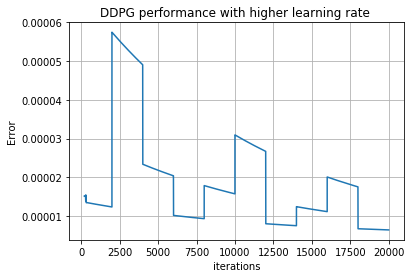

In [23]:
t1 = np.arange(1,19998)
plt.plot(t1[200:19997],PID.error[200:19998])
plt.title("DDPG performance with higher learning rate ")
plt.xlabel("iterations")
plt.ylabel("Error")
plt.grid()
plt.show()

In [24]:
i


NameError: name 'i' is not defined

In [ ]:
PID.error

In [28]:
classic = [2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2151.9260072003244, 2302.2989735595042, 2252.116001604028, 6.178886224006419e-05, -0.3258522429775894, 12.570803919448736, -0.41181160729229305, -0.8143032487923847, -0.029206051202436356, 2000.0, 41.479234076778766, 40.986963889885146, 40.500471479172575, 40.0196890397458, 39.54454956242921, 39.07498682443088, 38.61093538011323, 38.15233055187173, 37.69910842112313, 37.251205819396546, 36.80856031953272, 36.37111022698173, 35.938794571207836, 35.51155309719093, 35.08932625703119, 34.67205520165021, 34.25968177258869, 33.852148493904224, 33.44939856415999, 33.05137584850945, 32.65802487087262, 32.26929080620744, 31.885119472868155, 31.505457325054294, 31.130251445349586, 30.759449537347564, 30.392999918362648, 30.03085151223013, 29.672953842185507, 29.31925702383296, 28.969711758191806, 28.6242693248264, 28.282881575058127, 27.94550092525469, 27.612080350198767, 27.282573376533946, 26.956934076291645, 26.635117060486664, 26.317077472794836, 26.00277098330139, 25.692153782320702, 25.38518257429746, 25.081814571765108, 24.78200748938866, 24.485719538071407, 24.19290941912982, 23.903536318537363, 23.61755990124061, 23.334940305535383, 23.05563813751155, 22.7796144655656, 22.506830814972545, 22.237249162525814, 21.970831931239218, 21.70754198510781, 21.44734262393513, 21.190197578217976, 20.936071004092128, 20.684927478336704, 20.436731993438116, 20.19144995271222, 19.949047165481943, 19.70948984231427, 19.47274459030791, 19.238778408444887, 19.007558682986655, 18.77905318293392, 18.55323005553032, 18.330057821826585, 18.10950537229428, 17.891541962487963, 17.676137208761702, 17.46326108403605, 17.252883913613005, 17.04497637103941, 16.839509474021952, 16.63645458038718, 16.435783384090655, 16.237467911272915, 16.041480516357524, 15.84779387820413, 15.65638099629723, 15.467215186982912, 15.280270079755155, 15.095519613574425, 14.912938033241744, 14.732499885805055, 14.554180017014914, 14.377953567817713, 14.203795970893225, 14.031682947227637, 13.861590502734998, 13.693494924908691, 13.527372779519055, 13.3632009073483, 13.200956420962711, 13.040616701521913, 12.882159395628378, 12.725562412211048, 12.570803919448736, 12.41786234172514, 12.266716356624329, 12.117344891958282, 11.969727122830363, 11.823842468733574, 11.679670590682008, 11.537191388378233, 11.396384997408859, 11.257231786479906, 11.119712354677631, 10.98380752876892, 10.849498360525558, 10.716766124086234, 10.585592313345614, 10.455958639375012, 10.327847027875805, 10.20123961665854, 10.07611875315547, 9.952466991958545, 9.830267092390159, 9.70950201609935, 9.590154924687795, 9.472209177363538, 9.355648328622465, 9.240456125954779, 9.12661650758082, 9.014113600214614, 8.90293171684948, 8.793055354572743, 8.684469192404777, 8.577158089166687, 8.471107081365744, 8.36630138111309, 8.262726374063277, 8.160367617376323, 8.059210837704313, 7.959241929205291, 7.860446951574431, 7.762812128102951, 7.666323843758846, 7.570968643286733, 7.476733229336332, 7.38360446060733, 7.291569350017653, 7.200615062895395, 7.110728915189156, 7.021898371700445, 6.934111044336532, 6.847354690384918, 6.761617210807572, 6.676886648551545, 6.5931511868896, 6.5103991477635645, 6.428618990168388, 6.347799308532103, 6.2679288311385335, 6.188996418543866, 6.110991062035282, 6.03390188208914, 5.9577181268603, 5.882429170680098, 5.808024512575912, 5.734493774810744, 5.66182670143462, 5.590013156853047, 5.519043124422069, 5.4489067050431, 5.379594115790496, 5.311095688545265, 5.24340186864697, 5.176503213563819, 5.110390391577539, 5.045054180481657, 4.9804854662941125, 4.916675241991925, 4.8536146062524494, 4.791294762214648, 4.7297070162526325, 4.668842776763313, 4.608693552971545, 4.5492509537418755, 4.490506686416893, 4.432452555654891, 4.375080462290043, 4.318382402204179, 4.262350465211512, 4.206976833955423, 4.152253782820253, 4.098173676851957, 4.044728970698316, 3.9919122075543783, 3.9397160181231357, 3.888133119592112, 3.837156314612457, 3.7867784903028223, 3.736992617252554, 3.6877917485451235, 3.6391690187888344, 3.59111764316026, 3.5436309164597333, 3.49670221217616, 3.450324981562062, 3.4044927527245363, 3.3591991297194, 3.3144377916630674, 3.2702024918487496, 3.2264870568794777, 3.183285385804993, 3.140591449272506, 3.098399288686096, 3.056703015377252, 3.015496809782462, 2.974774920635582, 2.934531664162023, 2.8947614232899923, 2.855458646865827, 2.816617848881833, 2.7782336077107175, 2.7403005653497985, 2.7028134266770394, 2.6657669587091277, 2.6291559898738797, 2.592975409291739, 2.557220166060006, 2.5218852685520687, 2.4869657837180057, 2.4524568364017796, 2.418353608658208, 2.3846513390835753, 2.351345322151019, 2.3184309075543297, 2.2859034995626644, 2.2537585563768516, 2.2219915894970654, 2.1905981631005034, 2.1595738934174733, 2.1289144481265794, 2.0986155457476343, 2.068672955044349, 2.039082494435661, 2.009840031416161, 1.9809414819742415, 1.95238281002662, 1.9241600268562706, 1.8962691905549036, 1.8687064054740858, 1.8414678216843186, 1.8145496344327512, 1.7879480836215862, 1.7616594532778436, 1.7356800710351763, 1.710006307626145, 1.684634576374492, 1.6595613326946932, 1.6347830735981006, 1.6102963372061367, 1.5860977022668976, 1.5621837876763038, 1.5385512520126667, 1.5151967930651153, 1.492117147375211, 1.4693090897842467, 1.4467694329812275, 1.4244950270604022, 1.4024827590803852, 1.380729552632829, 1.3592323674122326, 1.3379881987912086, 1.3169940774050701, 1.2962470687346013, 1.2757442726986028, 1.255482823249622, 1.2354598879744572, 1.215672667701483, 1.196118396105021, 1.1767943393267615, 1.1576977955903658, 1.1388260948244806, 1.1201765982939378, 1.1017466982309543, 1.0835338174701974, 1.0655354090899891, 1.0477489560573758, 1.0301719708807013, 1.0128019952578597, 0.9956365997359171, 0.9786733833734615, 0.9619099734054544, 0.9453440249128562, 0.9289732204929351, 0.9127952699411708, 0.896807909929521, 0.8810089036878708, 0.8653960406995793, 0.8499671363877042, 0.8347200318125942, 0.8196525933706198, 0.8047627124969949, 0.7900483053715561, 0.7755073126293155, 0.7611376990726058, 0.746937453388, 0.7329045878645957, 0.7190371381191198, 0.7053331628228534, 0.6917907434258268, 0.678407983895795, 0.6651830104503915, 0.652113971297922, 0.6391990363763398, 0.6264363971015428, 0.6138242661145341, 0.6013608770308565, 0.5890444841957105, 0.5768733624402103, 0.5648458068396849, 0.5529601324815303, 0.5412146742226014, 0.5296077864620656, 0.5181378429103916, 0.506803236365613, 0.4956023784843637, 0.4845336995645084, 0.47359564832459, 0.4627866916896437, 0.45210531457223624, 0.4415500196694211, 0.43111932724832513, 0.4208117749410576, 0.4106259175412106, 0.40056032680149656, 0.3906135912386617, 0.3807843159311233, 0.37107112232911277, 0.36147264806027124, 0.35198754673911026, 0.34261448778238446, 0.33335215622059877, 0.32419925251656423, 0.315154492383499, 0.3062166066067675, 0.29738434086675625, 0.28865645556220443, 0.2800317256408107, 0.27150894042711116, 0.2630869034510397, 0.25476443228762946, 0.2465403583837542, 0.23841352690260464, 0.2303827965599794, 0.2224470394630771, 0.2146051409579286, 0.2068559994700081, 0.19919852635257485, 0.1916316457341054, 0.18415429437095554, 0.17676542149570196, 0.16946398867071366, 0.1622489696478624, 0.15511935022050238, 0.14807412808431764, 0.14111231269816926, 0.1342329251456249, 0.12743499799739766, 0.12071757517810511, 0.11407971183120935, 0.10752047418986876, 0.10103893944551601, 0.09463419561711817, 0.08830534142884972, 0.08205148618003477, 0.07587174962350218, 0.0697652618414395, 0.06373116312693128, 0.057768603858676215, 0.051876744388437146, 0.046054754922352004, 0.04030181540247213, 0.03461711539580392, 0.028999853980849366, 0.02344923963300971, 0.01796449011817458, 0.012544832382445747, 0.007189502444134632, 0.0018977452855324373, -0.0033311852494080085, -0.00849802655966414, -0.013603507392190295, -0.01864834793832415, -0.023633259942926088, -0.02855894679373705, -0.03342610362551568, -0.03823541741530789, -0.04298756707794382, -0.04768322356108001, -0.052323049938877375, -0.05690770150317803, -0.0614378258560464, -0.06591406299889968, -0.0703370454243668, -0.07470739820064409, -0.07902573906062571, -0.0832926784898973, -0.08750881980608938, -0.0916747592500542, -0.09579108606362752, -0.09985838257307478, -0.10387722427299195, -0.10784817990270312, -0.1117718115272055, -0.11564867461538597, -0.11947931811823764, -0.12326428454389315, -0.12700411003311274, -0.13069932443704602, -0.13435045138612622, -0.1379580083687415, -0.14152250679671852, -0.14504445208285688, -0.148524343707777, -0.15196267529086072, -0.15535993465846332, -0.15871660391167097, -0.16203315949474018, -0.16531007225898975, -0.16854780753124032, -0.1717468251788432, -0.17490757966947967, -0.17803052014073728, -0.1811160904553617, -0.18416472927015093, -0.1871768700937082, -0.19015294134624128, -0.19309336642072594, -0.19599856374156843, -0.19886894682213097, -0.2017049243247584, -0.20450690011307415, -0.20727527331359852, -0.21001043836804456, -0.2127127850890247, -0.21538269871484772, -0.21802055996249692, -0.22062674508083546, -0.223201625904494, -0.22574556990343808, -0.22825894023526416, -0.23074209579613125, -0.23319539126964628, -0.23561917717665892, -0.23801379992687544, -0.2403796018625144, -0.242716921309011, -0.2450260926214014, -0.24730744623002465, -0.24956130868986293, -0.25178800271942237, -0.2539878472541659, -0.2561611574849394, -0.2583082449034464, -0.2604294173456765, -0.2625249790369253, -0.2645952306284016, -0.26664046924770446, -0.2686609885324742, -0.2706570786754128, -0.27262902646225484, -0.27457711531610585, -0.2765016253306385, -0.27840283331397586, -0.28028101282643547, -0.28213643421759116, -0.28396936466378975, -0.2857800682058951, -0.2875688057865773, -0.2893358352857831, -0.2910814115582525, -0.2928057864651237, -0.29450920891622445, -0.29619192489644774, -0.297854177504405, -0.2994962069888061, -0.30111825077483445, -0.30272054350302824, -0.30430331706293146, -0.30586680061878724, -0.30741122064750925, -0.3089368009673308, -0.3104437627707739, -0.3119323246539807, -0.3134027026478634, -0.3148551102478905, -0.31628975844546403, -0.31770685575247626, -0.3191066082379166, -0.32048921954969956, -0.3218548909464971, -0.32320382132684244, -0.32453620725141263, -0.3258522429775894, -0.3271521204819692, -0.3284360294871931, -0.32970415749127824, -0.3309566897892182, -0.33219380950413324, -0.3334156976086433, -0.3346225329519257, -0.33581449228449856, -0.3369917502827775, -0.3381544795706759, -0.3393028507505278, -0.340437032420823, -0.3415571911996267, -0.3426634917516367, -0.34375609680955677, -0.3448351671945602, -0.34590086184130087, -0.34695333781883164, -0.3479927503549334, -0.34901925285294055, -0.3500329969167524, -0.3510341323731154, -0.352022807287085, -0.35299916798953745, -0.35396335909081245, -0.3549155235066337, -0.3558558024744798, -0.35678433557427525, -0.35770126074953623, -0.3586067143216951, -0.3595008310144294, -0.36038374397048756, -0.3612555847710155, -0.3621164834494266, -0.3629665685175496, -0.36380596697586043, -0.36463480433599216, -0.3654532046350596, -0.366261290456805, -0.36705918294410367, -0.36784700182101915, -0.36862486540235295, -0.36939289061865566, -0.3701511930257766, -0.370899886824418, -0.37163908487423214, -0.3723688987111018, -0.3730894385621468, -0.3738008133607309, -0.3745031307610134, -0.3751964971545476, -0.375881017683696, -0.3765567962586829, -0.37722393556850875, -0.37788253709663877, -0.3785327011382833, -0.3791745268079012, -0.3798081120601182, -0.3804335536972303, -0.38105094738807566, -0.381660387677357, -0.3822619680001935, -0.38285578069530857, -0.3834419170179899, -0.3840204671532774, -0.3845915202252854, -0.38515516431607466, -0.3857114864701998, -0.3862605727128994, -0.38680250806032745, -0.38733737652933087, -0.3878652611506368, -0.38838624398226784, -0.38890040611772747, -0.3894078276998698, -0.38990858792953986, -0.3904027650808075, -0.39089043650619715, -0.3913716786519217, -0.3918465670672049, -0.39231517641405844, -0.39277758047842326, -0.3932338521806287, -0.3936840635851695, -0.3941282859102557, -0.39456658953895385, -0.39499904402759967, -0.3954257181178491, -0.39584667974236254, -0.396261996038902, -0.39667173335510597, -0.3970759572619045, -0.39747473255897603, -0.39786812328657106, -0.39825619273415214, -0.3986390034458509, -0.39901661723502, -0.3993890951874164, -0.3997564976718877, -0.40011888435083165, -0.40047631418406127, -0.40082884544062836, -0.40117653570518996, -0.40151944188778543, -0.4018576202299755, -0.40219112631234566, -0.4025200150645105, -0.4028443407703435, -0.40316415707775377, -0.4034795170041434, -0.4037904729452748, -0.40409707668186456, -0.40439937938685944, -0.40469743163339444, -0.4049912833993403, -0.4052809840775353, -0.4055665824812422, -0.4058481268493779, -0.40612566485674506, -0.40639924361676094, -0.4066689096910068, -0.40693470909491225, -0.4071966873029851, -0.40745488925699647, -0.40770935936961905, -0.4079601415344314, -0.4082072791286464, -0.40845081502016, -0.408690791574827, -0.40892725066123603, -0.4091602336550295, -0.40938978144799876, -0.4096159344512671, -0.40983873260279324, -0.41005821536941767, -0.410274421756867, -0.4104873903133921, -0.41069715913272375, -0.4109037658631678, -0.4111072477107882, -0.41130764144531895, -0.4115049834049387, -0.41169930950059097, -0.4118906552221233, -0.41207905564374414, -0.4122645454267513, -0.4124471588272627, -0.412626929697808, -0.41280389149324037, -0.41297807727733016, -0.413149519726403, -0.41331825113024934, -0.4134843034039477, -0.41364770808309004, -0.4138084963365145, -0.4139666989683519, -0.4141223464171162, -0.4142754687679826, -0.41442609574937705, -0.41457425674457227, -0.4147199807907782, -0.4148632965818706, -0.4150042324786227, -0.41514281650688645, -0.41527907636486816, -0.4154130394238109, -0.4155447327352704, -0.4156741830336159, -0.41580141673853177, -0.4159264599584276, -0.41604933849816916, -0.4161700778588511, -0.41628870324120726, -0.4164052395503859, -0.41651971140095156, -0.41663214311506636, -0.41674255873408583, -0.41685098201378423, -0.4169574364327673, -0.4170619451922448, -0.4171645312237615, -0.41726521718737786, -0.41736402547871876, -0.41746097823079253, -0.4175560973149004, -0.4176494043481398, -0.41774092069113067, -0.41783066745574615, -0.4179186655073863, -0.4180049354633866, -0.41808949770052095, -0.4181723723570485, -0.4182535793347597, -0.41833313829988583, -0.4184110686899203, -0.41848738971543753, -0.41856212035804674, -0.41863527937857725, -0.41870688531798805, -0.41877695649941415, -0.4188455110304403, -0.41891256680582956, -0.41897814151070634, -0.41904225262442196, -0.4191049174173713, -0.4191661529614521, -0.41922597612483514, -0.41928440358014996, -0.41934145180198357, -0.4193971370739291, -0.41945147548676687, -0.41950448294346643, -0.41955617516009625, -0.41960656766809734, -0.4196556758167844, -0.4197035147749375, -0.4197500995335304, -0.41979544490800436, -0.4198395655391778, -0.41988247589711136, -0.4199241902815629, -0.4199647228224421, -0.42000408748776863, -0.4200422980784424, -0.4200793682339281, -0.42011531143612046, -0.4201501410050241, -0.420183870106257, -0.4202165117521872, -0.42024807879761283, -0.4202785839538592, -0.4203080397760459, -0.42033645867650193, -0.42036385291862643, -0.4203902346250743, -0.4204156157743455, -0.42044000820465044, -0.42046342361413735, -0.42048587356725875, -0.4205073694879502, -0.42052792266918004, -0.4205475442718125, -0.420566245322334, -0.4205840367217206, -0.4206009292406634, -0.4206169335238883, -0.4206320600919753, -0.4206463193409036, -0.4206597215450074, -0.42067227685879516, -0.4206839953164945, -0.4206948868352356, -0.4207049612157334, -0.4207142281425149, -0.4207226971889213, -0.4207303778143796, -0.42073727936599425, -0.4207434110826398, -0.4207487820958704, -0.42075340142855566, -0.42075727799783635, -0.42076042061580665, -0.4207628379920152, -0.4207645387323282, -0.4207655313446139, -0.42076582423351283, -0.4207654257068043, -0.42076434397495177, -0.42076258715087533, -0.4207601632533624, -0.42075708020570346, -0.42075334584046686, -0.4207489678967704, -0.42074395402164555, -0.42073831177458487, -0.4207320486257231, -0.4207251719572014, -0.4207176890656683, -0.4207096071597789, -0.42070093336519676, -0.420691674723912, -0.4206818381944686, -0.4206714306556023, -0.42066045890237547, -0.4206489296527707, -0.420636849544735, -0.420624225137999, -0.4206110629158957, -0.4205973692860425, -0.4205831505803417, -0.42056841305497983, -0.42055316289520306, -0.42053740621213365, -0.42052114904618065, -0.4205043973647662, -0.42048715706891926, -0.42046943398645453, -0.4204512338787936, -0.4204325624402827, -0.4204134252968288, -0.42039382800885505, -0.42037377607425697, -0.42035327491953467, -0.4203323299157091, -0.4203109463646797, -0.42028912950877384, -0.42026688452961025, -0.42024421654537036, -0.4202211306155732, -0.42019763174039326, -0.42017372486293425, -0.4201494148637721, -0.42012470657095946, -0.42009960475206753, -0.4200741141223716, -0.4200482393391667, -0.4200219850058602, -0.41999535567151725, -0.4199683558331344, -0.4199409899326838, -0.41991326236211535, -0.4198851774601735, -0.4198567395162627, -0.4198279527681734, -0.4197988214036741, -0.41976934956301193, -0.4197395413366394, -0.41970940076657826, -0.4196789318498304, -0.4196481385329207, -0.41961702471826356, -0.41958559426325337, -0.41955385097662656, -0.41952179862687444, -0.4194894409340577, -0.41945678157776456, -0.4194238241916537, -0.4193905723700482, -0.4193570296613416, -0.4193231995759561, -0.4192890855790665, -0.41925469109969526, -0.41922001952252685, -0.4191850741945018, -0.4191498584243618, -0.419114375479694, -0.4190786285903414, -0.4190426209479483, -0.41900635571005296, -0.4189698359925842, -0.4189330648766827, -0.4188960454075641, -0.41885878059406423, -0.4188212734109129, -0.41878352679714226, -0.41874554365585936, -0.4187073268590211, -0.41866887924288676, -0.41863020361142844, -0.41859130273314804, -0.4185521793483531, -0.4185128361614261, -0.41847327584719096, -0.4184335010477298, -0.4183935143751114, -0.41835331841025436, -0.41831291570383655, -0.4182723087762952, -0.4182315001189636, -0.41819049219384397, -0.4181492874338346, -0.4181078882429574, -0.41806629699840414, -0.4180245160466711, -0.4179825477108352, -0.4179403942821409, -0.4178980580284133, -0.41785554118996515, -0.4178128459795971, -0.4177699745841892, -0.4177269291672019, -0.41768371186458353, -0.41764032478795343, -0.41759677002369244, -0.41755304963430717, -0.4175091656568384, -0.41746512010740844, -0.4174209149746275, -0.41737655222596004, -0.41733203380499617, -0.4172873616337256, -0.4172425376100364, -0.41719756361044347, -0.4171524414889518, -0.41710717307796585, -0.41706176018851693, -0.417016204610718, -0.4169705081126267, -0.41692467244206455, -0.4168786993266167, -0.4168325904734047, -0.4167863475697686, -0.41673997228167536, -0.4166934662582662, -0.41664683112730927, -0.41660006849747333, -0.41655317995923724, -0.4165061670837531, -0.41645903142534735, -0.4164117745185649, -0.4163643978802156, -0.41631690300778246, -0.41626929138510604, -0.41622156447465386, -0.41617372372434147, -0.4161257705632124, -0.4160777064043941, -0.41602953264464304, -0.4159812506641174, -0.41593286182683187, -0.4158843674799755, -0.41583576895618535, -0.4157870675705908, -0.415738264626043, -0.41568936140652113, -0.41564035918327136, -0.4155912592120785, -0.415542062733266, -0.41549277097374215, -0.4154433851444992, -0.41539390644470586, -0.41534433605602317, -0.41529467514942553, -0.4152449248801986, -0.41519508639134983, -0.41514516081065267, -0.41509514925542135, -0.4150450528265992, -0.4149948726146704, -0.41494460969693137, -0.41489426513589933, -0.4148438399852239, -0.41479333528241114, -0.4147427520556448, -0.41469209132037577, -0.41464135407795766, -0.4145905413217861, -0.41453965402956783, -0.4144886931715064, -0.4144376597023438, -0.41438655456931883, -0.4143353787048909, -0.41428413303538036, -0.41423281847096405, -0.4141814359147702, -0.41412998625696673, -0.4140784703802183, -0.4140268891528649, -0.41397524343619807, -0.41392353408036797, -0.4138717619257477, -0.41381992780247856, -0.41376803253047, -0.4137160769205366, -0.41366406177439785, -0.4136119878853606, -0.41355985603354384, -0.4135076669947466, -0.41345542153112547, -0.41340312039983473, -0.4133507643455232, -0.41329835410761007, -0.4132458904136911, -0.41319337398522293, -0.4131408055347947, -0.4130881857640816, -0.41303551536975647, -0.41298279503894264, -0.4129300254503505, -0.4128772072756419, -0.41282434117738376, -0.4127714278113217, -0.4127184678254707, -0.4126654618592056, -0.41261241054576203, -0.41255931451019023, -0.41250617436980974, -0.41245299073625574, -0.41239976421138635, -0.4123464953927396, -0.4122931848692133, -0.41223983322288404, -0.41218644102923463, -0.412133008857154, -0.41207953726870983, -0.41202602681869394, -0.41197247805689585, -0.4119188915256018, -0.41186526776118626, -0.41181160729229305, -0.4117579106427911, -0.41170417832995554, -0.41165041086674137, -0.4115966087558718, -0.4115427724991605, -0.41148890258841675, -0.41143499951090234, -0.4113810637500137, -0.4113270957805071, -0.4112730960744102, -0.41121906509602013, -0.4111650033044043, -0.41111091115544696, -0.4110567890970742, -0.4110026375733469, -0.4109484570217319, -0.4108942478762856, -0.4108400105646979, -0.4107857455096564, -0.4107314531299835, -0.4106771338397266, -0.4106227880447477, -0.410568416151591, -0.410514018556114, -0.41045959565485646, -0.4104051478357178, -0.4103506754843238, -0.4102961789803885, -0.41024165870021534, -0.41018711501556027, -0.41013254829226753, -0.4100779588943624, -0.410023347179731, -0.40996871350353103, -0.4099140582138716, -0.4098593816590892, -0.4098046841791074, -0.4097499661127131, -0.40969522779346335, -0.40964046955195954, -0.4095856917135734, -0.4095308946007208, -0.4094760785319522, -0.4094212438219529, -0.4093663907815426, -0.40931151971881263, -0.40925663093594267, -0.4092017247351123, -0.40914680141054305, -0.4090918612562291, -0.40903690456320874, -0.4089819316170633, -0.4089269426992814, -0.40887193808998745, -0.40881691806680465, -0.4087618829009898, -0.4087068328631176, -0.40865176821921523, -0.4085966892337183, -0.4085415961662875, -0.4084864892738551, -0.4084313688115344, -0.4083762350298912, -0.4083210881776722, -0.40826592849975896, -0.40821075623875913, -0.4081555716343246, -0.40810037492360607, -0.4080451663405711, -0.40798994611577655, -0.4079347144784151, -0.40787947165335936, -0.4078242178650271, -0.40776895333260654, -0.40771367827528593, -0.407658392907706, -0.4076030974426885, -0.40754779209032677, -0.40749247705866765, -0.40743715255416646, -0.4073818187780489, -0.4073264759308586, -0.40727112421154743, -0.4072157638165663, -0.40716039493872813, -0.4071050177692541, -0.40704963249595494, -0.40699423930846024, -0.40693883838866896, -0.40688342992075377, -0.40682801408297564, -0.4067725910549598, -0.40671716101314814, -0.40666172412920787, -0.4066062805779893, -0.40655083052638474, -0.4064953741433328, -0.4064399115964079, -0.40638444304704535, -0.4063289686580447, -0.40627348858993173, -0.40621800300004907, -0.4061625120455119, -0.4061070158804796, -0.40605151465683775, -0.4059960085255625, -0.40594049763694784, -0.40588498213719504, -0.40582946217114113, -0.40577393788430527, -0.405718409416977, -0.40566287691081016, -0.40560734050427527, -0.40555180033493343, -0.40549625653648036, -0.40544070924534026, -0.40538515859179824, -0.40532960470773105, -0.40527404772205955, -0.4052184877614309, -0.40516292495362904, -0.4051073594223453, -0.40505179129104363, -0.4049962206811415, -0.404940647713147, -0.40488507250643124, -0.4048294951778644, -0.40477391584340694, -0.4047183346176553, -0.4046627516145236, -0.40460716694565235, -0.4045515807215452, -0.4044959930515688, -0.40444040404440784, -0.4043848138062458, -0.4043292224432662, -0.4042736300582419, -0.4042180367553101, -0.4041624426358794, -0.4041068478009038, -0.4040512523495181, -0.4039956563794931, -0.40394005998882676, -0.4038844632736982, -0.40382886632801274, -0.4037732692440841, -0.40371767211672704, -0.4036620750368911, -0.4036064780948436, -0.4035508813785782, -0.40349528497790743, -0.4034396889785512, -0.40338409346895787, -0.4033284985314367, -0.4032729042514802, -0.4032173107125345, -0.40316171799577205, -0.4031061261832747, -0.4030505353539411, -0.4029949455887163, -0.40293935696399785, -0.40288376955868443, -0.40282818344780935, -0.4027725987075428, -0.4027170154131454, -0.4026614336378316, -0.40260585345345135, -0.4025502749334464, -0.40249469814807526, -0.4024391231678237, -0.4023835500622681, -0.4023279789003027, -0.40227240974923006, -0.4022168426747612, -0.402161277745563, -0.4021057150262095, -0.4020501545803654, -0.4019945964728322, -0.4019390407656829, -0.40188348752280945, -0.40182793680446593, -0.4017723886713611, -0.4017168431853406, -0.40166130040393, -0.4016057603869285, -0.40155022319163436, -0.4014946888753457, -0.4014391574949059, -0.4013836291062489, -0.4013281037650813, -0.4012725815259728, -0.40121706244190136, -0.40116154656652725, -0.40110603395328326, -0.40105052465355584, -0.40099501871850407, -0.40093951619996915, -0.4008840171479733, -0.4008285216095828, -0.40077302963754846, -0.40071754127825443, -0.4006620565796766, -0.40060657558888124, -0.4005510983536169, -0.40049562491799406, -0.40044015532998856, -0.40038468963302876, -0.40032922787213465, -0.40027377009141674, -0.40021831633293914, -0.40016286664240397, -0.4001074210596016, -0.40005197962727834, -0.3999965423870435, -0.39994110937868754, -0.3998856806438198, -0.3998302562226854, -0.39977483615371057, -0.3997194204760035, -0.39966400922730827, -0.39960860244650576, -0.3995532001722495, -0.39949780243910027, -0.399442409285939, -0.3993870207477812, -0.3993316368600972, -0.3992762576592668, -0.39922088317962334, -0.3991655134557277, -0.3991101485216859, -0.39905478841046715, -0.3989994331568596, -0.39894408279201343, -0.3988887373500347, -0.3988333968613915, -0.39877806135814353, -0.39872273087303256, -0.3986674054344803, -0.3986120850752286, -0.39855676982369914, -0.39850145971081474, -0.39844615476567924, -0.39839085501739646, -0.3983355604946155, -0.3982802712259854, -0.3982249872383363, -0.3981697085605447, -0.3981144352201227, -0.3980591672441278, -0.39800390465711644, -0.39794864748819236, -0.39789339576213933, -0.39783814950396845, -0.39778290874096456, -0.3977276734960924, -0.39767244379527256, -0.3976172196632888, -0.39756200112424267, -0.3975067882001895, -0.3974515809170498, -0.39739637929778837, -0.3973411833642331, -0.3972859931398034, -0.39723080864769145, -0.39717562990836086, -0.39712045694432163, -0.3970652897785385, -0.39701012843011085, -0.3969549729224582, -0.39689982327490725, -0.3968446795088312, -0.39678954164355673, -0.39673440970045704, -0.39667928369794936, -0.3966241636569521, -0.39656904959610983, -0.396513941534522, -0.39645883949197014, -0.39640374348596197, -0.3963486535346874, -0.3962935696572458, -0.3962384918713724, -0.3961834201943475, -0.39612835464413365, -0.3960732952377839, -0.3960182419925786, -0.39596319492579823, -0.39590815405290414, -0.395853119390722, -0.39579809095607743, -0.3957430687644319, -0.395688052832611, -0.39563304317539405, -0.3955780398077877, -0.3955230427452534, -0.39546805200393464, -0.395413067598156, -0.3953580895417872, -0.3953031178496076, -0.39524815253639645, -0.39519319361602356, -0.39513824110326823, -0.39508329501018125, -0.3950283553515419, -0.39497342214122, -0.3949184953917211, -0.3948635751157781, -0.3948086613272608, -0.39475375403776525, -0.39469885326138865, -0.39464395900972704, -0.3945890712943765, -0.39453419012852464, -0.3944793155237676, -0.3944244474923835, -0.394369586045741, -0.3943147311949815, -0.39425988295124625, -0.39420504132658607, -0.39415020633146014, -0.3940953779774645, -0.39404055627483103, -0.39398574123424623, -0.3939309328661693, -0.3938761311817416, -0.39382133619051274, -0.3937665479027146, -0.39371176632880633, -0.3936569914772008, -0.393602223359494, -0.39354746198409885, -0.3934927073610197, -0.39343795949866944, -0.393383218407962, -0.393328484096628, -0.393273756574672, -0.39321903584891515, -0.39316432193140827, -0.39310961482738094, -0.3930549145484292, -0.39300022110023747, -0.39294553449258274, -0.39289085473410523, -0.3928361818313988, -0.3927815157940131, -0.3927268566287694, -0.39267220434430783, -0.39261755894676753, -0.3925629204445613, -0.3925082888467841, -0.3924536641575287, -0.3923990463872542, -0.3923444355407355, -0.3922898316259307, -0.39223523465011567, -0.39218064461988433, -0.39212606154228524, -0.39207148542391224, -0.3920169162711318, -0.3919623540903103, -0.3919077988880417, -0.3918532506711472, -0.3917987094457658, -0.39174417521758187, -0.39168964799250716, -0.39163512777668075, -0.39158061457692384, -0.39152610839823865, -0.3914716092458548, -0.39141711712659344, -0.3913626320452295, -0.3913081540085841, -0.39125368302075003, -0.3911992190869569, -0.39114476221379846, -0.3910903124046854, -0.39103586966689363, -0.3909814340038338, -0.39092700542073544, -0.39087258392328295, -0.390818169515569, -0.3907637622025959, -0.3907093619891384, -0.39065496888042617, -0.39060058288009714, -0.39054620399292617, -0.39049183222414285, -0.39043746757670306, -0.390383110055609, -0.3903287596656355, -0.3902744164104206, -0.3902200802947391, -0.3901657513220016, -0.39011142949630084, -0.39005711482172956, -0.39000280730147097, -0.38994850694075467, -0.38989421374230915, -0.3898399277097724, -0.3897856488479192, -0.38973137715947814, -0.3896771126483145, -0.3896228553178389, -0.3895686051719167, -0.38951436221213953, -0.38946012644373695, -0.3894058978701196, -0.38935167649378855, -0.38929746231815443, -0.3892432553459457, -0.3891890555808004, -0.389134863025447, -0.3890806776826139, -0.3890264995561665, -0.3889723286483786, -0.3889181649619786, -0.3888640084994677, -0.3888098592649385, -0.38875571726043745, -0.3887015824882383, -0.38864745495106945, -0.38859333465165946, -0.3885392215927368, -0.38848511577702993, -0.38843101720635786, -0.3883769258834491, -0.3883228418105773, -0.3882687649906984, -0.38821469542494924, -0.3881606331171952, -0.3881065780676636, -0.38805253028067455, -0.3879984897562281, -0.3879444564977348, -0.3878904305074684, -0.3878364117867932, -0.3877824003382102, -0.38772839616285637, -0.3876743992639149, -0.38762040964229527, -0.3875664273004986, -0.38751245224011654, -0.3874584844618312, -0.3874045239692805, -0.387350570763374, -0.38729662484593064, -0.38724268621808733, -0.3871887548818904, -0.3871348308389315, -0.38708091409080225, -0.3870270046393216, -0.3869731024849443, -0.38691920763062626, -0.3868653200765948, -0.38681143982535104, -0.38675756687734975, -0.38670370123395514, -0.386649842897441, -0.3865959918680346, -0.38654214814755505, -0.3864883117375939, -0.3864344826395154, -0.3863806608528648, -0.3863268463799159, -0.3862730392220328, -0.3862192393805799, -0.38616544685601184, -0.38611166164946553, -0.3860578837625326, -0.38600411319544037, -0.3859503499500079, -0.38589659402578036, -0.3858428454254863, -0.38578910414958045, -0.38573537019851756, -0.38568164357275236, -0.38562792427410386, -0.3855742123030268, -0.38552050766065804, -0.3854668103469976, -0.3854131203634097, -0.3853594377103491, -0.38530576238872527, -0.38525209440012986, -0.38519843374365337, -0.3851447804202053, -0.38509113443205933, -0.3850374957785334, -0.38498386446008226, -0.38493024047693325, -0.3848766238309054, -0.38482301452268075, -0.38476941255089514, -0.3847158179178223, -0.3846622306241443, -0.3846086506684969, -0.3845550780531539, -0.38450151277743316, -0.3844479548424715, -0.384394404248269, -0.38434086099573506, -0.38428732508464236, -0.3842337965149909, -0.3841802752883723, -0.3841267614043318, -0.3840732548635515, -0.3840197556660314, -0.38396626381177157, -0.3839127793012267, -0.38385930213553365, -0.38380583231310084, -0.3837523698359746, -0.38369891470324546, -0.3836454669158229, -0.38359202647347956, -0.3835385933764428, -0.38348516762494, -0.3834317492187438, -0.3833783381583089, -0.38332493444363536, -0.3832715380749505, -0.3832181490529365, -0.3831647673760017, -0.38311139304619246, -0.38305802606146244, -0.38300466642340325, -0.3829513141320149, -0.3828979691861605, -0.3828446315869769, -0.38279130133355466, -0.3827379784270306, -0.3826846628660405, -0.3826313546508118, -0.38257805378225385, -0.3825247602596846, -0.38247147408264937, -0.38241819525137544, -0.3823649237660902, -0.38231165962565683, -0.3822584028316669, -0.3822051533818467, -0.38215191127733306, -0.382098676518126, -0.3820454491037708, -0.38199222903404007, -0.38193901630825167, -0.38188581092686036, -0.38183261288963877, -0.38177942219613215, -0.3817262388463405, -0.38167306283912694, -0.38161989417585573, -0.38156673285493525, -0.381513578877275, -0.38146043224128334, -0.38140729294741504, -0.3813541609947606, -0.38130103638377477, -0.3812479191140028, -0.38119480918567206, -0.38114170659719093, -0.3810886113481047, -0.38103552343977753, -0.38098244286993577, -0.380929369640171, -0.38087630374843684, -0.38082324519541544, -0.38077019398042466, -0.3807171501027824, -0.38066411356226126, -0.3806110843584065, -0.38055806249121815, -0.38050504795933193, -0.38045204076365735, -0.3803990409032849, -0.38034604837639563, -0.3802930631845811, -0.38024008532647713, -0.3801871148016289, -0.380134151609127, -0.38008119574988086, -0.3800282472220715, -0.37997530602501683, -0.3799223721596263, -0.3798694456249905, -0.3798165264186082, -0.3797636145436627, -0.3797107099967434, -0.3796578127776229, -0.3796049228874381, -0.3795520403239152, -0.379499165087509, -0.37944629717708267, -0.37939343659240876, -0.3793405833328052, -0.37928773739804456, -0.37923489878676264, -0.37918206749895944, -0.37912924353463495, -0.3790764268919702, -0.3790236175711925, -0.37897081557230194, -0.37891802089257, -0.37886523353358825, -0.37881245349376513, -0.37875968077287325, -0.37870691536977574, -0.3786541572837905, -0.37860140651514484, -0.3785486630624746, -0.3784959269257797, -0.3784431981034686, -0.37839047659645075, -0.37833776240154293, -0.3782850555210189, -0.37823235595260485, -0.37817966369539135, -0.37812697874983314, -0.3780743011136565, -0.37802163078777085, -0.377968967770812, -0.37791631206300735, -0.37786366366185575, -0.37781102256803933, -0.3777583887799665, -0.37770576229786457, -0.37765314312127884, -0.37760053124816295, -0.3775479266785169, -0.37749532941165853, -0.37744273944713314, -0.3773901567840312, -0.37733758142144325, -0.3772850133589145, -0.37723245259530813, -0.37717989913016936, -0.3771273529625887, -0.37707481409256616, -0.37702228251828274, -0.3769697582401932, -0.376917241255569, -0.37686473156600186, -0.37681222916944535, -0.3767597340647626, -0.3767072462537726, -0.37665476573147316, -0.376602292500138, -0.37654982655863023, -0.3764973679060404, -0.3764449165410042, -0.37639247246306695, -0.37634003567131913, -0.376287606165306, -0.37623518394411803, -0.3761827690073005, -0.3761303613534892, -0.37607796098222934, -0.3760255678919293, -0.37597318208327124, -0.37592080355420876, -0.3758684323047419, -0.37581606833327896, -0.37576371163982003, -0.37571136222300083, -0.375659020082594, -0.3756066852172353, -0.37555435762646994, -0.37550203730870635, -0.3754497242641719, -0.3753974184915023, -0.37534511998956077, -0.37529282875811987, -0.37524054479695224, -0.3751882681042389, -0.37513599867816083, -0.3750837365203097, -0.37503148162795696, -0.37497923400133004, -0.37492699363860993, -0.3748747605402514, -0.37482253470466276, -0.37477031613025247, -0.37471810481679313, -0.3746659007647395, -0.37461370397159044, -0.37456151443666386, -0.37450933215995974, -0.3744571571396591, -0.37440498937576194, -0.37435282886644927, -0.37430067561194846, -0.37424852961044053, -0.3741963908616981, -0.37414425936481166, -0.374092135118417, -0.37404001812205934, -0.3739879083748292, -0.373935805875135, -0.37388371062388615, -0.37383162261812686, -0.37377954185831186, -0.3737274683439864, -0.37367540207219463, -0.3736233430440734, -0.3735712912575764, -0.3735192467129309, -0.373467209408318, -0.3734151793426008, -0.3733631565162341, -0.37331114092694406, -0.37325913257382126, -0.3732071314575478, -0.37315513757584995, -0.3731031509280456, -0.3730511715139073, -0.37299919933184356, -0.37294723438026267, -0.37289527666030153, -0.3728433261699138, -0.3727913829072804, -0.3727394468730836, -0.372687518065959, -0.3726355964843151, -0.3725836821279245, -0.3725317749951955, -0.3724798750863556, -0.37242798240026787, -0.37237609693488594, -0.3723242186902098, -0.37227234766487527, -0.3722204838586549, -0.3721686272704119, -0.3721167778985546, -0.3720649357426282, -0.3720131008021781, -0.37196127307561255, -0.37190945256247687, -0.37185763926117943, -0.3718058331712655, -0.371754034292735, -0.3717022426226322, -0.37165045816141173, -0.37159868090839154, -0.3715469108612979, -0.37149514802081285, -0.3714433923848901, -0.3713916439530749, -0.3713399027244577, -0.3712881686972196, -0.3712364418713605, -0.3711847222466531, -0.3711330098212784, -0.37108130459319, -0.37102960656375217, -0.37097791573000904, -0.37092623209173325, -0.37087455564847005, -0.3708228863997647, -0.3707712243433434, -0.3707195694780694, -0.37066792180439734, -0.37061628132073565, -0.37056464802594746, -0.37051302191935065, -0.3704614030000357, -0.37040979126641105, -0.37035818671915877, -0.37030658935577776, -0.3702549991758133, -0.37020341617835584, -0.37015184036226856, -0.37010027172664195, -0.37004871027102126, -0.3699971559938149, -0.3699456088952502, -0.36989406897214394, -0.369842536225633, -0.36979101065435316, -0.3697394922571675, -0.3696879810322571, -0.3696364769800766, -0.369584980098125, -0.3695334903879939, -0.3694820078455905, -0.36943053247250646, -0.36937906426578593, -0.36932760322588365, -0.3692761493514354, -0.3692247026424411, -0.369173263095945, -0.36912183071171967, -0.36907040549044723, -0.3690189874284897, -0.36896757652721135, -0.3689161727843384, -0.36886477619941616, -0.3688133867713077, -0.36876200449933094, -0.368710629382349, -0.368659261419225, -0.3686079006088221, -0.3685565469506855, -0.36850520044413315, -0.36845386108689127, -0.3684025288794146, -0.3683512038205663, -0.36829988590852736, -0.36824857514261566, -0.36819727152260384, -0.3681459750466729, -0.36809468571482284, -0.3680434035252347, -0.3679921284769989, -0.36794086056920605, -0.3678895998016287, -0.3678383461726753, -0.36778709968029943, -0.36773586032677485, -0.36768462810778146, -0.36763340302354663, -0.36758218507316087, -0.3675309742563968, -0.36747977057052594, -0.36742857401600304, -0.367377384592146, -0.3673262022969084, -0.3672750271298355, -0.3672238590897905, -0.36717269817563647, -0.3671215443866913, -0.367070397722955, -0.36701925818238124, -0.3669681257636057, -0.36691700046594633, -0.3668658822891757, -0.3668147712314749, -0.3667636672921617, -0.36671257047078143, -0.36666148076574245, -0.3666103981761353, -0.36655932270150515, -0.36650825433957834, -0.3664571930914917, -0.3664061389545168, -0.3663550919284262, -0.3663040520125378, -0.3662530192043505, -0.36620199350522853, -0.36615097491221604, -0.36609996342508566, -0.3660489590427005, -0.3659979617650606, -0.3659469715898922, -0.36589598851674054, -0.36584501254469615, -0.36579404367262214, -0.36574308190006377, -0.36569212722520206, -0.36564117964849174, -0.36559023916720434, -0.3655393057808851, -0.36548837948976143, -0.36543746029155955, -0.3653865481849152, -0.3653356431705106, -0.3652847452469814, -0.36523385441182654, -0.36518297066572813, -0.3651320940068672, -0.36508122443478896, -0.36503036194790184, -0.3649795065464332, -0.3649286582278819, -0.36487781699224797, -0.3648269828379398, -0.36477615576427525, -0.3647253357707996, -0.36467452285614854, -0.36462371701873053, -0.3645729182587729, -0.36452212657422933, -0.36447134196532716, -0.36442056442979265, -0.36436979396717106, -0.3643190305767803, -0.36426827425725605, -0.3642175250076889, -0.3641667828269419, -0.36411604771524253, -0.3640653196698622, -0.3640145986905736, -0.36396388477737673, -0.3639131779270883, -0.36386247814107264, -0.36381178541773807, -0.36376109975481086, -0.363710421152291, -0.36365974960926906, -0.36360908512506285, -0.36355842769762603, -0.36350777732650386, -0.3634571340116963, -0.36340649775070233, -0.36335586854374924, -0.3633052463897002, -0.3632546312867362, -0.3632040232344025, -0.3631534222315622, -0.36310282827753326, -0.3630522413718609, -0.36300166151204394, -0.3629510886985372, -0.3629005229295217, -0.36284996420431526, -0.36279941252246317, -0.3627488678823738, -0.3626983302829103, -0.3626477997231632, -0.3625972762031324, -0.3625467597205443, -0.3624962502751714, -0.3624457478661043, -0.36239525249152393, -0.3623447641518851, -0.36229428284559617, -0.3622438085706108, -0.3621933413273837, -0.36214288111409587, -0.36209242793006524, -0.3620419817743823, -0.361991542647047, -0.3619411105448762, -0.36189068546786984, -0.3618402674164827, -0.3617898563882136, -0.3617394523823805, -0.36168905539693696, -0.36163866543370204, -0.3615882824892651, -0.36153790656362617, -0.36148753765542097, -0.3614371757639674, -0.3613868208885833, -0.36133647302744976, -0.36128613218011196, -0.36123579834566044, -0.3611854715229583, -0.3611351517113235, -0.36108483890961907, -0.3610345331167082, -0.360984234331454, -0.3609339425536291, -0.3608836577816419, -0.3608333800143555, -0.3607831092513152, -0.3607328454920662, -0.3606825887341074, -0.3606323389772115, -0.360582096221151, -0.36053186046387964, -0.36048163170494263, -0.36043140994297573, -0.3603811951782063, -0.36033098740836067, -0.36028078663275664, -0.36023059285071213, -0.3601804060613176, -0.36013022626275415, -0.3600800534550217, -0.36002988763743815, -0.35997972880704765, -0.3599295769656692, -0.35987943210989215, -0.35982929424039867, -0.3597791633551424, -0.3597290394536685, -0.3596789225350676, -0.35962881259843016, -0.3595787096423919, -0.3595286136667255, -0.3594785246691572, -0.35942844265014173, -0.3593783676078601, -0.35932829954185763, -0.3592782384500879, -0.359228184333233, -0.359178137189474, -0.35912809701744663, -0.3590780638162414, -0.35902803758563095, -0.3589780183235689, -0.35892800603051, -0.3588780007044079, -0.3588280023452626, -0.3587780109510277, -0.3587280265217032, -0.3586780490545607, -0.3586280785502822, -0.3585781150081857, -2.4862318871732896, -2.4858850245700523, -2.4855382103394277, -2.4851914444764134, -2.484844726972824, -2.4844980578220657, -2.484151437018454, -2.4838048645547133, -2.4834583404253863, -2.4831118646222876, -2.482765437140415, -2.4824190579724927, -2.4820727271119267, -2.481726444552578, -2.4813802102871705, -2.48103402431002, -2.4806878866131683, -2.480341797190704, -2.4799957560378516, -2.4796497631455168, -2.479303818508697, -2.478957922119889, -2.4786120739727266, -2.478266274061525, -2.477920522378099, -2.477574818917219, -2.477229163672291, -2.4768835566360394, -2.4765379978020974, -2.4761924871640986, -2.4758470247156765, -2.4755016104495553, -2.475156244359596, -2.474810926439659, -2.474465656682014, -2.4741204350814314, -2.4737752616301805, -2.4734301363223494, -2.4730850591508897, -2.472740030110117, -2.472395049192528, -2.4720501163919835, -2.4717052317018897, -2.4713603951149707, -2.4710156066257696, -2.4706708662272376, -2.4703261739130085, -2.4699815296753513, -2.469636933509946, -2.469292385407016, -2.4689478853629225, -2.46860343337039, -2.4682590294219153, -2.4679146735109043, -2.4675703656319, -2.4672261057769447, -2.4668818939414905, -2.4665377301164426, -2.466193614297026, -2.465849546475738, -2.465505526646666, -2.465161554803217, -2.464817630937432, -2.4644737550443097, -2.464129927116801, -2.4637861471478573, -2.463442415132249, -2.463098731061109, -2.4627550949301167, -2.4624115067308594, -2.4620679664581075, -2.46172447410504, -2.461381029664608, -2.4610376331302177, -2.4606942844952755, -2.460350983754097, -2.460007730898724, -2.4596645259236993, -2.4593213688212927, -2.4589782595865017, -2.458635198211141, -2.4582921846890713, -2.4579492190146084, -2.4576063011804763, -2.457263431180081, -2.4569206090063744, -2.4565778346534444, -2.456235108114697, -2.455892429383084, -2.455549798453376, -2.4552072153167046, -2.4548646799682956, -2.4545221924006455, -2.4541797526071605, -2.453837360582156, -2.4534950163181293, -2.4531527198089407, -2.452810471047542, -2.4524682700284757, -2.452126116743102, -2.4517840111873284, -2.451441953352287, -2.45109994323343, -2.450757980822573, -2.4504160661135757, -2.4500741991002997, -2.4497323797763784, -2.4493906081338537, -2.4490488841672686, -2.448707207869802, -2.4483655792346326, -2.4480239982556213, -2.447682464925947, -2.447340979239243, -2.4469995411880063, -2.4466581507667797, -2.446316807968742, -2.44597551278639, -2.4456342652147214, -2.4452930652455507, -2.4449519128738757, -2.4446108080917384, -2.444269750893227, -2.4439287412710655, -2.443587779220479, -2.4432468647326004, -2.442905997802427, -2.442565178422228, -2.442224406586547, -2.441883682288335, -2.4415430055207707, -2.4412023762772606, -2.44086179455212, -2.4405212603376185, -2.4401807736280716, -2.439840334415294, -2.4394999426951927, -2.4391595984595824, -2.4388193017020967, -2.4384790524161417, -2.4381388505955783, -2.437798696232676, -2.437458589322432, -2.437118529858026, -2.4367785178319536, -2.436438553237622, -2.436098636069346, -2.4357587663200775, -2.4354189439832226, -2.4350791690528695, -2.43473944152106, -2.4343997613823376, -2.434060128630108, -2.4337205432564133, -2.433381005257388, -2.43304151462371, -2.4327020713506045, -2.4323626754303405, -2.432023326857461, -2.4316840256246905, -2.431344771725435, -2.431005565152873, -2.4306664059015475, -2.430327293963501, -2.4299882293332757, -2.429649212004051, -2.429310241969233, -2.428971319221546, -2.428632443755305, -2.4282936155634616, -2.4279548346401043, -2.4276161009781845, -2.4272774145713356, -2.426938775411827, -2.426600183495111, -2.4262616388130027, -2.4259231413598172, -2.425584691128961, -2.425246288113158, -2.4249079323071783, -2.4245696237032917, -2.4242313622955862, -2.423893148076786, -2.4235549810405246, -2.42321686118089, -2.4228787884910616, -2.4225407629642177, -2.4222027845942193, -2.4218648533737905, -2.421526969296565, -2.4211891323577674, -2.4208513425478486, -2.4205135998624883, -2.420175904294638, -2.4198382558370213, -2.419500654483727, -2.419163100228161, -2.4188255930637297, -2.4184881329833843, -2.4181507199818952, -2.417813354051532, -2.4174760351859277, -2.4171387633789436, -2.4168015386237585, -2.4164643609140057, -2.416127230242637, -2.415790146604195, -2.415453109990949, -2.4151161203969878, -2.4147791778159444, -2.414442282240998, -2.414105433665327, -2.4137686320821103, -2.413431877486346, -2.4130951698700756, -2.41275850922716, -2.412421895551006, -2.412085328836156, -2.411748809074197, -2.4114123362601276, -2.411075910386444, -2.410739531447007, -2.4104031994349953, -2.4100669143449522, -2.4097306761689197, -2.409394484901668, -2.409058340535239, -2.4087222430639486, -2.408386192481885, -2.408050188781999, -2.4077142319570157, -2.4073783220010228, -2.407042458907881, -2.406706642670315, -2.4063708732819578, -2.40603515073758, -2.405699475028541, -2.405363846149612, -2.4050282640941987, -2.40469272885548, -2.404357240427771, -2.4040217988026598, -2.403686403976053, -2.403351055939538, -2.4030157546874307, -2.4026805002135916, -2.4023452925105175, -2.402010131572524, -2.401675017392108, -2.40133994996404, -2.401004929280816, -2.4006699553367525, -2.4003350281241183, -2.4000001476381385, -2.399665313870628, -2.3993305268161293, -2.3989957864678217, -2.398661092819111, -2.398326445864086, -2.397991845595243, -2.3976572920068975, -2.3973227850917738, -2.3969883248437327, -2.3966539112573173, -2.396319544324342, -2.395985224039123, -2.395650950395293, -2.3953167233860313, -2.3949825430049714, -2.394648409245974, -2.394314322101991, -2.3939802815666553, -2.3936462876338283, -2.393312340296916, -2.392978439548415, -2.392644585383323, -2.392310777794137, -2.3919770167753995, -2.391643302319153, -2.3913096344206224, -2.3909760130723043, -2.3906424382671503, -2.3903089099999306, -2.389975428264279, -2.389641993051555, -2.3893086043581206, -2.388975262174881, -2.3886419664975165, -2.3883087173187505, -2.3879755146315347, -2.3876423584301847, -2.387309248707197, -2.386976185458252, -2.3866431686742544, -2.386310198350202, -2.385977274479501, -2.3856443970551027, -2.3853115660715503, -2.3849787815213404, -2.3846460433985612, -2.3843133516968464, -2.3839807064084653, -2.3836481075295524, -2.383315555050558, -2.382983048966935, -2.3826505892725436, -2.3823181759596537, -2.3819858090225807, -2.381653488454731, -2.3813212142490556, -2.3809889863998706, -2.3806568049003545, -2.3803246697439135, -2.3799925809244087, -2.3796605384354734, -2.3793285422702866, -2.3789965924229364, -2.378664688885465, -2.378332831653097, -2.378001020719239, -2.3776692560768424, -2.377337537719086, -2.3770058656409674, -2.3766742398345286, -2.376342660293858, -2.3760111270134985, -2.3756796399845825, -2.375348199203472, -2.3750168046624367, -2.374685456353518, -2.374354154273078, -2.3740228984127043, -2.373691688767167, -2.37336052532919, -2.373029408092407, -2.3726983370506787, -2.3723673121978663, -2.372036333526694, -2.3717054010305674, -2.371374514705167, -2.371043674541397, -2.3707128805344837, -2.3703821326771504, -2.3700514309630307, -2.3697207753864404, -2.369390165940331, -2.3690596026183357, -2.368729085413861, -2.3683986143207676, -2.3680681893329165, -2.3677378104434865, -2.3674074776458838, -2.3670771909341966, -2.366746950301149, -2.366416755741284, -2.3660866072480076, -2.365756504814044, -2.365426448434164, -2.3650964381004087, -2.364766473808004, -2.364436555549446, -2.3641066833190507, -2.363776857109997, -2.363447076915918, -2.3631173427299927, -2.3627876545474464, -2.3624580123594114, -2.362128416161113, -2.361798865945957, -2.361469361706895, -2.361139903438243, -2.3608104911331793, -2.3604811247853377, -2.3601518043890337, -2.3598225299354, -2.359493301421253, -2.3591641188379526, -2.358834982180724, -2.3585058914420642, -2.3581768466156063, -2.3578478476954388, -2.357518894675195, -2.3571899875478266, -2.3568611263074217, -2.356532310947159, -2.3562035414613547, -2.3558748178422775, -2.3555461400856075, -2.3552175081831592, -2.354888922129703, -2.354560381917281, -2.354231887541573, -2.353903438994621, -2.3535750362709678, -2.3532466793633375, -2.3529183682665007, -2.352590102972954, -2.3522618834763307, -2.3519337097707194, -2.3516055818508903, -2.3512774997082033, -2.3509494633372015, -2.3506214727322003, -2.350293527885924, -2.349965628792688, -2.3496377754454443, -2.3493099678378258, -2.3489822059641483, -2.348654489817136, -2.3483268193911044, -2.3479991946792325, -2.3476716156762905, -2.3473440823736382, -2.347016594767638, -2.346689152849649, -2.3463617566142148, -2.3460344060554235, -2.3457071011657717, -2.3453798419402574, -2.3450526283709223, -2.3447254604529917, -2.3443983381791895, -2.3440712615431494, -2.343744230538732, -2.3434172451595714, -2.3430903053993006, -2.3427634112510987, -2.3424365627099633, -2.3421097597679363, -2.3417830024197883, -2.341456290658016, -2.3411296244773894, -2.3408030038710876, -2.340476428832517, -2.3401498993557652, -2.3398234154337842, -2.3394969770613443, -2.339170584231624, -2.3388442369375753, -2.3385179351737406, -2.3381916789330717, -2.337865468209884, -2.337539302997129, -2.3372131832895775, -2.336887109078816, -2.3365610803614345, -2.3362350971281103, -2.335909159374978, -2.335583267093625, -2.3352574202792766, -2.334931618924429, -2.3346058630240805, -2.334280152571182, -2.3339544875589127, -2.3336288679813606, -2.3333032938314773, -2.332977765104488, -2.332652281793571, -2.3323268438909963, -2.3320014513919887, -2.331676104289727, -2.3313508025771625, -2.3310255462495206, -2.330700335299298, -2.3303751697199004, -2.3300500495060987, -2.3297249746510715, -2.329399945148225, -2.3290749609911927, -2.328750022174063, -2.3284251286906965, -2.3281002805344997, -2.3277754776981965, -2.327450720177012, -2.327126007963898, -2.32680134105226, -2.3264767194368687, -2.3261521431097663, -2.3258276120659502, -2.325503126298827, -2.32517868580112, -2.3248542905682825, -2.324529940593038, -2.324205635868111, -2.3238813763887265, -2.323557162148063, -2.3232329931399818, -2.322908869357434, -2.3225847907947355, -2.3222607574452923, -2.3219367693036475, -2.3216128263622977, -2.321288928615104, -2.3209650760568366, -2.320641268680447, -2.3203175064788866, -2.319993789447608, -2.319670117578198, -2.3193464908665646, -2.319022909304749, -2.3186993728866128, -2.3183758816069258, -2.318052435458867, -2.31772903443607, -2.3174056785317134, -2.3170823677403405, -2.316759102054448, -2.316435881469033, -2.3161127059775026, -2.315789575574172, -2.315466490251083, -2.315143450002779, -2.314820454823348, -2.3144975047064236, -2.31417459964473, -2.3138517396339466, -2.3135289246658886, -2.3132061547350986, -2.312883429834983, -2.31256074995963, -2.312238115102673, -2.311915525257973, -2.311592980418709, -2.311270480578969, -2.3109480257321593, -2.310625615872368, -2.310303250993684, -2.3099809310890578, -2.3096586561521235, -2.309336426177879, -2.3090142411588204, -2.3086921010890364, -2.3083700059626153, -2.3080479557720537, -2.307725950512122, -2.307403990177363, -2.3070820747595917, -2.306760204254033, -2.306438378653638, -2.306116597952496, -2.3057948621437845, -2.305473171222502, -2.305151525181145, -2.3048299240140295, -2.304508367714334, -2.3041868562768286, -2.3038653896935557, -2.303543967960877, -2.3032225910699253, -2.302901259016153, -2.3025799717922837, -2.302258729392861, -2.301937531810154, -2.3016163790398423, -2.3012952710753325, -2.3009742079088937, -2.3006531895352964, -2.300332215948856, -2.300011287142752, -2.299690403110162, -2.2993695638447207, -2.299048769342562, -2.2987280195941366, -2.2984073145960338, -2.298086654339386, -2.2977660388203276, -2.2974454680318104, -2.2971249419665583, -2.296804460620251, -2.296484023984249, -2.2961636320540038, -2.295843284823377, -2.295522982286002, -2.29520272443483, -2.2948825112632676, -2.2945623427669943, -2.294242218937825, -2.2939221397709844, -2.2936021052596516, -2.2932821153976874, -2.2929621701787255, -2.292642269596854, -2.292322413644797, -2.292002602318007, -2.291682835608981, -2.2913631135118067, -2.2910434360205727, -2.290723803128458, -2.2904042148304598, -2.2900846711179383, -2.2897651719872556, -2.2894457174311356, -2.289126307443439, -2.2888069420178, -2.2884876211480787, -2.288168344827909, -2.2878491130513794, -2.287529925812123, -2.2872107831042285, -2.2868916849208745, -2.2865726312568313, -2.2862536221043683, -2.285934657458256, -2.28561573731281, -2.285296861661209, -2.284978030496177, -2.2846592438136213, -2.2843405016060387, -2.284021803866608, -2.283703150591009, -2.283384541771966, -2.28306597740243, -2.2827474574778535, -2.2824289819914156, -2.2821105509360677, -2.28179216430658, -2.281473822097041, -2.281155524300175, -2.2808372709107516, -2.280519061921723, -2.2802008973269494, -2.279882777121429, -2.279564701297886, -2.279246669849954, -2.278928682771948, -2.278610740058184, -2.2782928417016137, -2.277974987696325, -2.277657178035952, -2.2773394127143547, -2.277021691726077, -2.2767040150638422, -2.2763863827224213, -2.276068794694538, -2.2757512509747357, -2.275433751556875, -2.275116296434817, -2.2747988856019674, -2.274481519052415, -2.2741641967804753, -2.2738469187788724, -2.273529685042149, -2.2732124955639392, -2.272895350338331, -2.2725782493587303, -2.2722611926196805, -2.271944180113451, -2.271627211835721, -2.2713102877794427, -2.270993407938249, -2.2706765723060016, -2.270359780877243, -2.270043033645379, -2.2697263306038167, -2.2694096717473258, -2.269093057068858, -2.268776486562956, -2.268459960222799, -2.268143478041793, -2.2678270400153906, -2.2675106461367704, -2.2671942963991114, -2.2668779907962744, -2.266561729323257, -2.266245511973011, -2.265929338738715, -2.2656132096162764, -2.265297124597282, -2.264981083677185, -2.264665086848936, -2.264349134106851, -2.264033225444109, -2.2637173608561625, -2.263401540334371, -2.263085763875324, -2.262770031470609, -2.2624543431154507, -2.262138698803483, -2.261823098527884, -2.261507542283198, -2.26119203006283, -2.260876561861096, -2.2605611376716297, -2.260245757487837, -2.259930421304489, -2.2596151291147635, -2.259299880912522, -2.2589846766925348, -2.258669516447071, -2.2583544001713562, -2.258039327858569, -2.2577242995027973, -2.257409315098357, -2.257094374638882, -2.2567794781175508, -2.2564646255291336, -2.2561498168661274, -2.255835052124212, -2.255520331296111, -2.255205654375686, -2.2548910213577074, -2.254576432235126, -2.254261887001576, -2.2539473856531913, -2.253632928181105, -2.253318514580542, -2.2530041448444535, -2.252689818968065, -2.2523755369441005, -2.2520612987668756, -2.2517471044304784, -2.2514329539289974, -2.251118847255384, -2.250804784404636, -2.2504907653697046, -2.2501767901449057, -2.2498628587243275, -2.2495489711004666, -2.2492351272692304, -2.24892132722357, -2.2486075709578017, -2.248293858465331, -2.247980189739792, -2.2476665647755, -2.247352983566543, -2.2470394461065553, -2.24672595238917, -2.2464125024091572, -2.2460990961592415, -2.2457857336339657, -2.2454724148271907, -2.2451591397327775, -2.2448459083448142, -2.2445327206573893, -2.2442195766632267, -2.2439064763580063, -2.24359341973377, -2.2432804067857433, -2.2429674375077866, -2.242654511893079, -2.2423416299361634, -2.2420287916306734, -2.2417159969702425, -2.2414032459491864, -2.241090538561366, -2.240777874801097, -2.2404652546611032, -2.240152678135928, -2.239840145219887, -2.239527655906386, -2.2392152101899683, -2.23890280806404, -2.238590449522235, -2.2382781345590956, -2.2379658631687107, -2.2376536353440315, -2.2373414510793737, -2.23702931036928, -2.23671721320693, -2.2364051595866385, -2.236093149502267, -2.2357811829479033, -2.235469259916954, -2.235157380403507, -2.2348455444021056, -2.2345337519059285, -2.234222002909519, -2.233910297405828, -2.2335986353905355, -2.233287016855911, -2.232975441796043, -2.232663910205247, -2.2323524220780655, -2.2320409774079053, -2.2317295761883997, -2.2314182184138645, -2.231106904078615, -2.2307956331753758, -2.2304844056986894, -2.230173221643099, -2.229862081002011, -2.229550983768604, -2.2292399299387853, -2.2289289195045967, -2.2286179524612635, -2.2283070288019644, -2.227996148521015, -2.2276853116122766, -2.227374518069837, -2.2270637678864205, -2.2267530610581616, -2.226442397578012, -2.2261317774389227, -2.225821200636574, -2.225510667163462, -2.2252001770141305, -2.2248897301828947, -2.224579326663161, -2.224268966449472, -2.223958649535234, -2.223648375914536, -2.2233381455812378, -2.223027958529201, -2.222717814752741, -2.2224077142466285, -2.2220976570031326, -2.221787643016114, -2.221477672281708, -2.2211677447919556, -2.2208578605420826, -2.2205480195252676, -2.220238221735599, -2.2199284671664827, -2.219618755812917, -2.2193090876685346, -2.218999462727652, -2.2186898809829927, -2.2183803424295547, -2.2180708470616537, -2.2177613948724684, -2.2174519858558597, -2.2171426200068254, -2.2168332973180895, -2.2165240177844225, -2.216214781399458, -2.215905588157966, -2.2155964380524438, -2.215287331078116, -2.214978267228389, -2.214669246497806, -2.2143602688795454, -2.2140513343681505, -2.213742442957937, -2.213433594641856, -2.213124789414678, -2.2128160272702644, -2.212507308202248, -2.212198632204945, -2.2118899992728984, -2.211581409398832, -2.2112728625777436, -2.210964358802812, -2.210655898069035, -2.2103474803695917, -2.2100391056994795, -2.2097307740507404, -2.2094224854192817, -2.209114239798737, -2.208806037182285, -2.2084978775649233, -2.2081897609393764, -2.207881687301324, -2.207573656643717, -2.2072656689599626, -2.20695772424574, -2.206649822493773, -2.2063419636979233, -2.2060341478540977, -2.2057263749538834, -2.2054186449929603, -2.205110957963825, -2.2048033138614755, -2.2044957126809095, -2.204188154414169, -2.2038806390564787, -2.2035731666014726, -2.2032657370423294, -2.2029583503751837, -2.2026510065927596, -2.2023437056880084, -2.2020364476568375, -2.201729232491971, -2.201422060188861, -2.2011149307404594, -2.200807844140627, -2.2005008003832245, -2.2001937994637046, -2.199886841374564, -2.1995799261103457, -2.1992730536655927, -2.1989662240339385, -2.1986594372083346, -2.1983526931849156, -2.1980459919559507, -2.1977393335168927, -2.1974327178604653, -2.1971261449809845, -2.196819614873448, -2.1965131275308067, -2.196206682947377, -2.1959002811172468, -2.1955939220345044, -2.1952876056934656, -2.194981332087764, -2.19467510121126, -2.194368913058497, -2.194062767623336, -2.193756664900093, -2.1934506048819458, -2.1931445875643476, -2.192838612939113, -2.1925326810032857, -2.1922267917475438, -2.191920945168931, -2.1916151412599447, -2.1913093800146726, -2.191003661427885, -2.1906979854927613, -2.1903923522033892, -2.190086761554994, -2.1897812135405275, -2.18947570815385, -2.1891702453897324, -2.1888648252420353, -2.188559447705302, -2.1882541127720287, -2.187948820437896, -2.187643570696082, -2.1873383635413575, -2.187033198966901, -2.186728076967256, -2.1864229975365106, -2.186117960668753, -2.185812966358071, -2.185508014597872, -2.1852031053831524, -2.184898238707092, -2.1845934145651427, -2.1842886329498015, -2.1839838938562934, -2.18367919727757, -2.1833745432088563, -2.1830699316431037, -2.1827653625755374, -2.182460835999109, -2.1821563519085885, -2.181851910298519, -2.181547511161398, -2.1812431544926767, -2.1809388402864442, -2.180634568535652, -2.18033033923507, -2.1800261523799236, -2.1797220079618, -2.179417905976379, -2.179113846417522, -2.1788098292797713, -2.178505854556306, -2.178201922241442, -2.177898032330404, -2.1775941848152343, -2.177290379691158, -2.1769866169520355, -2.1766828965930927, -2.1763792186061437, -2.176075582988233, -2.175771989730265, -2.175468438828375, -2.175164930275969, -2.1748614640673622, -2.174558040196416, -2.1742546586574463, -2.173951319444541, -2.1736480225520154, -2.1733447679732762, -2.173041555703776, -2.172738385735556, -2.1724352580645245, -2.172132172683405, -2.1718291295874224, -2.171526128769983, -2.171223170226085, -2.170920253948225, -2.1706173799320823, -2.1703145481706088, -2.1700117586585748, -2.169709011390296, -2.169406306359633, -2.16910364356022, -2.168801022986827, -2.16849844463286, -2.1681959084930895, -2.1678934145618314, -2.167590962832037, -2.1672885532991586, -2.1669861859559205, -2.166683860797548, -2.166381577818129, -2.1660793370115243, -2.165777138370686, -2.1654749818922028, -2.165172867568117, -2.164870795392744, -2.1645687653619916, -2.164266777467219, -2.163964831704561, -2.163662928067879, -2.163361066550806, -2.1630592471483396, -2.1627574698532044, -2.162455734659943, -2.162154041563781, -2.1618523905576694, -2.161550781636379, -2.16124921479377, -2.160947690024159, -2.1606462073209514, -2.1603447666791453, -2.160043368092147, -2.1597420115551813, -2.1594406970616546, -2.159139424605428, -2.1588381941808166, -2.1585370057821365, -2.158235859403703, -2.15793475504006, -2.157633692683703, -2.15733267233054, -2.1570316939732948, -2.1567307576071926, -2.1564298632260943, -2.1561290108236335, -2.155828200394126, -2.155527431932569, -2.1552267054314598, -2.15492602088716, -2.1546253782921667, -2.15432477764125, -2.154024218927816, -2.153723702145953, -2.153423227292251, -2.1531227943571594, -2.15282240333795, -2.15252205422712, -2.1522217470196665, -2.1519214817092234, -2.1516212582896515, -2.1513210767554938, -2.151020937101066, -2.1507208393200017, -2.150420783407071, -2.1501207693565902, -2.149820797161965, -2.149520866817511, -2.149220978317544, -2.1489211316563797, -2.148621326827879, -2.148321563826812, -2.148021842646358, -2.147722163281969, -2.1474225257263697, -2.1471229299745573, -2.1468233760208477, -2.1465238638595565, -2.146224393483635, -2.1459249648883088, -2.1456255780676656, -2.145326233015794, -2.145026929726555, -2.1447276681940366, -2.1444284484130094, -2.144129270377789, -2.1438301340817816, -2.1435310395197575, -2.1432319866846683, -2.142932975572421, -2.1426340061766496, -2.1423350784907598, -2.1420361925104316, -2.141737348227707, -2.141438545639403, -2.1411397847366516, -2.1408410655160424, -2.140542387971209, -2.1402437520955573, -2.139945157884995, -2.1396466053311087, -2.139348094430261, -2.1390496251756304, -2.1387511975619873, -2.1384528115829653, -2.1381544672326527, -2.1378561645067293, -2.1375579033974645, -2.1372596838996287, -2.136961506007765, -2.1366633697166435, -2.1363652750183064, -2.1360672219095704, -2.135769210382932, -2.1354712404333895, -2.1351733120550307, -2.1348754252410345, -2.134577579987308, -2.1342797762863484, -2.1339820141340624, -2.1336842935238565, -2.1333866144495914, -2.1330889769046735, -2.132791380885692, -2.1324938263855984, -2.132196313398026, -2.1318988419182006, -2.1316014119393003, -2.1313040234565506, -2.1310066764633575, -2.130709370954264, -2.1304121069238136, -2.1301148843658666, -2.129817703274057, -2.129520563643837, -2.12922346546884, -2.1289264087424726, -2.1286293934604146, -2.128332419616072, -2.1280354872042153, -2.127738596217796, -2.1274417466518116, -2.127144938501033, -2.126848171759093, -2.126551446419626, -2.126254762478311, -2.125958119928555, -2.125661518764673, -2.1253649589807537, -2.1250684405708853, -2.124771963529838, -2.1244755278505636, -2.124179133529651, -2.1238827805589153, -2.123586468934036, -2.1232901986491015, -2.122993969697518, -2.122697782074283, -2.1224016357734854, -2.122105530788531, -2.1218094671153267, -2.121513444747052, -2.121217463677567, -2.120921523901643, -2.1206256254142772, -2.1203297682079665, -2.1200339522788454, -2.1197381776198654, -2.1194424442255695, -2.119146752090046, -2.1188511012080653, -2.1185554915730336, -2.118259923180176, -2.1179643960235808, -2.1176689100964268, -2.117373465393939, -2.117078061910888, -2.1167826996402255, -2.1164873785767213, -2.1161920987142366, -2.1158968600477692, -2.1156016625716347, -2.115306506279694, -2.1150113911664903, -2.1147163172247474, -2.1144212844515096, -2.1141262928385913, -2.113831342381218, -2.113536433073932, -2.1132415649108225, -2.11294673788575, -2.112651951993257, -2.1123572072267507, -2.112062503581683, -2.1117678410523695, -2.1114732196328987, -2.111178639316904, -2.1108841000989287, -2.110589601973061, -2.110295144934298, -2.1100007289765017, -2.109706354093305, -2.109412020279933, -2.109117727530702, -2.10882347583879, -2.1085292651994223, -2.1082350956066875, -2.1079409670551286, -2.1076468795374694, -2.107352833050072, -2.107058827585888, -2.106764863139915, -2.106470939705787, -2.106177057278501, -2.105883215851918, -2.105589415420809, -2.105295655978125, -2.1050019375193187, -2.104708260038251, -2.1044146235299195, -2.1041210279877305, -2.1038274734057723, -2.1035339597794973, -2.1032404871020844, -2.1029470553685314, -2.1026536645729266, -2.102360314708676, -2.1020670057719144, -2.101773737755366, -2.101480510654028, -2.101187324461307, -2.1008941791737925, -2.100601074782844, -2.100308011284369, -2.1000149886724557, -2.099722006941647, -2.099429066085122, -2.0991361660987877, -2.0988433069755956, -2.098550488710771, -2.0982577112977197, -2.097964974732122, -2.0976722790067015, -2.0973796241171385, -2.0970870100566117, -2.096794436818982, -2.0965019044006112, -2.096209412794451, -2.0959169619950444, -2.0956245519964796, -2.095332182793072, -2.0950398543795927, -2.094747566749902, -2.094455319898316, -2.094163113819377, -2.093870948507856, -2.0935788239571593, -2.0932867401618296, -2.092994697115955, -2.0927026948149887, -2.092410733251654, -2.092118812421859, -2.0918269323187815, -2.0915350929371925, -2.091243294270953, -2.090951536315515, -2.090659819063376, -2.0903681425106697, -2.090076506650803, -2.0897849114778637, -2.0894933569870773, -2.0892018431718498, -2.0889103700269516, -2.088618937547153, -2.0883275457265427, -2.0880361945580717, -2.0877448840378747, -2.08745361416004, -2.087162384917974, -2.0868711963059923, -2.0865800483197745, -2.0862889409518175, -2.0859978741984833, -2.085706848053178, -2.0854158625090804, -2.085124917562098, -2.084834013206091, -2.0845431494356035, -2.0842523262442683, -2.0839615436273107, -2.083670801578137, -2.0833801000917447, -2.083089439162677, -2.0827988187845676, -2.0825082389519594, -2.08221769965985, -2.0819272009014185, -2.08163674267189, -2.0813463249655797, -2.0810559477765764, -2.0807656110996504, -2.080475314928208, -2.0801850592574738, -2.079894844081309, -2.079604669394257, -2.079314535190406, -2.0790244414654353, -2.0787343882120695, -2.0784443754248514, -2.078154403098324, -2.0778644712274854, -2.077574579806196, -2.077284728828772, -2.0769949182897562, -2.0767051481836916, -2.0764154185042116, -2.0761257292463142, -2.075836080403633, -2.07554647197162, -2.0752569039439095, -2.074967376315044, -2.0746778890793394, -2.074388442231111, -2.074099035765812, -2.0738096696754837, -2.0735203439560337, -2.0732310586017775, -2.072941813607258, -2.072652608966564, -2.072363444673101, -2.0720743207230043, -2.0717852371089975, -2.071496193826306, -2.0712071908697, -2.0709182282332677, -2.070629305910643, -2.070340423897278, -2.0700515821872614, -2.0697627807742265, -2.069474019652489, -2.069185298817729, -2.0688966182635795, -2.0686079779848114, -2.0683193779746034, -2.0680308182288627, -2.0677422987409955, -2.0674538195053174, -2.067165380516599, -2.066876981770065, -2.0665886232582125, -2.0663003049769486, -2.0660120269201343, -2.065723789082085, -2.0654355914575717, -2.06514743404, -2.0648593168245952, -2.064571239806355, -2.064283202978231, -2.063995206335676, -2.06370724987255, -2.0634193335836244, -2.0631314574627595, -2.0628436215051806, -2.0625558257040666, -2.0622680700550973, -2.0619803545521336, -2.0616926791890364, -2.0614050439608036, -2.0611174488615234, -2.0608298938866483, -2.060542379029357, -2.0602549042844203, -2.0599674696461534, -2.0596800751095543, -2.0593927206675744, -2.0591054063165757, -2.0588181320499643, -2.0585308978616013, -2.0582437037464842, -2.057956549699611, -2.0576694357141605, -2.057382361785585, -2.0570953279070636, -2.056808334074958, -2.05652138028222, -2.056234466523165, -2.0559475927921085, -2.0556607590851854, -2.0553739653951197, -2.0550872117169092, -2.054800498044415, -2.054513824373089, -2.0542271906967926, -2.0539405970091593, -2.0536540433063237, -2.0533675295819194, -2.05308105582958, -2.05279462204453, -2.0525082282213134, -2.052221874353563, -2.05193556043605, -2.0516492864639986, -2.051363052431043, -2.051076858331953, -2.0507907041605904, -2.050504589911725, -2.0502185155803545, -2.0499324811594306, -2.049646486645088, -2.049360532031642, -2.049074617311817, -2.0487887424812925, -2.048502907534612, -2.048217112466091, -2.04793135726959, -2.047645641940562, -2.0473599664724134, -2.047074330859914, -2.046788735097607, -2.0465031791800357, -2.046217663101743, -2.0459321868568168, -2.0456467504402553, -2.0453613538454647, -2.0450759970681247, -2.044790680101187, -2.044505402941013, -2.0442201655805547, -2.0439349680145824, -2.043649810237639, -2.0433646922449498, -2.0430796140296934, -2.0427945755868677, -2.042509576911243, -2.0422246179959984, -2.0419396988374956, -2.041654819429141, -2.04136997976525, -2.041085179840593, -2.040800419649713, -2.0405156991864715, -2.040231018446093, -2.0399463774224387, -2.0396617761107336, -2.0393772145048388, -2.0390926925988424, -2.038808210388197, -2.0385237678660815, -2.0382393650279482, -2.037955001868795, -2.037670678381801, -2.0373863945621906, -2.0371021504038254, -2.036817945901248, -2.0365337810499113, -2.036249655842994, -2.0359655702759483, -2.0356815243426354, -2.0353975180378256, -2.0351135513556073, -2.0348296242916604, -2.0345457368384814, -2.0342618889924324, -2.0339780807469197, -2.0336943120962587, -2.0334105830354474, -2.033126893559256, -2.0328432436608637, -2.0325596333364047, -2.03227606257974, -2.0319925313851854, -2.0317090397466018, -2.031425587658987, -2.031142175117566, -2.030858802115972, -2.0305754686492037, -2.0302921747111213, -2.0300089202969502, -2.0297257054000966, -2.029442530016013, -2.0291593941390147, -2.0288762977638726, -2.02859324088422, -2.0283102234941452, -2.028027245590465, -2.027744307165676, -2.0274614082147764, -2.027178548731854, -2.0268957287119065, -2.026612948149932, -2.0263302070393365, -2.0260475053755727, -2.0257648431520465, -2.0254822203642107, -2.0251996370061534, -2.0249170930730997, -2.0246345885582286, -2.0243521234569926, -2.02406969776348, -2.023787311472006, -2.0235049645780236, -2.023222657074939, -2.022940388957977, -2.022658160221681, -2.022375970859912, -2.022093820867667, -2.021811710239035, -2.021529638969241, -2.0212476070516914, -2.0209656144825203, -2.0206836612546795, -2.0204017473636213, -2.020119872803207, -2.019838037567979, -2.0195562416533903, -2.0192744850530744, -2.0189927677618016, -2.0187110897743423, -2.0184294510845575, -2.018147851687445, -2.0178662915775476, -2.017584770749636, -2.017303289196434, -2.0170218469152132, -2.0167404438984704, -2.0164590801421127, -2.016177755639319, -2.0158964703855418, -2.0156152243750967, -2.0153340176025267, -2.015052850061238, -2.014771721748275, -2.014490632656134, -2.0142095827795856, -2.0139285721136275, -2.01364760065303, -2.0133666683905176, -2.0130857753235887, -2.01280492144474, -2.012524106749197, -2.012243331231275, -2.0119625948850626, -2.01168189770533, -2.0114012396873022, -2.0111206208248404, -2.0108400411124876, -2.010559500545696, -2.0102789991174177, -2.0099985368231046, -2.0097181136575273, -2.009437729615456, -2.0091573846902975, -2.008877078877049, -2.0085968121707083, -2.0083165845655913, -2.008036396056468, -2.0077562466367453, -2.0074761363027847, -2.0071960650475376, -2.006916032866684, -2.0066360397538574, -2.006356085704283, -2.0060761707115944, -2.0057962947714714, -2.005516457877775, -2.0052366600252753, -2.004956901209198, -2.0046771814227213, -2.0043975006619803, -2.0041178589194715, -2.0038382561917842, -2.0035586924720974, -2.0032791677558635, -2.002999682036716, -2.002720235310562, -2.0024408275710357, -2.0021614588126795, -2.001882129029809, -2.0016028382174227, -2.0013235863705177, -2.001044373482955, -2.0007651995497326, -2.000486064564484, -2.000206968522889, -1.999927911419718, -1.9996488932486045, -1.999369914004319, -1.999090973681632, -1.9988120722750864, -1.9985332097789978, -1.998254386189501, -1.9979756014979557, -1.997696855701406, -1.9974181487941678, -1.997139480770329, -1.9968608516246604, -1.99658226135125, -1.9963037099457779, -1.99602519740165, -1.9957467237143192, -1.9954682888774187, -1.9951898928870833, -1.994911535736037, -1.994633217420187, -1.9943549379336218, -1.9940766972711117, -1.993798495426745, -1.9935203323955193, -1.9932422081724326, -1.992964122750891, -1.9926860761265743, -1.9924080682933436, -1.992130099246424, -1.991852168980131, -1.9915742774890077, -1.9912964247675973, -1.9910186108104426, -1.9907408356129963, -1.9904630991684371, -1.9901854014722176, -1.9899077425179712, -1.9896301223018327, -1.9893525408178903, -1.9890749980602322, -1.9887974940240838, -1.9885200287026237, -1.9882426020924413, -1.9879652141869428, -1.9876878649806713, -1.9874105544688518, -1.9871332826460275, -1.9868560495056045, -1.98657885504349, -1.9863016992544544, -1.9860245821323588, -1.985747503671746, -1.9854704638673866, -1.9851934627142782, -1.9849165002065092, -1.9846395763397595, -1.9843626911072079, -1.98408584450317, -1.9838090365240078, -1.9835322671638096, -1.9832555364159816, -1.9829788442766585, -1.982702190739701, -1.9824255757994251, -1.982148999451283, -1.9818724616893633, -1.9815959625079813, -1.9813195019030445, -1.9810430798670495, -1.9807666963965858, -1.9804903514852867, -1.9802140451279229, -1.9799377773192646, -1.9796615480540822, -1.9793853573264641, -1.9791092051320902, -1.9788330914636845, -1.9785570163178363, -1.9782809796881793, -1.9780049815692564, -1.9777290219562929, -1.9774531008436043, -1.977177218225961, -1.9769013740974515, -1.9766255684530734, -1.9763498012873697, -1.9760740725955657, -1.9757983823715222, -1.9755227306097822, -1.9752471173060258, -1.9749715424541137, -1.974696006048589, -1.9744205080849042, -1.9741450485560108, -1.9738696274584981, -1.9735942447853176, -1.973318900532604, -1.9730435946935359, -1.9727683272647027, -1.9724930982386013, -1.9722179076109114, -1.9719427553761761, -1.9716676415293932, -1.9713925660651057, -1.9711175289769471, -1.9708425302610522, -1.9705675699110543, -1.9702926479219514, -1.9700177642878316, -1.9697429190048297, -1.969468112065897, -1.9691933434664861, -1.9689186132015948, -1.9686439212653113, -1.9683692676521787, -1.9680946523571947, -1.9678200753751298, -1.9675455367002996, -1.9672710363272472, -1.9669965742509703, -1.966722150466012, -1.9664477649675973, -1.9661734177489052, -1.9658991088062976, -1.965624838133408, -1.9653506057254617, -1.9650764115763195, -1.9648022556809792, -1.964528138034666, -1.964254058631468, -1.963980017466156, -1.9637060145339547, -1.9634320498282705, -1.9631581233450106, -1.9628842350778086, -1.9626103850227992, -1.9623365731727063, -1.962062799524574, -1.9617890640706719, -1.9615153668066796, -1.9612417077280497, -1.960968086827961, -1.9606945041025483, -1.9604209595449902, -1.9601474531514214, -1.9598739849157027, -1.9596005548328321, -1.9593271628971252, -1.9590538091035796, -1.9587804934460564, -1.9585072159209176, -1.9582339765208872, -1.9579607752425545, -1.957687612078871, -1.9574144870255168, -1.9571414000774894, -1.9568683512288771, -1.956595340473541, -1.956322367807843, -1.9560494332254166, -1.9557765367208049, -1.9555036782899151, -1.9552308579261535, -1.9549580756245177, -1.9546853313800057, -1.9544126251878424, -1.954139957041889, -1.953867326936006, -1.9535947348670106, -1.953322180827172, -1.9530496648139888, -1.9527771868190484, -1.9525047468400771, -1.952232344869799, -1.9519599809027568, -1.9516876549353128, -1.9514153669604184, -1.9511431169737534, -1.9508709049703157, -1.9505987309437387, -1.9503265948897024, -1.9500544968020677, -1.9497824366765144, -1.9495104145064488, -1.949238430287778, -1.9489664840150454, -1.948694575681884, -1.9484227052842016, -1.9481508728160861, -1.9478790782727629, -1.9476073216485474, -1.9473356029377555, -1.9470639221362944, -1.946792279238025, -1.946520674237263, -1.9462491071299155, -1.945977577908934, -1.9457060865711355, -1.9454346331096986, -1.9451632175200757, -1.9448918397965826, -1.9446204999339898, -1.9443491979277496, -1.9440779337714957, -1.9438067074597711, -1.9435355189889378, -1.943264368352402, -1.942993255544934, -1.942722180562214, -1.942451143397875, -1.94218014404737, -1.9419091825043324, -1.9416382587648968, -1.9413673728226968, -1.9410965246736396, -1.9408257143113588, -1.9405549417306247, -1.9402842069266626, -1.9400135098940154, -1.9397428506274537, -1.9394722291217477, -1.9392016453721226, -1.9389310993717572, -1.9386605911170136, -1.9383901206015253, -1.938119687820972, -1.9378492927687603, -1.9375789354417066, -1.9373086158323076, -1.937038333936698, -1.9367680897491937, -1.9364978832650195, -1.9362277144775817, -1.9359575833827876, -1.935687489975635, -1.9354174342497572, -1.9351474162010618, -1.9348774358229548, -1.9346074931117982, -1.9343375880609983, -1.9340677206648706, -1.933797890920232, -1.9335280988200338, -1.9332583443604108, -1.9329886275345416, -1.9327189483383336, -1.9324493067661024, -1.9321797028121637, -1.931910136472652, -1.9316406077409738, -1.931371116612354, -1.9311016630817903, -1.930832247143826, -1.9305628687930039, -1.9302935280243219, -1.9300242248325503, -1.929754959212005, -1.9294857311583655, -1.929216540665493, -1.928947387728158, -1.9286782723427223, -1.9284091945016826, -1.9281401542007188, -1.9278711514348288, -1.9276021861990102, -1.9273332584873515, -1.9270643682948503, -1.9267955156160497, -1.9265267004459474, -1.9262579227797687, -1.925989182612284, -1.925720479937354, -1.9254518147499766, -1.9251831870451497, -1.924914596818553, -1.9246460440633655, -1.924377528775267, -1.924109050948573, -1.9238406105785089, -1.9235722076600723, -1.923303842187579, -1.9230355141553446, -1.9227672235583668, -1.9224989703916435, -1.9222307546513093, -1.9219625763300883, -1.9216944354236603, -1.921426331927023, -1.9211582658344923, -1.9208902371397016, -1.9206222458399225, -1.9203542919283336, -1.9200863754003876, -1.9198184962504001, -1.9195506544731415, -1.9192828500642918, -1.9190150830170296, -1.9187473533274897, -1.9184796609899877, -1.918212005999294, -1.9179443883504064, -1.9176768080378679, -1.9174092650562216, -1.9171417594013747, -1.9168742910667333, -1.9166068600475228, -1.9163394663389681, -1.9160721099362945, -1.9158047908324534, -1.9155375090242615, -1.9152702645053523, -1.915003057270269, -1.9147358873153735, -1.9144687546336172, -1.9142016592211348, -1.913934601072242, -1.9136675801814818, -1.9134005965440792, -1.9131336501541227, -1.912866741007747, -1.9125998690988126, -1.9123330344216356, -1.9120662369723505, -1.9117994767450455, -1.9115327537342637, -1.9112660679354576, -1.9109994193433977, -1.9107328079512627, -1.9104662337560967, -1.9101996967517607, -1.909933196933025, -1.909666734294433, -1.9094003088309819, -1.909133920539034, -1.9088675694113135, -1.9086012554421359, -1.9083349786285453, -1.9080687389641753, -1.9078025364444784, -1.9075363710628608, -1.9072702428156845, -1.9070041516977199, -1.9067380977021458, -1.9064720808255515, -1.9062061010615707, -1.9059401584061106, -1.9056742528525774, -1.905408384397333, -1.9051425530340111, -1.9048767587580642, -1.90461100156449, -1.904345281447604, -1.904079598402177, -1.9038139524232065, -1.903548343506145, -1.9032827716453085, -1.9030172368350122, -1.9027517390709363, -1.902486278347169, -1.9022208546593902, -1.9019554680012334, -1.9016901183688333, -1.9014248057560508, -1.9011595301590205, -1.9008942915709213, -1.9006290899872056, -1.9003639254035534, -1.9000987978135981, -1.8998337072134746, -1.8995686535956793, -1.8993036369577112, -1.8990386572922944, -1.898773714596473, -1.8985088088641078, -1.8982439400883777, -1.8979791082665542, -1.8977143133924983, -1.8974495554609803, -1.8971848344667706, -1.8969201504050943, -1.8966555032702672, -1.8963908930577418, -1.8961263197616063, -1.8958617833782228, -1.8955972839003152, -1.8953328213240184, -1.8950683956445573, -1.894804006855793, -1.8945396549531779, -1.894275339931255, -1.894011061784795, -1.8937468205090227, -1.893482616098936, -1.8932184485483958, -1.8929543178533095, -1.8926902240084473, -1.8924261670090345, -1.8921621468477952, -1.891898163522228, -1.8916342170252847, -1.891370307353327, -1.8911064345004434, -1.890842598460722, -1.8905787992302976, -1.890315036804168, -1.890051311175739, -1.8897876223413732, -1.8895239702949311, -1.8892603550311833, -1.888996776546719, -1.8887332348342625, -1.8884697298897208, -1.8882062617083193, -1.8879428302841461, -1.8876794356126538, -1.8874160776879307, -1.8871527565056567, -1.8868894720603748, -1.8866262243468555, -1.8863630133600964, -1.8860998390950954, -1.8858367015463955, -1.8855736007101314, -1.8853105365787997, -1.8850475091492171, -1.8847845184154721, -1.884521564373017, -1.884258647015713, -1.8839957663399218, -1.8837329223390498, -1.8834701150094588, -1.8832073443443278, -1.8829446103393366, -1.8826819129897103, -1.8824192522904468, -1.8821566282358617, -1.881894040820498, -1.8816314900407178, -1.8813689758894725, -1.8811064983635788, -0.8150114982186096, -0.8148978980968877, -0.8147843138090138, -0.8146707453527142, -0.8145571927261699, -0.8144436559275618, -0.8143301349541616, -0.8142166298039228, -0.8141031404745718, -0.8139896669633799, -0.8138762092687557, -0.8137627673886527, -0.8136493413205699, -0.8135359310622334, -0.8134225366113697, -0.8133091579668417, -0.8131957951245568, -0.8130824480838328, -0.8129691168417139, -0.8128558013966085, -0.8127425017457881, -0.8126292178874337, -0.8125159498181347, -0.8124026975374363, -0.8122894610421554, -0.8121762403307002, -0.8120630353998877, -0.8119498462483534, -0.8118366728738238, -0.8117235152735702, -0.8116103734464559, -0.8114972473886155, -0.8113841370995942, -0.8112710425764362, -0.8111579638168678, -0.8110449008183878, -0.8109318535787224, -0.810818822096735, -0.810705806369242, -0.8105928063955616, -0.8104798221709189, -0.8103668536953137, -0.8102539009655629, -0.8101409639796202, -0.8100280427356665, -0.8099151372312008, -0.8098022474639492, -0.8096893734314108, -0.8095765151324485, -0.8094636725631972, -0.8093508457229746, -0.8092380346092796, -0.8091252392196111, -0.8090124595519228, -0.8088996956043957, -0.8087869473731644, -0.8086742148582289, -0.8085614980570881, -0.8084487969667862, -0.8083361115841399, -0.8082234419091492, -0.8081107879381761, -0.8079981496687196, -0.8078855271005523, -0.8077729202295814, -0.8076603290544426, -0.8075477535730897, -0.8074351937827942, -0.8073226496812822, -0.8072101212665075, -0.8070976085373331, -0.8069851114901212, -0.8068726301239622, -0.806760164435218, -0.806647714422752, -0.8065352800840628, -0.8064228614168769, -0.8063104584193752, -0.8061980710890566, -0.80608569942342, -0.8059733434215559, -0.8058610030800537, -0.805748678396867, -0.8056363693697222, -0.8055240759974822, -0.8054117982765092, -0.8052995362058937, -0.8051872897819976, -0.8050750590045936, -0.8049628438704985, -0.804850644375847, -0.8047384605220032, -0.8046262923037375, -0.8045141397205953, -0.804402002769848, -0.8042898814485397, -0.8041777757564432, -0.8040656856885562, -0.8039536112457881, -0.8038415524235916, -0.8037295092212844, -0.8036174816350012, -0.8035054696647421, -0.8033934733066417, -0.8032814925593357, -0.803169527420323, -0.803057577888012, -0.8029456439589922, -0.8028337256328086, -0.8027218229055961, -0.802609935775763, -0.8024980642414903, -0.8023862083011863, -0.8022743679507585, -0.8021625431897519, -0.8020507340154381, -0.8019389404255435, -0.8018271624177942, -0.8017153999899165, -0.8016036531403188, -0.8014919218669547, -0.8013802061661863, -0.8012685060380136, -0.8011568214785711, -0.8010451524862674, -0.8009334990592833, -0.8008218611942084, -0.8007102388899057, -0.8005986321445562, -0.8004870409554314, -0.8003754653204851, -0.800263905237216, -0.8001523607040326, -0.800040831717979, -0.7999293182772362, -0.79981782038044, -0.7997063380246345, -0.7995948712070913, -0.7994834199269008, -0.7993719841815619, -0.7992605639678914, -0.7991491592856619, -0.7990377701298712, -0.7989263965014288, -0.7988150383964694, -0.7987036958122644, -0.7985923687483591, -0.7984810572017977, -0.7983697611698517, -0.7982584806511568, -0.7981472156432119, -0.7980359661439707, -0.7979247321507046, -0.7978135136620494, -0.7977023106757315, -0.7975911231899317, -0.7974799512010122, -0.7973687947080634, -0.7972576537094938, -0.7971465282009831, -0.7970354181820767, -0.7969243236498187, -0.796813244603527, -0.7967021810393362, -0.7965911329556548, -0.7964801003504363, -0.7963690832211796, -0.7962580815665206, -0.7961470953837306, -0.7960361246705361, -0.7959251694246632, -0.7958142296447477, -0.7957033053278337, -0.7955923964723297, -0.7954815030752798, -0.7953706251360018, -0.7952597626506304, -0.7951489156187108, -0.7950380840356956, -0.7949272679020396, -0.7948164672143321, -0.794705681970072, -0.7945949121683498, -0.7944841578053001, -0.7943734188806957, -0.7942626953906711, -0.794151987333862, -0.7940412947084496, -0.7939306175117053, -0.7938199557413554, -0.7937093093960357, -0.7935986784727902, -0.7934880629693453, -0.7933774628847914, -0.793266878215718, -0.7931563089612155, -0.793045755117646, -0.7929352166838726, -0.7928246936569394, -0.7927141860361644, -0.7926036938181369, -0.7924932170008105, -0.7923827555823664, -0.7922723095603033, -0.7921618789330296, -0.7920514636982716, -0.7919410638535282, -0.7918306793967531, -0.7917203103252177, -0.7916099566384673, -0.7914996183324092, -0.7913892954070434, -0.7912789878580497, -0.7911686956845188, -0.7910584188834946, -0.7909481574545225, -0.7908379113935098, -0.7907276806990922, -0.7906174653694507, -0.7905072654020842, -0.7903970807947189, -0.790286911545536, -0.7901767576522616, -0.7900666191128494, -0.7899564959243435, -0.7898463880865165, -0.7897362955952758, -0.7896262184497118, -0.789516156646414, -0.7894061101847001, -0.7892960790618417, -0.7891860632751104, -0.7890760628233693, -0.7889660777041172, -0.7888561079143983, -0.7887461534533031, -0.7886362143181032, -0.7885262905072068, -0.7884163820169761, -0.7883064888476383, -0.7881966109941914, -0.7880867484568626, -0.7879769012331508, -0.7878670693194181, -0.7877572527154371, -0.7876474514177971, -0.7875376654249067, -0.7874278947338098, -0.7873181393440518, -0.7872083992524495, -0.7870986744560469, -0.7869889649550714, -0.7868792707447483, -0.7867695918237132, -0.786659928191284, -0.7865502798435955, -0.7864406467801928, -0.7863310289967558, -0.7862214264928298, -0.7861118392659137, -0.7860022673144158, -0.7858927106342435, -0.7857831692253967, -0.7856736430853744, -0.7855641322112206, -0.785454636600889, -0.7853451562525606, -0.7852356911639617, -0.7851262413335007, -0.7850168067591312, -0.7849073874374426, -0.7847979833677527, -0.7846885945461963, -0.7845792209732281, -0.7844698626447553, -0.7843605195585042, -0.78425119171402, -0.7841418791074375, -0.7840325817376197, -0.7839232996022929, -0.7838140326987286, -0.78370478102579, -0.7835955445800664, -0.7834863233608758, -0.7833771173659443, -0.7832679265918614, -0.783158751037945, -0.7830495907010118, -0.7829404455792428, -0.7828313156705917, -0.7827222009732395, -0.7826131014851399, -0.7825040172031095, -0.7823949481257841, -0.7822858942517996, -0.7821768555782, -0.7820678321022569, -0.7819588238228334, -0.781849830737201, -0.7817408528439955, -0.7816318901400336, -0.7815229426241785, -0.7814140102943838, -0.7813050931474663, -0.7811961911822891, -0.7810873043965785, -0.7809784327869238, -0.7808695763533251, -0.7807607350923718, -0.7806519090020174, -0.7805430980804431, -0.7804343023258298, -0.7803255217347669, -0.7802167563067997, -0.7801080060389722, -0.7799992709287835, -0.7798905509757788, -0.7797818461758652, -0.779673156527906, -0.7795644820291727, -0.7794558226787558, -0.7793471784732446, -0.7792385494115024, -0.7791299354903458, -0.7790213367084107, -0.7789127530641053, -0.7788041845540192, -0.7786956311770155, -0.7785870929315024, -0.77847856981316, -0.7783700618215335, -0.7782615689552586, -0.7781530912102426, -0.778044628585576, -0.7779361810792125, -0.7778277486888783, -0.7777193314120723, -0.7776109292469755, -0.7775025421913142, -0.7773941702432694, -0.7772858134007947, -0.7771774716616164, -0.7770691450232334, -0.7769608334840541, -0.7768525370424868, -0.7767442556953483, -0.7766359894408197, -0.7765277382770819, -0.7764195022018612, -0.7763112812124291, -0.7762030753083309, -0.7760948844861559, -0.7759867087440853, -0.7758785480796178, -0.7757704024920713, -0.7756622719775805, -0.7755541565347812, -0.7754460561623091, -0.775337970856981, -0.7752299006167505, -0.7751218454407081, -0.7750138053252158, -0.7749057802693642, -0.7747977702701974, -0.7746897753261237, -0.7745817954344147, -0.7744738305937062, -0.7743658808019518, -0.774257946056423, -0.7741500263555281, -0.7740421216965387, -0.7739342320785454, -0.7738263574985922, -0.7737184979546328, -0.7736106534443934, -0.7735028239656003, -0.7733950095171167, -0.773287210096214, -0.7731794257015281, -0.7730716563294209, -0.7729639019787555, -0.7728561626483952, -0.7727484383349292, -0.7726407290356292, -0.7725330347500403, -0.7724253554752067, -0.7723176912097642, -0.7722100419500748, -0.7721024076956837, -0.7719947884438625, -0.7718871841916553, -0.7717795949395168, -0.77167202068199, -0.771564461420212, -0.7714569171494077, -0.7713493878691224, -0.7712418735766278, -0.7711343742698773, -0.771026889947052, -0.7709194206065604, -0.7708119662440822, -0.7707045268600723, -0.77059710245112, -0.7704896930160885, -0.7703822985515671, -0.7702749190566465, -0.770167554528598, -0.7700602049656027, -0.7699528703658416, -0.7698455507263589, -0.7697382460455628, -0.7696309563214072, -0.7695236815518456, -0.7694164217348316, -0.7693091768680915, -0.7692019469498064, -0.7690947319779298, -0.7689875319504154, -0.7688803468636252, -0.7687731767180139, -0.768666021510171, -0.7685588812375954, -0.7684517558991502, -0.7683446454921068, -0.7682375500141916, -0.7681304694649498, -0.7680234038400613, -0.767916353138844, -0.7678093173590241, -0.7677022964981006, -0.7675952905540271, -0.7674882995249845, -0.7673813234093814, -0.7672743622042617, -0.7671674159084887, -0.7670604845188791, -0.7669535680333865, -0.7668466664508742, -0.7667397797686135, -0.7666329079847856, -0.766526051097344, -0.7664192091044697, -0.7663123820034343, -0.7662055697928736, -0.7660987724693769, -0.765991990032262, -0.7658852224792554, -0.7657784698071737, -0.7656717320162443, -0.7655650091016923, -0.7654583010628357, -0.7653516078978555, -0.7652449296035684, -0.7651382661792923, -0.7650316176218439, -0.7649249839300865, -0.7648183651012914, -0.7647117611334124, -0.7646051720241758, -0.7644985977717624, -0.7643920383748082, -0.7642854938305845, -0.7641789641361356, -0.7640724492907793, -0.7639659492931514, -0.7638594641389318, -0.7637529938265288, -0.7636465383552604, -0.7635400977212612, -0.7634336719247585, -0.7633272609618871, -0.7632208648306005, -0.7631144835302166, -0.7630081170568701, -0.7629017654098789, -0.7627954285869691, -0.7626891065854124, -0.7625827994033898, -0.762476507039537, -0.7623702294904433, -0.762263966754972, -0.7621577188308493, -0.7620514857160288, -0.7619452674093736, -0.7618390639070185, -0.7617328752082813, -0.761626701310206, -0.7615205422114286, -0.7614143979094479, -0.7613082684026722, -0.7612021536881457, -0.7610960537647316, -0.7609899686303834, -0.7608838982821453, -0.7607778427188805, -0.7606718019371783, -0.7605657759368114, -0.7604597647143692, -0.7603537682689421, -0.7602477865971196, -0.7601418196977647, -0.7600358675690586, -0.7599299302073632, -0.7598240076131333, -0.7597180997822761, -0.7596122067127453, -0.7595063284040862, -0.7594004648524333, -0.7592946160568772, -0.7591887820149168, -0.7590829627251878, -0.7589771581845071, -0.7588713683910555, -0.7587655933436963, -0.7586598330390188, -0.7585540874765684, -0.7584483566524796, -0.7583426405658429, -0.7582369392150667, -0.7581312525974226, -0.7580255807101821, -0.757919923552663, -0.7578142811216821, -0.7577086534161026, -0.7576030404327412, -0.7574974421706884, -0.7573918586274431, -0.7572862898005042, -0.7571807356887348, -0.7570751962894064, -0.7569696716002454, -0.7568641616201148, -0.7567586663465136, -0.7566531857769405, -0.7565477199102588, -0.7564422687432852, -0.7563368322748829, -0.7562314105032328, -0.7561260034249244, -0.7560206110390482, -0.755915233343103, -0.7558098703359519, -0.7557045220139571, -0.7555991883759816, -0.7554938694202065, -0.7553885651443579, -0.7552832755463896, -0.7551780006233457, -0.7550727403745441, -0.7549674947981657, -0.7548622638901179, -0.7547570476508554, -0.7546518460758307, -0.7545466591652712, -0.7544414869159937, -0.7543363293259517, -0.7542311863933264, -0.7541260581156166, -0.7540209444916854, -0.7539158455190318, -0.7538107611956093, -0.7537056915189169, -0.7536006364875902, -0.7534955960989009, -0.7533905703517121, -0.7532855592432952, -0.7531805627722861, -0.753075580935274, -0.752970613731577, -0.7528656611586939, -0.7527607232150331, -0.752655799897866, -0.7525508912053738, -0.75244599713551, -0.7523411176855461, -0.7522362528550275, -0.7521314026409982, -0.7520265670414119, -0.7519217460542222, -0.7518169396773828, -0.7517121479088473, -0.7516073707472515, -0.7515026081894121, -0.7513978602341922, -0.7512931268793182, -0.7511884081220614, -0.7510837039612852, -0.7509790143949431, -0.7508743394209887, -0.7507696790360114, -0.7506650332404661, -0.7505604020300325, -0.7504557854040286, -0.7503511833588163, -0.7502465958948505, -0.7501420230084932, -0.7500374646979253, -0.7499329209617827, -0.7498283917964272, -0.749723877201177, -0.7496193771735307, -0.749514891711442, -0.7494104208137742, -0.7493059644771165, -0.7492015227005595, -0.74909709548092, -0.7489926828175157, -0.748888284707391, -0.7487839011491815, -0.748679532139704, -0.7485751776780489, -0.7484708377614879, -0.7483665123886567, -0.7482622015570541, -0.7481579052646339, -0.7480536235098043, -0.7479493562900643, -0.7478451036035949, -0.7477408654485771, -0.7476366418225098, -0.7475324327233466, -0.7474282381499506, -0.7473240580995935, -0.7472198925700013, -0.7471157415600373, -0.7470116050662909, -0.7469074830876252, -0.7468033756229033, -0.7466992826684873, -0.7465952042232402, -0.7464911402848884, -0.7463870908513854, -0.7462830559213671, -0.7461790354907407, -0.7460750295606431, -0.7459710381265268, -0.7458670611870275, -0.7457630987407811, -0.7456591507852863, -0.7455552173180422, -0.7454512983383665, -0.7453473938428488, -0.7452435038296699, -0.7451396282979204, -0.745035767244417, -0.7449319206677956, -0.7448280885657823, -0.7447242709365582, -0.7446204677776223, -0.7445166790871554, -0.7444129048628838, -0.7443091451034434, -0.7442053998070151, -0.7441016689710978, -0.743997952592963, -0.743894250672156, -0.7437905632054935, -0.7436868901909293, -0.7435832316264168, -0.7434795875110467, -0.7433759578425452, -0.7432723426172743, -0.7431687418350066, -0.7430651554930137, -0.7429615835894765, -0.7428580261223487, -0.742754483089584, -0.7426509544886812, -0.7425474403182761, -0.7424439405756402, -0.7423404552607735, -0.7422369843689012, -0.7421335279000232, -0.7420300858505016, -0.741926658220109, -0.7418232450052074, -0.7417198462048873, -0.741616461816875, -0.7415130918388968, -0.741409736269361, -0.7413063951053118, -0.7412030683462945, -0.7410997559888983, -0.7409964580319865, -0.740893174473058, -0.7407899053105211, -0.7406866505421021, -0.7405834101659821, -0.7404801841785229, -0.7403769725806342, -0.7402737753689053, -0.7401705925406077, -0.7400674240950593, -0.7399642700290769, -0.7398611303410689, -0.739758005029671, -0.7396548940921548, -0.7395517975271559, -0.7394487153317186, -0.739345647504706, -0.7392425940433895, -0.7391395549457229, -0.739036530211024, -0.7389335198358822, -0.7388305238187058, -0.7387275421581307, -0.7386245748514284, -0.7385216218970072, -0.7384186832916839, -0.7383157590354585, -0.7382128491251478, -0.7381099535584781, -0.7380070723343124, -0.7379042054501497, -0.7378013529034888, -0.7376985146941024, -0.737595690817443, -0.7374928812730559, -0.7373900860593494, -0.7372873051738225, -0.7371845386142013, -0.7370817863782122, -0.7369790484642635, -0.7368763248707637, -0.7367736155958937, -0.7366709206366977, -0.7365682399909019, -0.7364655736580517, -0.7363629216347363, -0.7362602839200463, -0.7361576605121627, -0.7360550514067654, -0.7359524566043092, -0.7358498761016108, -0.7357473098977607, -0.7356447579898031, -0.735542220375919, -0.7354396970545167, -0.7353371880230952, -0.7352346932796081, -0.7351322128222364, -0.7350297466498432, -0.7349272947583358, -0.7348248571483964, -0.7347224338159322, -0.7346200247604884, -0.7345176299784271, -0.7344152494690661, -0.7343128832294497, -0.7342105312586682, -0.7341081935542206, -0.7340058701138332, -0.7339035609361417, -0.7338012660181903, -0.733698985358842, -0.7335967189553685, -0.7334944668073149, -0.7333922289110433, -0.7332900052654168, -0.7331877958681616, -0.7330856007165494, -0.73298341981058, -0.7328812531461608, -0.732779100722837, -0.7326769625376528, -0.7325748385890165, -0.7324727288748818, -0.7323706333934297, -0.7322685521423864, -0.7321664851201604, -0.7320644323235683, -0.731962393753065, -0.731860369404103, -0.7317583592757728, -0.7316563633662554, -0.7315543816739591, -0.7314524141959282, -0.731350460930571, -0.7312485218760685, -0.731146597030147, -0.7310446863909874, -0.7309427899567709, -0.7308409077247688, -0.7307390396942992, -0.7306371858630882, -0.7305353462277253, -0.7304335207870736, -0.7303317095402235, -0.7302299124844467, -0.7301281296165598, -0.7300263609363355, -0.7299246064410454, -0.7298228661288704, -0.7297211399973094, -0.7296194280449981, -0.7295177302698903, -0.7294160466706217, -0.7293143772430994, -0.7292127219873237, -0.7291110809010206, -0.7290094539814618, -0.7289078412275103, -0.728806242636665, -0.7287046582068797, -0.7286030879370173, -0.7285015318241221, -0.7283999898666025, -0.7282984620626394, -0.7281969484101865, -0.7280954489060605, -0.7279939635509436, -0.7278924923402883, -0.7277910352736399, -0.7276895923484972, -0.7275881635625865, -0.7274867489152257, -0.7273853484025494, -0.727283962024103, -0.7271825897773851, -0.7270812316594402, -0.7269798876707227, -0.7268785578071402, -0.7267772420668734, -0.7266759404496952, -0.7265746529508306, -0.7264733795714164, -0.7263721203064506, -0.7262708751563878, -0.7261696441184995, -0.7260684271907394, -0.7259672243708337, -0.7258660356565088, -0.7257648610470824, -0.7256637005395987, -0.725562554131784, -0.7254614218229563, -0.7253603036101595, -0.7252591994918021, -0.7251581094660651, -0.7250570335299926, -0.72495597168313, -0.7248549239222939, -0.7247538902461201, -0.7246528706516528, -0.7245518651393468, -0.7244508737048818, -0.724349896346439, -0.7242489330642456, -0.724147983853527, -0.7240470487142829, -0.723946127643103, -0.7238452206390775, -0.7237443277001603, -0.7236434488243049, -0.7235425840090102, -0.7234417332533667, -0.7233408965539638, -0.7232400739094373, -0.7231392653191051, -0.7230384707788744, -0.7229376902889726, -0.7228369238459891, -0.7227361714474227, -0.7226354330923641, -0.722534708780131, -0.7224339985057213, -0.7223333022689076, -0.7222326200694624, -0.7221319519014742, -0.722031297766307, -0.721930657660323, -0.7218300315817032, -0.7217294195290833, -0.7216288215001896, -0.7215282374941125, -0.7214276675067595, -0.7213271115374482, -0.7212265695839051, -0.7211260416449932, -0.7210255277177566, -0.7209250278008312, -0.7208245418919432, -0.720724069989501, -0.7206236120912308, -0.720523168194859, -0.7204227382987938, -0.7203223224014437, -0.7202219205005349, -0.7201215325944759, -0.7200211586800833, -0.7199207987564478, -0.7198204528217502, -0.7197201208741717, -0.7196198029109837, -0.7195194989296851, -0.719419208930276, -0.719318932909573, -0.7192186708664394, -0.7191184227970098, -0.7190181887012841, -0.7189179685767613, -0.7188177624204855, -0.7187175702324566, -0.7186173920094916, -0.718517227749544, -0.7184170774517042, -0.7183169411121071, -0.7182168187309799, -0.718116710304912, -0.7180166158323118, -0.7179165353115877, -0.717816468740466, -0.7177164161164455, -0.7176163774395263, -0.7175163527062978, -0.7174163419135766, -0.717316345062045, -0.7172163621485197, -0.7171163931709543, -0.7170164381270752, -0.7169164970162001, -0.7168165698349185, -0.7167166565823209, -0.716616757255224, -0.7165168718538553, -0.7164170003743493, -0.7163171428157966, -0.7162172991747866, -0.7161174694513193, -0.7160176536422114, -0.7159178517465534, -0.7158180637611622, -0.7157182896851282, -0.7156185295157229, -0.7155187832515821, -0.7154190508904321, -0.7153193324302265, -0.7152196278700558, -0.7151199372060546, -0.7150202604377682, -0.7149205975629229, -0.7148209485796997, -0.7147213134860522, -0.7146216922801614, -0.7145220849595262, -0.7144224915230097, -0.7143229119676562, -0.7142233462927834, -0.7141237944958903, -0.7140242565749304, -0.7139247325280849, -0.7138252223533073, -0.7137257260478691, -0.7136262436117704, -0.7135267750416006, -0.713427320335768, -0.7133278794922262, -0.7132284525100658, -0.7131290393856489, -0.7130296401180658, -0.7129302547052703, -0.7128308831454433, -0.7127315254367659, -0.7126321815765095, -0.71253285156331, -0.7124335353946663, -0.7123342330705782, -0.7122349445864984, -0.7121356699424268, -0.7120364091354077, -0.7119371621638493, -0.7118379290257053, -0.7117387097191568, -0.7116395042423846, -0.71154031259357, -0.7114411347695295, -0.711341970770718, -0.7112428205932702, -0.7111436842355943, -0.7110445616965535, -0.7109454529729646, -0.7108463580643729, -0.7107472769671404, -0.710648209681267, -0.7105491562028874, -0.710450116532229, -0.7103510906656538, -0.7102520786017976, -0.7101530803383866, -0.7100540958738293, -0.7099551252060792, -0.7098561683339994, -0.709757225255089, -0.7096582959661646, -0.7095593804679083, -0.7094604787550907, -0.7093615908293032, -0.7092627166862258, -0.7091638563254037, -0.7090650097438811, -0.7089661769396116, -0.708867357911231, -0.7087685526564655, -0.7086697611744057, -0.7085709834623231, -0.7084722195177164, -0.7083734693399037, -0.7082747329261565, -0.708176010274201, -0.708077301383355, -0.7079786062508902, -0.7078799248745327, -0.7077812572538278, -0.7076826033846828, -0.7075839632668703, -0.7074853368987988, -0.7073867242768301, -0.7072881254002823, -0.7071895402664268, -0.7070909688738993, -0.706992411220881, -0.7068938673060075, -0.7067953371260955, -0.7066968206795536, -0.7065983179650175, -0.7064998289795312, -0.7064013537228675, -0.7063028921922978, -0.7062044443850937, -0.7061060103001182, -0.7060075899350977, -0.7059091832882132, -0.7058107903583277, -0.7057124111424855, -0.7056140456395497, -0.7055156938467917, -0.7054173557633021, -0.7053190313861251, -0.7052207207150332, -0.7051224237457063, -0.7050241404774624, -0.7049258709091646, -0.7048276150380843, -0.7047293728614932, -0.7046311443791637, -0.7045329295879128, -0.7044347284868309, -0.7043365410725073, -0.7042383673451695, -0.7041402073007248, -0.7040420609389457, -0.7039439282575586, -0.7038458092538349, -0.7037477039264104, -0.7036496122734661, -0.7035515342929557, -0.7034534699826054, -0.7033554193417331, -0.7032573823671555, -0.7031593590572811, -0.7030613494105182, -0.7029633534250479, -0.7028653710988237, -0.7027674024291173, -0.7026694474152464, -0.7025715060549373, -0.7024735783459164, -0.7023756642863646, -0.7022777638744628, -0.702179877108847, -0.7020820039872433, -0.7019841445071506, -0.7018862986672048, -0.701788466465814, -0.7016906479000227, -0.7015928429691485, -0.7014950516711451, -0.7013972740032841, -0.7012995099642012, -0.7012017595520774, -0.7011040227644116, -0.7010062996002944, -0.7009085900574519, -0.700810894133383, -0.7007132118267236, -0.7006155431351999, -0.7005178880579024, -0.7004202465914204, -0.700322618735072, -0.7002250044863558, -0.7001274038441352, -0.7000298168056815, -0.6999322433687212, -0.6998346835325719, -0.6997371372947327, -0.699639604653612, -0.6995420856067085, -0.6994445801526581, -0.6993470882887323, -0.6992496100144763, -0.6991521453264795, -0.6990546942242872, -0.6989572567053983, -0.6988598327666296, -0.6987624224077535, -0.6986650256278608, -0.6985676424221765, -0.6984702727902459, -0.6983729167297952, -0.6982755742401423, -0.6981782453183314, -0.6980809299625435, -0.6979836281716416, -0.6978863399419879, -0.6977890652733549, -0.6976918041630142, -0.6975945566098289, -0.6974973226117527, -0.6974001021662843, -0.6973028952711502, -0.697205701926805, -0.6971085221282465, -0.6970113558759294, -0.6969142031659885, -0.6968170639991058, -0.6967199383711886, -0.6966228262813274, -0.6965257277267938, -0.6964286427066781, -0.6963315712189342, -0.6962345132608334, -0.6961374688314663, -0.6960404379290139, -0.6959434205509751, -0.6958464166957583, -0.6957494263608623, -0.6956524495453777, -0.6955554862470308, -0.6954585364633203, -0.6953616001937917, -0.6952646774354889, -0.6951677681863657, -0.6950708724450578, -0.6949739902095189, -0.6948771214774752, -0.6947802662477898, -0.6946834245179616, -0.6945865962873086, -0.6944897815528748, -0.6943929803119318, -0.6942961925644795, -0.69419941830688, -0.6941026575391334, -0.6940059102573741, -0.693909176461375, -0.6938124561486347, -0.6937157493171071, -0.6936190559656552, -0.6935223760908684, -0.6934257096920646, -0.6933290567667427, -0.6932324173135385, -0.6931357913306329, -0.6930391788152974, -0.6929425797670774, -0.692845994183017, -0.6927494220612971, -0.6926528634000988, -0.6925563181980579, -0.6924597864529005, -0.6923632681630352, -0.6922667633259607, -0.6921702719405403, -0.6920737940045001, -0.6919773295153391, -0.6918808784721477, -0.6917844408728797, -0.691688016715716, -0.6915916059986102, -0.6914952087195161, -0.6913988248768419, -0.6913024544678592, -0.691206097492568, -0.691109753947103, -0.6910134238316914, -0.6909171071417859, -0.6908208038773864, -0.6907245140359919, -0.6906282376171475, -0.6905319746165333, -0.6904357250339217, -0.690339488866357, -0.6902432661136118, -0.6901470567727301, -0.6900508608414384, -0.6899546783185997, -0.689858509202395, -0.6897623534905506, -0.6896662111807927, -0.6895700822724393, -0.6894739667632166, -0.6893778646501687, -0.6892817759328409, -0.6891857006085047, -0.6890896386760232, -0.688993590132668, -0.6888975549773022, -0.688801533207652, -0.6887055248218985, -0.68860952981845, -0.6885135481948055, -0.6884175799496006, -0.6883216250814712, -0.6882256835876888, -0.6881297554671164, -0.6880338407167983, -0.6879379393355975, -0.6878420513212404, -0.6877461766730448, -0.6876503153882823, -0.6875544674644516, -0.6874586329006434, -0.6873628116945838, -0.6872670038449087, -0.6871712093491169, -0.6870754282056168, -0.6869796604132716, -0.6868839059684433, -0.6867881648702223, -0.6866924371174719, -0.686596722707236, -0.686501021638378, -0.686405333908624, -0.6863096595166098, -0.6862139984602891, -0.6861183507371607, -0.6860227163460877, -0.6859270952847965, -0.6858314875519227, -0.68573589314542, -0.6856403120627874, -0.6855447443028879, -0.6854491898639026, -0.6853536487431029, -0.6852581209400341, -0.6851626064517404, -0.6850671052770849, -0.6849716174128844, -0.6848761428593662, -0.6847806816128923, -0.6846852336720985, -0.6845897990360754, -0.6844943777016397, -0.684398969666745, -0.6843035749316186, -0.6842081934923954, -0.6841128253479383, -0.684017470496201, -0.6839221289353645, -0.6838268006647468, -0.6837314856795729, -0.6836361839814344, -0.6835408955660114, -0.6834456204330763, -0.6833503585799008, -0.683255110004211, -0.6831598747050975, -0.6830646526800592, -0.6829694439277318, -0.6828742484462964, -0.6827790662332518, -0.6826838972874611, -0.6825887416059686, -0.6824935991885468, -0.6823984700324672, -0.6823033541359109, -0.6822082514968315, -0.68211316211341, -0.6820180859845095, -0.6819230231074016, -0.6818279734804946, -0.681732937102197, -0.6816379139706896, -0.6815429040841536, -0.6814479074400879, -0.6813529240373555, -0.6812579538734553, -0.6811629969472506, -0.6810680532564675, -0.6809731228001965, -0.6808782055750271, -0.6807833015791402, -0.6806884108127633, -0.6805935332722584, -0.680498668955579, -0.6804038178618157, -0.6803089799896043, -0.6802141553357615, -0.6801193438986957, -0.6800245456774974, -0.6799297606692107, -0.6798349888729263, -0.6797402302863702, -0.6796454849077236, -0.67955075273494, -0.6794560337662006, -0.6793613280003683, -0.6792666354344874, -0.6791719560678757, -0.6790772898975774, -0.678982636922683, -0.678887997140464, -0.6787933705502383, -0.6786987571488226, -0.6786041569357621, -0.6785095699078738, -0.678414996064248, -0.6783204354032932, -0.6782258879213714, -0.6781313536191647, -0.6780368324932624, -0.677942324542073, -0.6778478297637776, -0.6777533481567843, -0.6776588797188197, -0.6775644244480645, -0.6774699823433821, -0.6773755534027259, -0.6772811376238224, -0.6771867350048524, -0.6770923455437696, -0.6769979692401193, -0.6769036060898088, -0.6768092560935202, -0.6767149192471607, -0.6766205955505029, -0.6765262850008185, -0.6764319875967431, -0.6763377033366851, -0.676243432217916, -0.6761491742390717, -0.6760549293987879, -0.6759606976945634, -0.6758664791245792, -0.6757722736874712, -0.6756780813809655, -0.6755839022041528, -0.6754897361531675, -0.675395583228692, -0.6753014434268607, -0.6752073167469916, -0.6751132031870384, -0.6750191027444998, -0.6749250154189212, -0.6748309412071194, -0.6747368801081848, -0.6746428321196163, -0.6745487972400497, -0.674454775467666, -0.674360766799964, -0.6742667712362618, -0.6741727887736033, -0.6740788194110792, -0.6739848631459608, -0.6738909199773389, -0.6737969899029395, -0.673703072921171, -0.6736091690297599, -0.6735152782271143, -0.673421400511188, -0.673327535880162, -0.673233684332672, -0.6731398458664444, -0.6730460204807969, -0.6729522081725463, -0.6728584089401011, -0.6727646227818695, -0.672670849695578, -0.6725770896798622, -0.6724833427335852, -0.6723896088537913, -0.6722958880386614, -0.6722021802875133, -0.672108485597164, -0.6720148039667038, -0.6719211353943138, -0.6718274798774928, -0.6717338374148767, -0.671640208004419, -0.671546591644983, -0.6714529883336127, -0.671359398069626, -0.6712658208502944, -0.6711722566747085, -0.6710787055399123, -0.6709851674449965, -0.6708916423883693, -0.6707981303666202, -0.6707046313802039, -0.670611145425255, -0.6705176725013189, -0.6704242126058944, -0.6703307657369351, -0.6702373318933041, -0.6701439110731826, -0.6700505032747515, -0.6699571084952822, -0.6698637267338654, -0.6697703579882273, -0.6696770022572309, -0.6695836595383753, -0.6694903298298414, -0.6693970131298101, -0.6693037094373722, -0.6692104187493442, -0.6691171410654988, -0.6690238763824254, -0.6689306246996694, -0.668837386014502, -0.6687441603251045, -0.6686509476301126, -0.668557747927025, -0.6684645612153872, -0.6683713874924706, -0.6682782267555467, -0.6681850790050703, -0.668091944237176, -0.6679988224504996, -0.6679057136445863, -0.6678126178164803, -0.6677195349641352, -0.6676264650859594, -0.667533408180816, -0.6674403642459765, -0.6673473332798494, -0.6672543152817525, -0.6671613102482752, -0.6670683181782806, -0.6669753390697224, -0.6668823729212363, -0.6667894197312307, -0.6666964794965224, -0.6666035522173388, -0.6665106378900418, -0.6664177365141768, -0.6663248480870152, -0.666231972606738, -0.6661391100722085, -0.6660462604816075, -0.6659534238328888, -0.6658606001228691, -0.6657677893526852, -0.6656749915175624, -0.6655822066186374, -0.6654894346506808, -0.6653966756148293, -0.665303929507445, -0.6652111963285279, -0.6651184760739852, -0.6650257687442718, -0.6649330743359769, -0.6648403928477364, -0.6647477242784134, -0.6646550686250521, -0.6645624258867429, -0.664469796061212, -0.6643771791480049, -0.6642845751430286, -0.6641919840456012, -0.664099405854131, -0.6640068405667989, -0.6639142881815587, -0.6638217486970461, -0.6637292221100779, -0.6636367084208814, -0.6635442076267282, -0.6634517197255718, -0.6633592447155934, -0.6632667825954286, -0.6631743333628037, -0.6630818970161272, -0.6629894735538073, -0.6628970629742525, -0.6628046652754165, -0.662712280454798, -0.662619908511715, -0.6625275494434391, -0.6624352032486058, -0.6623428699258511, -0.6622505494724464, -0.6621582418872549, -0.6620659471682302, -0.6619736653137807, -0.6618813963220873, -0.6617891401913312, -0.6616968969196932, -0.6616046665053545, -0.6615124489464961, -0.6614202442417536, -0.6613280523879439, -0.6612358733843848, -0.6611437072301669, -0.6610515539216522, -0.6609594134583858, -0.6608672858376394, -0.6607751710582761, -0.6606830691184769, -0.6605909800159679, -0.6604989037493851, -0.6604068403169094, -0.6603147897164945, -0.6602227519465487, -0.6601307270054804, -0.6600387148912432, -0.6599467156020182, -0.6598547291364412, -0.6597627554913288, -0.6596707946666811, -0.6595788466602244, -0.6594869114694575, -0.6593949890932436, -0.6593030795293089, -0.6592111827762892, -0.6591192988328203, -0.6590274276959462, -0.6589355693647576, -0.6588437238365259, -0.6587518911107964, -0.6586600711852952, -0.6585682640575214, -0.6584764697267929, -0.6583846881906084, -0.6582929194473763, -0.6582011634952778, -0.6581094203324938, -0.6580176899572052, -0.657925972368048, -0.6578342675629756, -0.6577425755401691, -0.6576508962971275, -0.6575592298333959, -0.6574675761462458, -0.6573759352343131, -0.6572843070960062, -0.6571926917290511, -0.6571010891311744, -0.6570094993026032, -0.6569179222396997, -0.6568263579413269, -0.6567348064047565, -0.6566432676299883, -0.6565517416142939, -0.6564602283556269, -0.656368727851941, -0.6562772401030088, -0.6561857651056471, -0.656094302858719, -0.6560028533604054, -0.655911416607978, -0.655819992600982, -0.6557285813375984, -0.6556371828141891, -0.6555457970316638, -0.655454423986157, -0.6553630636769867, -0.6552717161016517, -0.6551803812592425, -0.655089059147258, -0.6549977497645614, -0.6549064531079694, -0.6548151691779367, -0.6547238979703707, -0.654632639485726, -0.6545413937203648, -0.6544501606736048, -0.6543589403436272, -0.654267732727476, -0.6541765378242417, -0.6540853556332422, -0.6539941861515217, -0.6539030293768064, -0.6538118853081869, -0.6537207539433894, -0.6536296352810496, -0.6535385293195759, -0.6534474360564673, -0.6533563554905868, -0.6532652876201155, -0.653174232443007, -0.6530831899569876, -0.6529921601616024, -0.6529011430541232, -0.6528101386331855, -0.6527191468962883, -0.6526281678432042, -0.6525372014709774, -0.6524462477775614, -0.6523553067618195, -0.6522643784219326, -0.6521734627563092, -0.6520825597626754, -0.6519916694394396, -0.6519007917854651, -0.6518099267980233, -0.6517190744759773, -0.6516282348175082, -0.6515374078198874, -0.6514465934826603, -0.6513557918035531, -0.6512650027809741, -0.6511742264124223, -0.6510834626976703, -0.65099271163308, -0.6509019732186516, -0.650811247450747, -0.6507205343289115, -0.6506298338515535, -0.6505391460166265, -0.6504484708216296, -0.6503578082654258, -0.6502671583464235, -0.6501765210621215, -0.6500858964120653, -0.6499952843932988, -0.6499046850044579, -0.6498140982434961, -0.6497235241092767, -0.6496329625997532, -0.6495424137131067, -0.6494518774475182, -0.6493613538011687, -0.6492708427726939, -0.6491803443600475, -0.6490898585611831, -0.6489993853749638, -0.6489089247993434, -0.648818476832048, -0.6487280414723955, -0.6486376187178848, -0.6485472085664696, -0.6484568110174678, -0.6483664260681508, -0.6482760537171544, -0.6481856939628869, -0.6480953468028474, -0.6480050122368084, -0.6479146902611319, -0.6478243808753632, -0.6477340840770012, -0.6476437998649089, -0.6475535282368128, -0.6474632691918032, -0.6473730227271517, -0.6472827888410393, -0.6471925675327839, -0.6471023587994296, -0.6470121626405216, -0.6469219790533316, -0.6468318080360405, -0.6467416495868292, -0.6466515037052432, -0.6465613703876443, -0.6464712496344873, -0.6463811414421343, -0.6462910458094484, -0.6462009627341558, -0.6461108922160292, -0.6460208342523401, -0.6459307888410422, -0.6458407559803163, -0.6457507356692531, -0.6456607279058062, -0.6455707326872471, -0.6454807500126662, -0.6453907798813816, -0.6453008222902099, -0.6452108772371048, -0.6451209447213841, -0.6450310247410016, -0.6449411172941382, -0.6448512223782927, -0.6447613399932379, -0.6446714701362453, -0.6445816128052684, -0.6444917679996252, -0.6444019357165871, -0.6443121159552447, -0.6442223087121874, -0.6441325139885521, -0.6440427317797912, -0.64395296208545, -0.6438632049037096, -0.6437734602329783, -0.6436837280712098, -0.6435940084168124, -0.6435043012679671, -0.6434146066226276, -0.6433249244794297, -0.643235254837009, -0.6431455976921825, -0.64305595304495, -0.6429663208925831, -0.6428767012334902, -0.6427870940658522, -0.6426974993889871, -0.6426079171992569, -0.6425183474959795, -0.6424287902780179, -0.6423392455424164, -0.6422497132882654, -0.6421601935135186, -0.6420706862161296, -0.6419811913947342, -0.6418917090481955, -0.6418022391735576, -0.6417127817699111, -0.6416233368354369, -0.641533904367634, -0.6414444843651381, -0.6413550768270397, -0.6412656817510651, -0.6411762991351679, -0.6410869289777565, -0.6409975712767846, -0.6409082260320247, -0.6408188932396115, -0.6407295728986355, -0.6406402650088694, -0.6405509695662204, -0.6404616865704611, -0.6403724160190905, -0.6402831579107442, -0.640193912243376, -0.6401046790158489, -0.6400154582261166, -0.6399262498719054, -0.6398370539525331, -0.6397478704652713, -0.6396586994092104, -0.639569540781622, -0.6394803945815966, -0.6393912608077699, -0.6393021394574134, -0.6392130305296178, -0.639123934021427, -0.6390348499323864, -0.6389457782599948, -0.6388567190035701, -0.6387676721599291, -0.6386786377286171, -0.6385896157069055, -0.6385006060938849, -0.6384116088868268, -0.6383226240845943, -0.6382336516862779, -0.6381446916891491, -0.6380557440909342, -0.6379668088914059, -0.6378778860876082, -0.6377889756788591, -0.6377000776626573, -0.6376111920367293, -0.6375223188008476, -0.6374334579529659, -0.6373446094901283, -0.6372557734116526, -0.63716694971572, -0.6370781384000566, -0.6369893394637529, -0.6369005529043079, -0.6368117787199026, -0.6367230169103095, -0.6366342674723455, -0.6365455304048737, -0.636456805705393, -0.6363680933732212, -0.636279393406312, -0.6361907058023917, -0.6361020305605507, -0.6360133676785154, -0.6359247171551488, -0.6358360789872677, -0.6357474531748721, -0.6356588397156884, -0.6355702386078974, -0.6354816498496803, -0.6353930734394453, -0.635304509374464, -0.6352159576547365, -0.6351274182775342, -0.6350388912417202, -0.6349503765452482, -0.6348618741860719, -0.634773384163509, -0.6346849064739217, -0.6345964411170826, -0.6345079880914, -0.6344195473948275, -0.6343311190248642, -0.6342427029810551, -0.6341542992606719, -0.6340659078625777, -0.6339775287851808, -0.6338891620259801, -0.6338008075838388, -0.6337124654569379, -0.6336241356436858, -0.6335358181424908, -0.6334475129508519, -0.6333592200680869, -0.633270939491922, -0.6331826712209931, -0.6330944152530265, -0.6330061715864304, -0.6329179402189311, -0.6328297211507561, -0.6327415143782673, -0.6326533199007827, -0.6325651377164832, -0.6324769678233224, -0.6323888102199362, -0.6323006649031413, -0.6322125318733924, -0.6321244111279611, -0.6320363026657105, -0.6319482064839121, -0.6318601225809743, -0.6317720509559877, -0.6316839916066783, -0.6315959445316821, -0.63150790972918, -0.6314198871973531, -0.6313318769346097, -0.6312438789386761, -0.6311558932084154, -0.6310679197420086, -0.6309799585385463, -0.6308920095948451, -0.6308040729097684, -0.6307161484819517, -0.6306282363098035, -0.6305403363903679, -0.6304524487238723, -0.6303645733066787, -0.6302767101385598, -0.6301888592172418, -0.6301010205404509, -0.6300131941072777, -0.6299253799159032, -0.6298375779642811, -0.629749788251047, -0.6296620107741546, -0.6295742455324671, -0.6294864925234833, -0.6293987517462938, -0.6293110231988521, -0.6292233068786572, -0.6291356027859365, -0.6290479109170519, -0.6289602312717761, -0.6288725638466985, -0.6287849086415918, -0.6286972656548642, -0.6286096348833325, -0.6285220163265421, -0.6284344099824466, -0.6283468158492269, -0.6282592339257462, -0.6281716642092761, -0.6280841066986795, -0.6279965613930472, -0.6279090282891957, -0.6278215073857609, -0.6277339986820607, -0.6276465021751392, -0.6275590178649963, -0.6274715457479942, -0.6273840858232234, -0.6272966380888647, -0.6272092025437814, -0.6271217791859272, -0.6270343680134829, -0.6269469690246297, -0.6268595822182306, -0.6267722075915572, -0.6266848451441547, -0.6265974948739768, -0.6265101567785223, -0.6264228308571091, -0.6263355171070089, -0.6262482155268572, -0.626160926115972, -0.6260736488723069, -0.6259863837926787, -0.6258991308766326, -0.6258118901230318, -0.6257246615289205, -0.6256374450929343, -0.6255502408141638, -0.6254630486903352, -0.6253758687196296, -0.6252887008995458, -0.6252015452300839, -0.6251144017094248, -0.6250272703343853, -0.6249401511042834, -0.6248530440172999, -0.6247659490718434, -0.6246788662660947, -0.6245917955984623, -0.6245047370668999, -0.6244176906698158, -0.6243306564060731, -0.6242436342729434, -0.6241566242692898, -0.6240696263946575, -0.6239826406454085, -0.6238956670206335, -0.6238087055185133, -0.6237217561379111, -0.6236348188765533, -0.6235478937330754, -0.6234609807052038, -0.6233740797920291, -0.6232871909919595, -0.6232003143020393, -0.6231134497215862, -0.6230265972487814, -0.6229397568820332, -0.6228529286195226, -0.622766112459658, -0.6226793084001656, -0.6225925164399086, -0.6225057365772955, -0.6224189688107344, -0.6223322131377245, -0.6222454695575834, -0.6221587380678102, -0.6220720186672679, -0.6219853113541376, -0.6218986161261455, -0.6218119329828369, -0.621725261921938, -0.6216386029414025, -0.6215519560394114, -0.6214653212150552, -0.6213786984665148, -0.6212920877910619, -0.6212054891880143, -0.6211189026564625, -0.6210323281923138, -0.6209457657964776, -0.6208592154659982, -0.6207726771983744, -0.6206861509933788, -0.6205996368491924, -0.6205131347635415, -0.6204266447346072, -0.6203401667619346, -0.6202537008416584, -0.6201672469744608, -0.6200808051578406, -0.6199943753886146, -0.6199079576672375, -0.6198215519912083, -0.6197351583584805, -0.6196487767676899, -0.6195624072176997, -0.6194760497053267, -0.6193897042305707, -0.6193033707911582, -0.6192170493850426, -0.6191307400106325, -0.6190444426667909, -0.6189581573510168, -0.6188718840624006, -0.6187856227991233, -0.618699373559366, -0.6186131363410823, -0.6185269111433627, -0.618440697963706, -0.6183544968009755, -0.6182683076531248, -0.6181821305187896, -0.618095965396833, -0.6180098122845266, -0.6179236711809608, -0.617837542083862, -0.6177514249916385, -0.6176653199029261, -0.6175792268159057, -0.6174931457292132, -0.6174070766410296, -0.6173210195493084, -0.6172349744524581, -0.6171489413491145, -0.6170629202374585, -0.6169769111154437, -0.6168909139826155, -0.616804928836018, -0.20534549206104202, -0.2053168836093846, -0.2052882791438151, -0.20525967866274186, -0.20523108216661967, -0.20520248965453902, -0.20517390112627254, -0.2051453165802286, -0.20511673601708935, -0.20508815943549052, -0.20505958683520475, -0.2050310182157773, -0.20500245357629865, -0.2049738929160867, -0.20494533623514144, -0.2049167835332355, -0.20488823480900464, -0.20485969006199412, -0.20483114929129442, -0.20480261249736031, -0.20477407967860017, -0.2047455508359235, -0.2047170259675113, -0.20468850507313618, -0.20465998815211606, -0.2046314752037688, -0.20460296622809437, -0.2045744612244107, -0.20454596019180826, -0.20451746313028707, -0.20448897003871025, -0.20446048091662306, -0.20443199576334337, -0.20440351457909856, -0.20437503736297913, -0.20434656411339347, -0.20431809483147845, -0.2042896295151877, -0.20426116816497597, -0.20423271078016114, -0.2042042573600611, -0.20417580790353895, -0.2041473624108221, -0.2041189208812284, -0.20409048331430313, -0.20406204970868203, -0.20403362006413772, -0.20400519438112497, -0.20397677265782477, -0.20394835489423713, -0.20391994109036204, -0.20389153124483528, -0.2038631253569747, -0.20383472342723508, -0.20380632545357003, -0.20377793143666167, -0.20374954137560053, -0.20372115526924972, -0.20369277311874612, -0.20366439492136124, -0.20363602067823194, -0.20360765038776663, -0.20357928404996528, -0.2035509216641458, -0.20352256323008078, -0.203494208746406, -0.20346585821243934, -0.20343751162954504, -0.20340916899499462, -0.20338083030947018, -0.20335249557228963, -0.2033241647820887, -0.20329583793909478, -0.20326751504262575, -0.20323919609222685, -0.20321088108676122, -0.20318257002622886, -0.20315426290994765, -0.2031259597376902, -0.2030976605080923, -0.20306936522206342, -0.20304107387664772, -0.2030127864741189, -0.20298450301129378, -0.20295622348999132, -0.20292794790816515, -0.2028996762649058, -0.20287140856157748, -0.20284314479590648, -0.20281488496812017, -0.20278662907730904, -0.2027583771234731, -0.202730129104566, -0.20270188502195197, -0.20267364487426676, -0.20264540866060088, -0.20261717638095433, -0.20258894803509975, -0.20256072362121813, -0.2025325031399916, -0.20250428659005593, -0.20247607397163847, -0.20244786528382974, -0.2024196605252655, -0.2023914596964005, -0.2023632627965526, -0.20233506982549443, -0.20230688078186176, -0.20227869566542722, -0.20225051447573605, -0.2022223372125609, -0.20219416387408273, -0.20216599446143846, -0.20213782897303645, -0.20210966740864933, -0.20208150976850447, -0.20205335605010077, -0.2020252062545751, -0.2019970603805632, -0.20196891842829245, -0.20194078039639862, -0.20191264628442696, -0.20188451609215008, -0.20185638981911325, -0.20182826746440696, -0.20180014902803123, -0.20177203450884917, -0.20174392390663343, -0.20171581722070187, -0.20168771444991762, -0.2016596155951902, -0.20163152065492795, -0.20160342962913091, -0.20157534251643483, -0.20154725931706707, -0.20151918003011815, -0.2014911046553607, -0.20146303319143044, -0.20143496563878216, -0.20140690199673372, -0.2013788422639209, -0.20135078644034365, -0.20132273452600202, -0.20129468651975913, -0.20126664242070547, -0.2012386022283863, -0.2012105659439385, -0.20118253356440619, -0.20115450509115362, -0.2011264805216797, -0.2010984598568939, -0.20107044309634148, -0.2010424302386582, -0.2010144212833893, -0.20098641623189906, -0.2009584150800947, -0.20093041783025, -0.20090242448122808, -0.20087443503143732, -0.20084644948110508, -0.200818467830004, -0.20079049007745198, -0.20076251622299424, -0.20073454626503917, -0.20070658020404153, -0.20067861803954656, -0.2006506597704174, -0.2006227053961993, -0.20059475491689227, -0.20056680833181417, -0.20053886563960077, -0.20051092684070682, -0.20048299193445018, -0.20045506091992138, -0.20042713379666566, -0.20039921056377352, -0.20037129122169972, -0.20034337576862526, -0.2003154642050049, -0.2002875565301565, -0.2002596527431706, -0.20023175284404715, -0.2002038568318767, -0.20017596470552235, -0.2001480764652115, -0.20012019211094412, -0.20009231164090124, -0.20006443505599236, -0.200036562353489, -0.20000869353475537, -0.19998082859865463, -0.19995296754473202, -0.1999251103725328, -0.1998972570809201, -0.19986940766966654, -0.1998415621389995, -0.19981372048778212, -0.19978588271465014, -0.19975804882051307, -0.1997302188035519, -0.1997023926642214, -0.19967457040161207, -0.19964675201526916, -0.19961893750473791, -0.1995911268686541, -0.1995633201072451, -0.1995355172202835, -0.19950771820640512, -0.1994799230656099, -0.19945213179676102, -0.19942434440076795, -0.19939656087467483, -0.1993687812200733, -0.1993410054362812, -0.1993132335212522, -0.19928546547589576, -0.19925770129884768, -0.1992299409896532, -0.19920218454944916, -0.19917443197437024, -0.1991466832662354, -0.19911893842481732, -0.19909119744761483, -0.1990634603359922, -0.19903572708813044, -0.1990079977044843, -0.1989802721839169, -0.1989525505266556, -0.19892483273042671, -0.19889711879727656, -0.1988694087233398, -0.19884170251134492, -0.19881400015856343, -0.19878630166567746, -0.19875860703155013, -0.1987309162557267, -0.19870322933752504, -0.1986755462776273, -0.19864786707353232, -0.19862019172614964, -0.19859252023388763, -0.19856485259720102, -0.19853718881540772, -0.19850952888714346, -0.1984818728119535, -0.19845422059097473, -0.19842657222216076, -0.19839892770528422, -0.19837128703898088, -0.1983436502243876, -0.1983160172596854, -0.19828838814510164, -0.19826076287949945, -0.19823314146310622, -0.19820552389410295, -0.19817791017339914, -0.19815030029894842, -0.1981226942716603, -0.19809509209085263, -0.1980674937551612, -0.19803989926458598, -0.19801230861776276, -0.197984721815601, -0.19795713885628174, -0.19792955973980497, -0.1979019844661707, -0.1978744130335599, -0.19784684544265474, -0.19781928169186358, -0.1977917217823233, -0.19776416571153277, -0.197736613479492, -0.19770906508665576, -0.19768152053165977, -0.19765397981427668, -0.197626442933597, -0.1975989098896207, -0.1975713806814383, -0.1975438553083677, -0.1975163337694994, -0.19748881606574287, -0.1974613021955065, -0.19743379215901768, -0.19740628595423004, -0.19737878358228045, -0.19735128504203203, -0.19732379033234793, -0.19729629945300076, -0.19726881240399052, -0.19724132918418036, -0.19721384979379764, -0.19718637423170549, -0.19715890249699441, -0.19713143458943705, -0.19710397050948814, -0.19707651025555606, -0.19704905382718607, -0.19702160122437817, -0.19699415244554075, -0.19696670749135592, -0.19693926636045944, -0.1969118290530787, -0.19688439556784942, -0.19685696590477164, -0.19682954006270847, -0.19680211804211467, -0.19677469984185336, -0.19674728546101505, -0.1967198749000545, -0.19669246815738006, -0.1966650652334465, -0.1966376661268896, -0.19661027083770932, -0.19658287936545094, -0.19655549170943232, -0.19652810786806185, -0.19650072784270378, -0.19647335163153912, -0.19644597923434048, -0.1964186106508805, -0.19639124588002232, -0.1963638849219933, -0.19633652777520183, -0.1963091744405574, -0.19628182491624102, -0.19625447920248007, -0.19622713729859242, -0.19619979920321384, -0.19617246491725382, -0.1961451344393481, -0.19611780776926935, -0.19609048490565328, -0.19606316584940942, -0.19603585059871875, -0.19600853915335392, -0.19598123151308755, -0.1959539276774649, -0.19592662764625857, -0.19589933141787697, -0.19587203899277483, -0.1958447503689058, -0.19581746554831625, -0.19579018452827768, -0.1957629073094722, -0.19573563389030824, -0.19570836427010363, -0.19568109845067738, -0.19565383642907364, -0.1956265782059745, -0.19559932378001577, -0.19557207315165215, -0.1955448263188373, -0.19551758328270807, -0.1954903440414455, -0.1954631085964138, -0.1954358769448845, -0.195408649087085, -0.19538142502278788, -0.19535420475153842, -0.1953269882726545, -0.19529977558545397, -0.19527256668902737, -0.19524536158360206, -0.1952181602687233, -0.19519096274257208, -0.19516376900651267, -0.19513657905849868, -0.19510939289898488, -0.19508221052660701, -0.19505503194091034, -0.19502785714257698, -0.1950006861300153, -0.19497351890231585, -0.19494635545970596, -0.1949191958017309, -0.19489203992770854, -0.19486488783650202, -0.19483773952833872, -0.19481059500276388, -0.19478345425841326, -0.19475631729551424, -0.19472918411270257, -0.19470205471088775, -0.1946749290891603, -0.1946478072457012, -0.1946206891809652, -0.19459357489404283, -0.1945664643847067, -0.19453935765272945, -0.19451225469742894, -0.19448515551721357, -0.19445806011253808, -0.1944309684831751, -0.19440388062798775, -0.19437679654743079, -0.1943497162390031, -0.19432263970384156, -0.19429556694126404, -0.19426849794967893, -0.1942414327302231, -0.19421437128130492, -0.19418731360156016, -0.1941602596921257, -0.19413320955186464, -0.19410616318054963, -0.19407912057636167, -0.19405208174066502, -0.1940250466714133, -0.19399801536883388, -0.1939709878317899, -0.19394396406050873, -0.19391694405430826, -0.19388992781273373, -0.19386291533419353, -0.19383590661982453, -0.19380890166780773, -0.19378190047882526, -0.1937549030506034, -0.19372790938382423, -0.1937009194782604, -0.19367393333254768, -0.19364695094645867, -0.19361997231953865, -0.19359299745156022, -0.19356602634115916, -0.19353905898833546, -0.1935120953930891, -0.19348513555428326, -0.19345817947123578, -0.19343122714417404, -0.19340427857150644, -0.19337733375346033, -0.19335039268889886, -0.19332345537827678, -0.19329652182022983, -0.19326959201475802, -0.19324266596095185, -0.19321574365881133, -0.19318882510651747, -0.19316191030588925, -0.19313499925442557, -0.19310809195167167, -0.19308118839762756, -0.19305428859206586, -0.19302739253430445, -0.19300050022366122, -0.19297361165945404, -0.19294672684100078, -0.19291984576852883, -0.19289296844067394, -0.19286609485789086, -0.19283922501858797, -0.1928123589234474, -0.1927854965711049, -0.19275863796065096, -0.1927317830920856, -0.19270493196495408, -0.1926780845792564, -0.1926512409334009, -0.19262440102761502, -0.19259756486098922, -0.19257073243352352, -0.1925439037436263, -0.1925170787915249, -0.192490257576992, -0.19246344009934546, -0.1924366263574484, -0.19240981635175558, -0.19238301008067538, -0.1923562075442078, -0.19232940874235283, -0.19230261367351886, -0.1922758223377059, -0.19224903473491395, -0.19222225086377875, -0.19219547072384557, -0.19216869431556916, -0.19214192163690313, -0.19211515268898438, -0.1920883874699939, -0.19206162598015908, -0.19203486821879778, -0.19200811418500052, -0.19198136387831255, -0.19195461729896124, -0.19192787444535497, -0.1919011353179485, -0.1918743999160597, -0.19184766823877908, -0.1918209402856519, -0.191794216055996, -0.19176749554935668, -0.19174077876550655, -0.19171406570399085, -0.19168735636435486, -0.19166065074568905, -0.19163394884685658, -0.1916072506689943, -0.19158055621028325, -0.19155386547095077, -0.19152717845031475, -0.19150049514723833, -0.19147381556149412, -0.19144713969240001, -0.191420467539956, -0.19139379910438947, -0.19136713438297193, -0.19134047337752236, -0.1913138160850849, -0.1912871625081607, -0.19126051264356647, -0.19123386649198437, -0.19120722405318702, -0.19118058532535542, -0.19115395030894433, -0.19112731900418112, -0.19110069140856467, -0.1910740675227771, -0.19104744734659107, -0.19102083087932442, -0.1909942181198403, -0.19096760906836607, -0.19094100372376488, -0.19091440208558197, -0.19088780415358997, -0.19086120992778888, -0.19083461940590496, -0.19080803258930246, -0.19078144947661713, -0.1907548700676216, -0.19072829436163374, -0.19070172235797145, -0.1906751540566347, -0.19064858945580454, -0.1906220285566178, -0.1905954713583924, -0.19056891785885455, -0.1905423680595959, -0.19051582195879746, -0.19048927955623185, -0.19046274085212644, -0.19043620584557175, -0.19040967453474877, -0.1903831469207944, -0.19035662300257172, -0.19033010277962603, -0.1903035862519573, -0.19027707341797395, -0.19025056427767595, -0.1902240588310633, -0.19019755707631703, -0.19017105901480136, -0.1901445646446973, -0.19011807396464064, -0.19009158697622297, -0.19006510367785268, -0.190038624069075, -0.19001214814988998, -0.1899856759184786, -0.18995920737552296, -0.18993274251988623, -0.1899062813515684, -0.18987982386943258, -0.1898533700734788, -0.18982691996347967, -0.18980047353784357, -0.18977403079702526, -0.18974759173988787, -0.1897211563664314, -0.18969472467574633, -0.1896682966685148, -0.18964187234178098, -0.18961545169690908, -0.18958903473321698, -0.18956262144911307, -0.18953621184573421, -0.18950980592171618, -0.1894834036759221, -0.18945700510857932, -0.18943061021923313, -0.18940421900742876, -0.18937783147202936, -0.1893514476130349, -0.18932506742999067, -0.18929869092198714, -0.18927231808879696, -0.18924594892951063, -0.1892195834445829, -0.18919322163219476, -0.1891668634925736, -0.18914050902549207, -0.189114158230268, -0.18908781110576456, -0.18906146765198173, -0.18903512786846477, -0.18900879175475893, -0.18898245930904523, -0.1889561305326879, -0.1889298054252322, -0.18890348398463175, -0.18887716621043182, -0.18885085210399666, -0.18882454166305251, -0.18879823488714464, -0.1887719317767278, -0.1887456323306651, -0.18871933654918394, -0.1886930444304653, -0.1886667559754187, -0.18864047118245253, -0.1886141900513394, -0.18858791258185192, -0.188561638773308, -0.18853536862548026, -0.18850910213700445, -0.1884828393085627, -0.18845658013810862, -0.1884303246267791, -0.18840407277320992, -0.18837782457649155, -0.1883515800375335, -0.1883253391542894, -0.188299101927214, -0.18827286835517043, -0.1882466384381587, -0.18822041217572405, -0.18819418956627487, -0.1881679706111754, -0.18814175530792454, -0.18811554365743177, -0.18808933565901498, -0.18806313131130992, -0.18803693061408921, -0.18801073356735287, -0.1879845401711009, -0.1879583504232869, -0.1879321643248204, -0.1879059818738824, -0.18787980307115504, -0.18785362791550142, -0.1878274564064668, -0.18780128854336908, -0.18777512432598087, -0.18774896375452954, -0.18772280682628661, -0.1876966535437532, -0.1876705039044282, -0.18764435790740208, -0.18761821555381175, -0.18759207684206558, -0.1875659417719362, -0.18753981034296885, -0.18751368255425405, -0.1874875584064739, -0.18746143789758207, -0.18743532102757854, -0.1874092077964633, -0.18738309820332688, -0.18735699224816926, -0.18733088992917146, -0.18730479124769772, -0.18727869620170168, -0.18725260479118333, -0.18722651701614268, -0.18720043287521548, -0.18717435236840174, -0.18714827549547408, -0.18712220225484089, -0.18709613264718428, -0.18707006667068526, -0.18704400432716284, -0.18701794561388851, -0.18699189053040755, -0.18696583907740205, -0.18693979125396254, -0.18691374705963426, -0.18688770649305297, -0.18686166955512817, -0.18683563624495036, -0.1868096065602458, -0.1867835805028335, -0.18675755807112182, -0.18673153926533814, -0.18670552408480035, -0.1866795125279168, -0.1866535045942328, -0.18662750028488517, -0.18660149959828232, -0.18657550253396948, -0.18654950909126455, -0.1865235192703949, -0.18649753306999628, -0.18647155049052344, -0.1864455715310669, -0.186419596190035, -0.18639362446879204, -0.18636765636506425, -0.18634169187953376, -0.18631573101129106, -0.18628977375988143, -0.18626382012507747, -0.18623787010574233, -0.186211923701876, -0.18618598091279637, -0.18616004173827605, -0.18613410617740556, -0.1861081742292754, -0.18608224589479505, -0.18605632117191817, -0.18603040006132687, -0.18600448256211166, -0.1859785686729083, -0.18595265839485364, -0.18592675172612871, -0.18590084866696088, -0.18587494921621328, -0.18584905337434066, -0.1858231611397514, -0.18579727251290024, -0.18577138749219557, -0.18574550607786477, -0.1857196282694531, -0.18569375406627842, -0.1856678834676586, -0.1856420164733663, -0.18561615308385626, -0.1855902932961726, -0.18556443711190695, -0.18553858452992245, -0.18551273554930958, -0.18548689017006836, -0.18546104839151667, -0.1854352102136545, -0.18540937563489024, -0.18538354465613338, -0.1853577172757923, -0.1853318934931849, -0.1853060733089933, -0.18528025672139847, -0.18525444373108257, -0.18522863433645398, -0.18520282853796743, -0.18517702633448607, -0.18515122772646464, -0.18512543271185677, -0.1850996412913446, -0.18507385346379124, -0.18504806922965145, -0.18502228858665148, -0.18499651153592822, -0.18497073807657216, -0.1849449682076738, -0.18491920192923317, -0.18489343924034074, -0.18486768014054178, -0.1848419246296089, -0.1848161727070874, -0.18479042437206772, -0.1847646796236404, -0.18473893846271494, -0.18471320088815446, -0.1846874668988221, -0.18466173649539996, -0.18463600967606908, -0.18461028644173894, -0.1845845667901358, -0.1845588507226239, -0.1845331382371569, -0.18450742933396214, -0.18448172401303964, -0.18445602227279778, -0.1844303241136913, -0.18440462953481074, -0.18437893853479181, -0.18435325111499878, -0.1843275672731579, -0.18430188701040606, -0.18427621032515162, -0.18425053721671247, -0.18422486768531598, -0.18419920173028004, -0.18417353935137726, -0.1841478805463339, -0.18412222531742373, -0.18409657366191823, -0.18407092558049953, -0.18404528107225815, -0.1840196401369667, -0.18399400277417044, -0.18396836898250513, -0.1839427387624255, -0.18391711211324946, -0.1838914890340675, -0.1838658695248796, -0.1838402535847763, -0.1838146412135302, -0.1837890324102318, -0.18376342717510852, -0.18373782550725082, -0.18371222740620397, -0.18368663287174058, -0.18366104190226906, -0.18363545449915364, -0.18360987065966583, -0.18358429038471513, -0.18355871367430154, -0.18353314052660608, -0.18350757094208348, -0.183482004920279, -0.18345644245914627, -0.18343088355982218, -0.1834053282213972, -0.18337977644296188, -0.1833542282251983, -0.18332868356651488, -0.1833031424660021, -0.18327760492456946, -0.18325207094085272, -0.18322654051416976, -0.18320101364474795, -0.18317549033145042, -0.18314997057450455, -0.18312445437186398, -0.18309894172534769, -0.1830734326322272, -0.18304792709363937, -0.18302242510821998, -0.182996926675969, -0.18297143179552222, -0.18294594046733437, -0.18292045269072332, -0.1828949684647796, -0.18286948778950318, -0.18284401066375722, -0.1828185370875417, -0.18279306706062926, -0.18276760058188302, -0.18274213765153036, -0.1827166782675249, -0.18269122243191305, -0.1826657701417389, -0.18264032139813935, -0.18261487619952277, -0.1825894345456618, -0.18256399643723853, -0.18253856187266138, -0.18251313085079346, -0.18248770337299902, -0.18246227943700433, -0.18243685904326412, -0.18241144219109628, -0.18238602887959132, -0.18236061910852186, -0.18233521287811527, -0.18230981018700732, -0.18228441103565274, -0.18225901542245992, -0.18223362334651938, -0.1822082348087406, -0.18218284980775934, -0.18215746834425772, -0.182132090415962, -0.18210671602423645, -0.1820813451668073, -0.18205597784435668, -0.18203061405574772, -0.18200525380098043, -0.18197989707937268, -0.1819545438906971, -0.18192919423358944, -0.1819038481082771, -0.18187850551453266, -0.1818531664512193, -0.18182783091856436, -0.18180249891520361, -0.18177717044136443, -0.18175184549568257, -0.18172652407861278, -0.18170120618947294, -0.1816758918268988, -0.18165058099179987, -0.18162527368258452, -0.18159996989948013, -0.18157466964112245, -0.18154937290796624, -0.181524079699102, -0.18149879001407498, -0.18147350385220307, -0.18144822121348625, -0.18142294209678766, -0.18139766650187994, -0.1813723944285357, -0.18134712587607282, -0.18132186084426394, -0.18129659933129005, -0.18127134133919753, -0.18124608686503052, -0.18122083590947113, -0.18119558847160988, -0.18117034455167413, -0.18114510414829965, -0.18111986726148643, -0.18109463389146185, -0.18106940403549743, -0.18104417769518477, -0.18101895486915964, -0.18099373555764942, -0.1809685197597446, -0.1809433074743083, -0.18091809870134057, -0.18089289344038662, -0.18086769169212857, -0.18084249345406533, -0.18081729872642427, -0.18079210750920538, -0.1807669198012718, -0.18074173560262352, -0.18071655491257843, -0.1806913777304544, -0.1806662040567062, -0.18064103388928743, -0.1806158672291076, -0.1805907040748025, -0.18056554442659944, -0.18054038828290686, -0.18051523564463423, -0.1804900865104173, -0.1804649408793466, -0.18043979875187688, -0.18041466012778073, -0.18038952500546657, -0.18036439338516175, -0.18033926526595678, -0.1803141406476243, -0.18028901952902743, -0.18026390191130304, -0.18023878779240476, -0.1802136771723326, -0.18018857005108657, -0.18016346642684766, -0.18013836630052538, -0.18011326967121022, -0.1800881765379927, -0.18006308690132755, -0.18003800075916843, -0.18001291811310693, -0.1799878389610967, -0.1799627633029104, -0.1799376911383206, -0.17991262246619044, -0.17988755728742944, -0.17986249560044598, -0.17983743740455793, -0.17981238270044742, -0.17978733148629544, -0.1797622837630115, -0.17973723952877663, -0.1797121987835908, -0.17968716152699926, -0.17966212775945678, -0.17963709747846224, -0.17961207068537988, -0.17958704737884545, -0.17956202755840422, -0.1795370112231467, -0.17951199837398235, -0.1794869890093196, -0.17946198312870365, -0.1794369807316798, -0.1794119818193849, -0.17938698638840833, -0.17936199444034173, -0.17933700597359348, -0.1793120209888457, -0.17928703948518887, -0.17926206146057666, -0.17923708691682805, -0.1792121158525788, -0.17918714826760151, -0.17916218416053198, -0.17913722353091543, -0.179112266379434, -0.17908731270472344, -0.1790623625072385, -0.17903741578538757, -0.17901247253871588, -0.1789875327667687, -0.1789625964700008, -0.17893766364727526, -0.17891273429791, -0.178887808421905, -0.17886288601857814, -0.17883796708770205, -0.1788130516279125, -0.17878813963943685, -0.17876323112182035, -0.17873832607415352, -0.17871342449643635, -0.17868852638844146, -0.1786636317481225, -0.17863874057729845, -0.17861385287301346, -0.17858896863754126, -0.178564087867926, -0.1785392105646224, -0.17851433672740313, -0.17848946635535867, -0.1784645994487164, -0.1784397360058847, -0.17841487602731831, -0.17839001951233513, -0.17836516646025302, -0.1783403168701625, -0.17831547074297305, -0.17829062807709306, -0.17826578887138567, -0.17824095312676036, -0.17821612084253502, -0.1781912920182549, -0.178166466652101, -0.17814164474521021, -0.17811682629621828, -0.17809201130444308, -0.17806719977056673, -0.17804239169367975, -0.1780175870721905, -0.17799278590746326, -0.17796798819699688, -0.1779431939414735, -0.17791840313998364, -0.17789361579366414, -0.1778688318991044, -0.1778440514583508, -0.17781927446958434, -0.17779450093325977, -0.17776973084778547, -0.17774496421384356, -0.17772020102938768, -0.1776954412955547, -0.17767068501143513, -0.1776459321756647, -0.1776211827886982, -0.17759643685008086, -0.1775716943589032, -0.17754695531471043, -0.1775222197165931, -0.17749748756568806, -0.1774727588594942, -0.17744803359892103, -0.17742331178283166, -0.17739859341099873, -0.17737387848319486, -0.17734916699828318, -0.17732445895649107, -0.1772997543562269, -0.17727505319885495, -0.17725035548210144, -0.1772256612059664, -0.1772009703713593, -0.1771762829760064, -0.177151599019453, -0.17712691850215379, -0.1771022414241088, -0.1770775677837264, -0.17705289757986975, -0.17702823081390306, -0.1770035674844621, -0.17697890759018264, -0.17695425113288366, -0.1769295981102914, -0.17690494852126903, -0.17688030236763552, -0.17685565964688976, -0.17683102035971388, -0.17680638450519837, -0.1767817520828885, -0.17675712309278424, -0.17673249753352138, -0.1767078754050999, -0.1766832567068377, -0.1766586414385074, -0.1766340295991995, -0.1766094211895961, -0.17658481620765087, -0.17656021465404592, -0.17653561652764438, -0.17651102182867362, -0.17648643055599678, -0.1764618427091591, -0.17643725828793322, -0.176412677291637, -0.1763880997200431, -0.17636352557246937, -0.1763389548491432, -0.17631438754824558, -0.17628982367023127, -0.17626526321419078, -0.17624070618057885, -0.17621615256803125, -0.17619160237586584, -0.17616705560408263, -0.1761425122519995, -0.17611797231961646, -0.176093435806024, -0.17606890271076736, -0.17604437303384657, -0.17601984677321525, -0.17599532393046502, -0.17597080450400426, -0.17594628849428773, -0.1759217758988143, -0.17589726671872086, -0.17587276095378002, -0.1758482586021728, -0.17582375966503605, -0.17579926414077818, -0.17577477202871705, -0.17575028332976217, -0.17572579804118504, -0.17570131616571416, -0.1756768376992568, -0.17565236264431405, -0.17562789099883958, -0.17560342276192387, -0.17557895793493117, -0.17555449651626986, -0.17553003850503046, -0.17550558390189508, -0.1754811327052721, -0.17545668491516153, -0.175432240531336, -0.175407799552886, -0.17538336197958415, -0.17535892781006623, -0.17533449704569648, -0.17531006968511065, -0.17528564572762662, -0.17526122517210752, -0.1752368080190081, -0.17521239426832835, -0.17518798391870405, -0.17516357696968043, -0.17513917342080276, -0.1751147732722984, -0.17509037652325787, -0.17506598317231692, -0.1750415932199303, -0.17501720666632536, -0.17499282350991052, -0.1749684437504584, -0.17494406738819634, -0.17491969442085065, -0.17489532484978554, -0.17487095867318203, -0.17484659589194962, -0.1748222365044967, -0.17479788051127798, -0.17477352791092926, -0.17474917870345053, -0.17472483288838703, -0.17470049046505665, -0.1746761514325499, -0.17465181579154887, -0.17462748354091673, -0.1746031546804261, -0.17457882920894008, -0.17455450712577658, -0.17453018843298196, -0.17450587312691823, -0.17448156120804015, -0.17445725267748458, -0.1744329475327504, -0.1744086457749745, -0.17438434740233788, -0.17436005241484054, -0.17433576081248248, -0.17431147259389945, -0.17428718775931884, -0.17426290630783114, -0.174238628239209, -0.17421435355299764, -0.1741900822489697, -0.17416581432667044, -0.17414154978473562, -0.17411728862361997, -0.174093030842414, -0.17406877644089036, -0.1740445254183669, -0.1740202777743889, -0.1739960335082742, -0.17397179262070495, -0.17394755511008952, -0.17392332097551844, -0.1738990902176738, -0.17387486283564613, -0.1738506388294354, -0.17382641819722267, -0.17380220094014476, -0.1737779870563827, -0.17375377654616386, -0.17372956940857875, -0.1737053656443095, -0.1736811652515371, -0.1736569682307163, -0.17363277458093762, -0.17360858430129156, -0.17358439739246023, -0.17356021385239728, -0.1735360336820122, -0.17351185688107762, -0.17348768344754717, -0.17346351338255772, -0.17343934668451766, -0.17341518335274486, -0.17339102338860357, -0.17336686678959268, -0.17334271355593955, -0.1733185636876442, -0.17329441718334238, -0.1732702740437162, -0.17324613426740143, -0.17322199785462544, -0.17319786480379662, -0.1731737351153697, -0.1731496087886626, -0.17312548582367526, -0.1731013662188161, -0.17307724997499463, -0.17305313709039183, -0.17302902756546246, -0.1730049213995244, -0.17298081859166814, -0.17295671914212107, -0.1729326230499737, -0.17290853031408915, -0.1728844409356043, -0.17286035491360963, -0.1728362722469683, -0.1728121929347708, -0.17278811697792662, -0.17276404437484416, -0.17273997512620554, -0.17271590923019176, -0.1726918466870302, -0.17266778749694822, -0.17264373165835423, -0.1726196791712482, -0.17259563003517542, -0.17257158424877161, -0.17254754181317367, -0.17252350272701733, -0.1724994669896205, -0.17247543460143788, -0.17245140556065053, -0.1724273798683953, -0.1724033575235353, -0.17237933852470633, -0.17235532287168098, -0.17233131056582351, -0.1723073016046328, -0.17228329598810888, -0.1722592937162517, -0.17223529478860655, -0.17221129920403655, -0.17218730696299644, -0.172163318064122, -0.1721393325074132, -0.17211535029196057, -0.17209137141844622, -0.17206739588527853, -0.17204342369223014, -0.1720194548386189, -0.17199548932558173, -0.17197152715061748, -0.17194756831349878, -0.17192361281513513, -0.17189966065348017, -0.17187571182921602, -0.17185176634188792, -0.17182782419035902, -0.17180388537371982, -0.1717799498931072, -0.17175601774647475, -0.17173208893473202, -0.17170816345628737, -0.17168424131068605, -0.17166032249883756, -0.17163640701846816, -0.17161249487025998, -0.1715885860535309, -0.17156468056805352, -0.17154077841314574, -0.17151687958744333, -0.17149298409117364, -0.17146909192479143, -0.17144520308670508, -0.17142131757714196, -0.17139743539473784, -0.17137355653994746, -0.17134968101163395, -0.17132580881002468, -0.17130193993421017, -0.17127807438350828, -0.17125421215746428, -0.17123035325539604, -0.17120649767889518, -0.17118264542546058, -0.17115879649418275, -0.1711349508868807, -0.17111110860037115, -0.17108726963624576, -0.17106343399314028, -0.17103960167037258, -0.1710157726683974, -0.17099194698653264, -0.1709681246238688, -0.17094430557926898, -0.1709204898538701, -0.17089667744676262, -0.17087286835658233, -0.1708490625835566, -0.17082526012745802, -0.17080146098714977, -0.17077766516217707, -0.1707538726529947, -0.17073008345846574, -0.17070629757790812, -0.1706825150113218, -0.17065873575825208, -0.17063495981733467, -0.17061118718993384, -0.1705874178742306, -0.17056365186931544, -0.17053988917587048, -0.170516129793441, -0.17049237372066273, -0.17046862095776305, -0.17044487150383247, -0.170421125358871, -0.1703973825221965, -0.17037364299312685, -0.17034990677188944, -0.17032617385666526, -0.1703024442485912, -0.170278717946303, -0.17025499494934593, -0.17023127525794735, -0.17020755887074301, -0.17018384578773293, -0.17016013600823499, -0.17013642953224917, -0.1701127263586386, -0.1700890264876307, -0.17006532991899803, -0.17004163665069427, -0.17001794668385628, -0.16999426001757456, -0.16997057665071225, -0.16994689658395146, -0.16992321981570058, -0.1698995463468691, -0.16987587617563804, -0.16985220930178002, -0.16982854572597716, -0.16980488544686523, -0.1697812284637621, -0.16975757477644038, -0.16973392438444534, -0.169710277287777, -0.16968663348529844, -0.16966299297746446, -0.16963935576222866, -0.16961572184072793, -0.16959209121159802, -0.16956846387438418, -0.16954483982976853, -0.16952121907547735, -0.1694976016124201, -0.16947398743968733, -0.16945037655705164, -0.16942676896337616, -0.1694031646595704, -0.16937956364290585, -0.1693559659154289, -0.1693323714757753, -0.16930878032189867, -0.16928519245561802, -0.16926160787534172, -0.16923802658129716, -0.16921444857189272, -0.16919087384803788, -0.16916730240791367, -0.1691437342522022, -0.1691201693797666, -0.16909660779083424, -0.16907304948335877, -0.16904949445938655, -0.16902594271596172, -0.16900239425422114, -0.16897884907325533, -0.16895530717192742, -0.1689317685511469, -0.1689082332095495, -0.1688847011469079, -0.16886117236276732, -0.16883764685621827, -0.16881412462726075, -0.16879060567634951, -0.16876709000075607, -0.16874357760207204, -0.16872006847893317, -0.16869656263065735, -0.1686730600579267, -0.16864956075937698, -0.1686260647347808, -0.16860257198300133, -0.16857908250494802, -0.16855559629902928, -0.16853211336479035, -0.16850863370268598, -0.16848515731157931, -0.16846168419078822, -0.1684382143412222, -0.16841474776106224, -0.16839128444962626, -0.16836782440782372, -0.16834436763383565, -0.16832091412766204, -0.16829746389043976, -0.16827401691898558, -0.168250573214209, -0.16822713277611, -0.168203695603097, -0.16818026169539735, -0.16815683105301105, -0.16813340367434648, -0.16810997955963103, -0.1680865587086373, -0.1680631411206832, -0.1680397267950866, -0.16801631573139275, -0.16799290792937427, -0.1679695033885764, -0.1679461021080897, -0.16792270408859622, -0.16789930932804964, -0.16787591782735944, -0.16785252958538877, -0.1678291446021376, -0.16780576287624172, -0.16778238440815585, -0.1677590091969705, -0.16773563724245832, -0.16771226854439192, -0.1676889031018618, -0.16766554091418584, -0.16764218198204617, -0.16761882630385116, -0.16759547387937346, -0.16757212470884042, -0.16754877879066044, -0.16752543612506088, -0.16750209671204175, -0.16747876055001143, -0.16745542763942467, -0.16743209797982672, -0.16740877157008072, -0.16738544841041403, -0.16736212849991716, -0.16733881183836274, -0.1673154984255234, -0.16729218826048964, -0.1672688813428067, -0.16724557767224724, -0.16722227724835648, -0.16719898007090706, -0.1671756861387621, -0.16715239545260374, -0.16712910801084035, -0.1671058238130172, -0.16708254285936164, -0.16705926514941893, -0.16703599068273434, -0.16701271945771623, -0.16698945147595623, -0.1669661867351806, -0.16694292523538934, -0.16691966697726457, -0.1668964119589873, -0.1668731601798754, -0.1668499116408384, -0.16682666634028465, -0.1668034242786689, -0.16678018545508166, -0.1667569498690682, -0.16673371752017374, -0.16671048840817093, -0.16668726253237764, -0.16666403989211176, -0.16664082048737328, -0.16661760431748007, -0.16659439138152266, -0.16657118167995577, -0.16654797521232467, -0.16652477197794724, -0.1665015719756866, -0.1664783752053154, -0.16645518166751572, -0.16643199136024123, -0.1664088042844014, -0.1663856204388594, -0.16636243982225096, -0.16633926243639507, -0.16631608827924538, -0.16629291735011975, -0.16626974965038244, -0.16624658517730495, -0.16622342393156941, -0.1662002659124937, -0.16617711112007783, -0.16615395955363965, -0.16613081121272444, -0.16610766609665006, -0.16608452420541653, -0.1660613855376596, -0.166038250093834, -0.16601511787325762, -0.16599198887547573, -0.16596886310003356, -0.165945740546249, -0.1659226212136673, -0.16589950510228846, -0.16587639221120298, -0.16585328254063825, -0.16583017608968476, -0.165807072857433, -0.16578397284388302, -0.16576087604926215, -0.16573778247152404, -0.1657146921115782, -0.16569160496874247, -0.16566852104256213, -0.16564544033190032, -0.16562236283675702, -0.16559928855735961, -0.1655762174918891, -0.165553149641255, -0.16553008500432043, -0.1655070235799485, -0.1654839653695035, -0.1654609103711664, -0.1654378585849372, -0.16541481000990643, -0.16539176464607408, -0.16536872249253065, -0.16534568355018564, -0.16532264781653794, -0.16529961529249704, -0.16527658597806294, -0.1652535598709619, -0.16523053697255818, -0.16520751728103278, -0.16518450079774993, -0.1651614875197538, -0.16513847744863597, -0.1651154705832596, -0.16509246692294255, -0.16506946646723009, -0.16504646921589483, -0.16502347516939153, -0.1650004843259012, -0.16497749668519646, -0.16495451224682256, -0.16493153101123426, -0.16490855297752205, -0.16488557814477645, -0.16486260651277007, -0.16483963808104818, -0.16481667284961077, -0.16479371081732097, -0.1647707519841788, -0.16474779634995684, -0.16472484391351827, -0.1647018946746357, -0.16467894863308175, -0.16465600578862905, -0.16463306614059547, -0.1646101296882989, -0.16458719643173936, -0.16456426636909782, -0.16454133950196592, -0.16451841582966154, -0.16449549534991093, -0.1644725780636236, -0.16444966397034477, -0.164426753069165, -0.16440384536053898, -0.16438094084264776, -0.16435803951617345, -0.1643351413797518, -0.16431224643429232, -0.16428935467820338, -0.16426646611125761, -0.1642435807327729, -0.16422069854274923, -0.16419781954095924, -0.16417494372694819, -0.1641520710995792, -0.16412920165907963, -0.16410633540431263, -0.16408347233550558, -0.16406061245129422, -0.16403775575258805, -0.1640149022384776, -0.16399205190782595, -0.16396920476063315, -0.16394636079644442, -0.16392352001525978, -0.16390068241594236, -0.1638778479980374, -0.16385501676199965, -0.16383218870646488, -0.1638093638312057, -0.16378654213599475, -0.16376372361992253, -0.16374090828276167, -0.16371809612542165, -0.16369528714494663, -0.16367248134270085, -0.16364967871800218, -0.16362687926994113, -0.16360408299806295, -0.16358128990214027, -0.16355849998194572, -0.1635357132365698, -0.16351292966646724, -0.16349014926981909, -0.16346737204662531, -0.16344459799756805, -0.1634218271208283, -0.16339905941731558, -0.16337629488475613, -0.16335353352383208, -0.1633307753347708, -0.16330802031552594, -0.1632852684667796, -0.16326251978784967, -0.16323977427782665, -0.16321703193693793, -0.16319429276472874, -0.16317155676006223, -0.1631488239236205, -0.16312609425381197, -0.16310336775086398, -0.16308064441386705, -0.16305792424282117, -0.16303520723681686, -0.1630124933958541, -0.16298978271970554, -0.16296707520791642, -0.16294437085844038, -0.16292166967355115, -0.16289897165052025, -0.16287627678980243, -0.16285358509071557, -0.16283089655280492, -0.1628082111767526, -0.16278552896051224, -0.1627628499045386, -0.16274017400837693, -0.16271750127089035, -0.16269483169253363, -0.16267216527239725, -0.16264950201048123, -0.16262684190542132, -0.1626041849572175, -0.16258153116586982, -0.16255888053069611, -0.1625362330507869, -0.16251358872659694, -0.16249094755676197, -0.16246830954173674, -0.16244567468015703, -0.1624230429722502, -0.16240041441710673, -0.16237778901472666, -0.16235516676442785, -0.1623325476662103, -0.16230993171893715, -0.16228731892283577, -0.16226470927676928, -0.16224210278096507, -0.16221949943428626, -0.16219689923605074, -0.16217430218739537, -0.16215170828672854, -0.1621291175335955, -0.16210652992799623, -0.16208394546924865, -0.16206136415689798, -0.16203878599094423, -0.1620162109697958, -0.16199363909436215, -0.16197107036350644, -0.16194850477631917, -0.16192594233325508, -0.1619033830340868, -0.1618808268774501, -0.16185827386334495, -0.16183572399108925, -0.16181317726091038, -0.16179063367167146, -0.16176809322314512, -0.16174555591464923, -0.16172302174641118, -0.1617004907172941, -0.16167796282752533, -0.16165543807574068, -0.16163291646262223, -0.16161039798703314, -0.16158788264874602, -0.16156537044685138, -0.16154286138203133, -0.16152035545314902, -0.16149785265906758, -0.16147535300001437, -0.16145285647621677, -0.16143036308631054, -0.1614078728300683, -0.16138538570771743, -0.16136290171743894, -0.16134042085968758, -0.16131794313423597, -0.16129546854062937, -0.1612729970777309, -0.16125052874554058, -0.16122806354337627, -0.16120560147123797, -0.16118314252889832, -0.16116068671499306, -0.16113823403020433, -0.1611157844729405, -0.16109333804342896, -0.16107089474098757, -0.1610484545660711, -0.16102601751640577, -0.16100358359335587, -0.16098115279555714, -0.16095872512255482, -0.1609363005745763, -0.1609138791507121, -0.16089146085028005, -0.16086904567282545, -0.16084663361925777, -0.16082422468730329, -0.16080181887718936, -0.16077941618914338, -0.16075701662202846, -0.16073462017561724, -0.1607122268492276, -0.1606898366430869, -0.16066744955628565, -0.16064506558768699, -0.16062268473865515, -0.1606003070069164, -0.16057793239269813, -0.1605555608962277, -0.16053319251614084, -0.16051082725311971, -0.16048846510489057, -0.160466106073045, -0.16044375015599144, -0.16042139735372984, -0.16039904766535074, -0.16037670108994462, -0.16035435762864836, -0.16033201728009772, -0.16030968004406532, -0.16028734591964167, -0.16026501490705414, -0.16024268700584798, -0.16022036221488634, -0.16019804053485132, -0.1601757219641513, -0.1601534065027863, -0.16013109415030158, -0.16010878490646974, -0.1600864787710634, -0.1600641757431731, -0.1600418758221167, -0.1600195790088037, -0.1599972853005056, -0.1599749946992688, -0.15995270720259214, -0.15993042281115777, -0.1599081415247383, -0.15988586334265165, -0.15986358826398828, -0.1598413162887482, -0.15981904741647668, -0.15979678164649158, -0.1597745189787929, -0.15975225941292592, -0.15973000294798112, -0.15970774958350376, -0.15968549931949383, -0.1596632521554966, -0.1596410080901478, -0.15961876712458434, -0.15959652925766932, -0.15957429448849325, -0.15955206281773826, -0.15952983424358536, -0.15950760876648928, -0.15948538638576792, -0.1594631671011939, -0.15944095091185773, -0.15941873781821414, -0.15939652781912628, -0.15937432091391202, -0.15935211710257136, -0.15932991638487692, -0.15930771875991923, -0.15928552422792563, -0.1592633327875319, -0.15924114443964754, -0.15921895918245355, -0.15919677701594992, -0.15917459793968192, -0.15915242195364954, -0.15913024905739803, -0.15910807924956316, -0.1590859125312818, -0.15906374890073494, -0.15904158835769522, -0.1590194309026174, -0.1589972765341372, -0.15897512525248203, -0.15895297705628764, -0.1589308319464635, -0.15890868992141804, -0.15888655098092386, -0.15886441512566307, -0.15884228235404407, -0.15882015266515737, -0.15879802606013982, -0.1587759025376272, -0.15875378209761948, -0.15873166473897982, -0.15870955046148083, -0.1586874392653499, -0.15866533114922277, -0.1586432261135542, -0.1586211241581168, -0.15859902528086423, -0.1585769294831607, -0.15855483676318727, -0.15853274712139864, -0.1585106605573401, -0.15848857706987474, -0.15846649665991208, -0.1584444193251784, -0.15842234506635577, -0.15840027388367162, -0.15837820577507955, -0.1583561407412617, -0.15833407878130856, -0.1583120198956749, -0.15828996408231433, -0.15826791134236373, -0.1582458616749136, -0.15822381507928185, -0.1582017715550137, -0.15817973110142702, -0.15815769371920396, -0.1581356594067529, -0.15811362816361907, -0.15809159999093936, -0.1580695748866674, -0.15804755285080319, -0.15802553388289198, -0.15800351798316115, -0.1579815051507012, -0.15795949538414789, -0.15793748868463808, -0.15791548505148967, -0.15789348448311102, -0.15787148698018427, -0.15784949254134517, -0.15782750116727584, -0.1578055128570668, -0.15778352760958114, -0.15776154542595577, -0.1577395663043717, -0.1577175902448289, -0.15769561724710002, -0.15767364731095768, -0.15765168043458289, -0.157629716620022, -0.15760775586409181, -0.15758579816883866, -0.15756384353153408, -0.1575418919542244, -0.1575199434341812, -0.1574979979723139, -0.15747605556794042, -0.15745411622083338, -0.15743217992985592, -0.15741024669500803, -0.15738831651651708, -0.15736638939188197, -0.15734446532314905, -0.15732254430872672, -0.1573006263483876, -0.15727871144122219, -0.15725679958745786, -0.15723489078663988, -0.15721298503785874, -0.15719108234088708, -0.15716918269504276, -0.1571472861012353, -0.1571253925574183, -0.15710350206404655, -0.15708161462021053, -0.1570597302254555, -0.1570378488802362, -0.15701597058273364, -0.1569940953340847, -0.15697222313269776, -0.15695035397811807, -0.15692848787102776, -0.1569066248098352, -0.15688476479476776, -0.15686290782514334, -0.15684105390073455, -0.15681920302108665, -0.15679735518506277, -0.15677551039334503, -0.15675366864434181, -0.15673182993941737, -0.15670999427629795, -0.15668816165521093, -0.15666633207615632, -0.15664450553822462, -0.15662268204118845, -0.15660086158504782, -0.15657904416775636, -0.1565572297909057, -0.15653541845313157, -0.15651361015397924, -0.15649180489322134, -0.156470002669721, -0.15644820348461508, -0.15642640733562985, -0.15640461422390217, -0.1563828241480678, -0.15636103710835414, -0.1563392531033969, -0.15631747213387825, -0.15629569419843392, -0.15627391929751866, -0.1562521474299956, -0.15623037859586475, -0.15620861279467135, -0.1561868500257333, -0.15616509028859582, -0.1561433335828042, -0.1561215799083584, -0.15609982926434895, -0.15607808165100323, -0.15605633706695698, -0.1560345955131197, -0.1560128569878998, -0.1559911214915246, -0.1559693890226299, -0.15594765958189782, -0.15592593316864622, -0.15590420978196562, -0.15588248942231075, -0.15586077208763527, -0.15583905777953078, -0.1558173464961783, -0.15579563823780518, -0.15577393300418407, -0.15575223079395073, -0.15573053160710515, -0.15570883544410208, -0.1556871423033499, -0.15566545218484862, -0.1556437650879161, -0.15562208101277974, -0.15560039995853003, -0.1555787219249396, -0.15555704691109895, -0.15553537491723546, -0.155513705942667, -0.15549203998739358, -0.1554703770505057, -0.15544871713041175, -0.1554270602298402, -0.46667104834750717, -0.4666060015497351, -0.4665409638184883, -0.46647593515285735, -0.4664109155512506, -0.4663459050120764, -0.4662809035335158, -0.4662159111164783, -0.4661509277582354, -0.4660859534571955, -0.46602098821290383, -0.4659560320235414, -0.465891084887744, -0.46582614680573897, -0.46576121777388835, -0.46569629779287425, -0.46563138686019556, -0.46556648497517017, -0.4655015921373433, -0.4654367083435318, -0.4653718335941903, -0.4653069678868178, -0.4652421112209595, -0.4651772635954785, -0.4651124250085559, -0.4650475954592821, -0.4649827749458382, -0.464917963467542, -0.4648531610232567, -0.46478836761116327, -0.46472358323035223, -0.4646588078799141, -0.464594041556893, -0.46452928426265316, -0.464464535993784, -0.46439979675028553, -0.46433506653011136, -0.464270345332352, -0.4642056331558706, -0.4641409299993029, -0.46407623586128466, -0.46401155074136113, -0.4639468746363491, -0.46388220754693066, -0.4638175494706047, -0.46375290040668915, -0.4636882603547292, -0.4636236293119964, -0.46355900727758126, -0.46349439425080163, -0.4634297902302933, -0.4633651952140099, -0.4633006092019514, -0.46323603219184406, -0.46317146418277844, -0.46310690517339026, -0.46304235516277004, -0.46297781414932615, -0.46291328213192173, -0.4628487591094199, -0.4627842450802291, -0.46271974004321237, -0.4626552439970055, -0.4625907569413812, -0.46252627887361086, -0.46246180979369456, -0.46239734969913115, -0.4623328985896933, -0.4622684564640167, -0.4622040233198277, -0.46213959915689884, -0.4620751839734112, -0.4620107777695921, -0.46194638054203097, -0.46188199229027305, -0.46181761301340885, -0.46175324271052887, -0.4616888813800415, -0.46162452902012774, -0.4615601856298781, -0.461495851207701, -0.46143152575382373, -0.4613672092652905, -0.4613029017414192, -0.46123860318084553, -0.4611743135831148, -0.4611100329459532, -0.4610457612686787, -0.460981498549927, -0.4609172447885612, -0.46085299998253504, -0.46078876413162106, -0.4607245372340003, -0.4606603192894454, -0.46059611029522785, -0.4605319102508929, -0.4604677191553037, -0.46040353700595915, -0.4603393638039961, -0.4602751995462313, -0.46021104423130055, -0.46014689785965857, -0.46008276042812213, -0.460018631937146, -0.4599545123844564, -0.45989040176846174, -0.4598263000893894, -0.4597622073445109, -0.4596981235338262, -0.4596340486555164, -0.45956998270798977, -0.45950592568988213, -0.45944187760051136, -0.45937783843805846, -0.45931380820229606, -0.45924978689140517, -0.4591857745035668, -0.45912177103878093, -0.4590577764945465, -0.4589937908706361, -0.4589298141643212, -0.4588658463765114, -0.45880188750447815, -0.45873793754753933, -0.4586739965036486, -0.4586100643723512, -0.4585461411527376, -0.45848222684253415, -0.45841832144105865, -0.45835442494717427, -0.45829053735951675, -0.4582266586762671, -0.4581627888976527, -0.45809892802139984, -0.45803507604523475, -0.4579712329700669, -0.45790739879339526, -0.4578435735140829, -0.45777975713167507, -0.45771594964389806, -0.457652151049615, -0.45758836134791636, -0.4575245805376653, -0.4574608086174976, -0.457397045586049, -0.45733329144241, -0.4572695461852163, -0.457205809812649, -0.4571420823244807, -0.45707836371866506, -0.45701465399429253, -0.45695095315022627, -0.45688726118510203, -0.45682357809710084, -0.4567599038857679, -0.4566962385501938, -0.45663258208833213, -0.45656893449881863, -0.4565052957809712, -0.45644166593388036, -0.45637804495504497, -0.45631443284446505, -0.4562508296003216, -0.4561872352217051, -0.4561236497072514, -0.45606007305559615, -0.4559965052651478, -0.4559329463349968, -0.4558693962644611, -0.45580585505172166, -0.45574232269541426, -0.4556787991946294, -0.4556152845482302, -0.4555517787548524, -0.45548828181290446, -0.4554247937217042, -0.4553613144794326, -0.4552978440858624, -0.45523438253871973, -0.4551709298366404, -0.45510748597985184, -0.45504405096517075, -0.45498062479282453, -0.4549172074614489, -0.4548537989687702, -0.4547903993152431, -0.4547270084979118, -0.45466362651632153, -0.4546002533695628, -0.4545368890553618, -0.45447353357371867, -0.4544101869230417, -0.45434684910128453, -0.4542835201082198, -0.45422019994225593, -0.4541568886024834, -0.45409358608731054, -0.45403029239469106, -0.4539670075250797, -0.4539037314766574, -0.4538404642464684, -0.4537772058358769, -0.4537139562428365, -0.4536507154653009, -0.45358748350258793, -0.45352426035356075, -0.45346104601662773, -0.453397840490652, -0.45333464377517885, -0.4532714558677071, -0.4532082767684642, -0.45314510647517636, -0.453081944986252, -0.4530187923012363, -0.45295564841921987, -0.45289251333838365, -0.45282938705781817, -0.45276626957547705, -0.45270316089090556, -0.4526400610025121, -0.45257696990984186, -0.45251388761084854, -0.45245081410485, -0.4523877493895725, -0.4523246934654708, -0.452261646329589, -0.45219860798169975, -0.4521355784206662, -0.452072557644442, -0.45200954565325446, -0.4519465424448299, -0.4518835480173493, -0.4518205623708127, -0.4517575855031737, -0.4516946174142049, -0.45163165810186, -0.45156870756454737, -0.45150576580158486, -0.451442832812063, -0.45137990859439014, -0.4513169931472021, -0.45125408647004406, -0.4511911885608697, -0.4511282994180874, -0.45106541904169717, -0.45100254742988, -0.450939684581499, -0.45087683049473526, -0.45081398516936133, -0.4507511486031035, -0.45068832079618915, -0.45062550174543503, -0.4505626914515233, -0.45049988991149803, -0.45043709712581403, -0.4503743130924249, -0.4503115378104212, -0.45024877127752916, -0.45018601349374876, -0.4501232644574884, -0.4500605241678386, -0.4499977926234351, -0.44993506982132203, -0.44987235576286366, -0.4498096504460136, -0.44974695386872554, -0.4496842660305447, -0.44962158693056153, -0.44955891656604763, -0.4494962549381398, -0.4494336020429728, -0.4493709578819107, -0.44930832245177044, -0.44924569575232454, -0.4491830777810719, -0.44912046853892207, -0.44905786802382863, -0.44899527623351787, -0.44893269316753504, -0.44887011882497063, -0.44880755320423305, -0.4487449963041854, -0.44868244812369085, -0.4486199086613851, -0.44855737791635875, -0.4484948558870201, -0.4484323425720049, -0.44836983797040375, -0.4483073420810797, -0.44824485490312327, -0.4481823764344881, -0.4481199066742647, -0.44805744562199834, -0.4479949932751879, -0.44793254963383333, -0.4478701146961157, -0.4478076884604434, -0.44774527092613425, -0.44768286209205144, -0.44762046195637595, -0.4475580705188804, -0.44749568777774584, -0.4474333137309259, -0.44737094837978475, -0.44730859172000237, -0.4472462437527156, -0.4471839044749686, -0.4471215738867613, -0.44705925198627483, -0.44699693877305435, -0.4469346342443714, -0.44687233840068075, -0.44681005124039075, -0.4467477727612277, -0.44668550296296416, -0.4466232418440086, -0.4465609894039062, -0.44649874564061065, -0.4464365105527577, -0.44637428413989255, -0.4463120663999689, -0.44624985733275935, -0.4461876569364449, -0.4461254652098887, -0.4460632821517265, -0.4460011077612762, -0.4459389420364914, -0.4458767849775995, -0.4458146365814173, -0.4457524968479447, -0.44569036577604493, -0.4456282433641263, -0.44556612961173414, -0.4455040245154578, -0.4454419280773436, -0.44537984029398103, -0.4453177611649153, -0.4452556906881, -0.4451936288633078, -0.4451315756889471, -0.44506953116388104, -0.4450074952867453, -0.4449454680566305, -0.4448834494721723, -0.44482143953223385, -0.4447594382356783, -0.44469744558023194, -0.4446354615663495, -0.44457348619221193, -0.44451151945645506, -0.4444495613572599, -0.444387611894399, -0.44432567106696297, -0.44426373887245063, -0.4442018153110894, -0.4441399003801507, -0.4440779940791799, -0.4440160964077222, -0.44395420736304914, -0.4438923269449333, -0.4438304551524652, -0.4437685919835985, -0.4437067374376511, -0.44364489151280395, -0.4435830542090571, -0.4435212255243641, -0.44345940545736084, -0.44339759400691037, -0.4433357911723306, -0.44327399695293934, -0.44321221134555344, -0.44315043435040025, -0.44308866596588814, -0.443026906191335, -0.44296515502492184, -0.44290341246573917, -0.44284167851219536, -0.44277995316383567, -0.44271823641929586, -0.44265652827675694, -0.4425948287353094, -0.4425331377940438, -0.4424714554511411, -0.4424097817063739, -0.44234811655746853, -0.4422864600041976, -0.4422248120445147, -0.4421631726781925, -0.4421015419025025, -0.44203991971789947, -0.44197830612279176, -0.44191670111490566, -0.4418551046940138, -0.4417935168587519, -0.44173193760866525, -0.44167036694102535, -0.44160880485537746, -0.44154725135035733, -0.44148570642528284, -0.4414241700785624, -0.4413626423090591, -0.4413011231156361, -0.4412396124969291, -0.44117811045157396, -0.4411166169795706, -0.4410551320779632, -0.44099365574675176, -0.44093218798434464, -0.44087072878983236, -0.44080927816116855, -0.4407478360985806, -0.44068640259934, -0.44062497766367414, -0.4405635612893093, -0.44050215347510857, -0.4404407542208446, -0.44037936352447105, -0.44031798138553313, -0.44025660780152975, -0.4401952427724609, -0.4401338862960529, -0.4400725383727604, -0.44001119900008234, -0.4399498681766545, -0.4398885459027042, -0.4398272321757304, -0.43976592699482353, -0.43970463035907414, -0.43964334226666324, -0.4395820627175908, -0.43952079170935576, -0.43945952924218545, -0.4393982753133514, -0.43933702992262624, -0.43927579306841835, -0.4392145647500456, -0.4391533449652343, -0.43909213371398437, -0.43903093099470425, -0.43896973680625706, -0.43890855114750593, -0.4388473740166319, -0.4387862054127254, -0.438725045334877, -0.4386638937821772, -0.4386027507532617, -0.4385416162469937, -0.4384804902608721, -0.4384193727951242, -0.43835826384838583, -0.4382971634190653, -0.43823607150670796, -0.43817498810926736, -0.43811391322583404, -0.4380528468557259, -0.4379917889968965, -0.43793073964820906, -0.43786969880966353, -0.43780866647944094, -0.43774764265549493, -0.4376866273378255, -0.43762562052506837, -0.4375646222144951, -0.43750363240724255, -0.43744265110035485, -0.43738167829360464, -0.43732071398585504, -0.43725975817528706, -0.4371988108609912, -0.437137872042058, -0.43707694171644107, -0.4370160198843678, -0.436955106543337, -0.43689420169289406, -0.43683330533144726, -0.4367724174585419, -0.4367115380721316, -0.4366506671708521, -0.4365898047549308, -0.4365289508218666, -0.43646810537097736, -0.43640726840089883, -0.4363464399111763, -0.43628561989885384, -0.43622480836438626, -0.43616400530686406, -0.4361032107240135, -0.43604242461469767, -0.4359816469775524, -0.4359208778125776, -0.43586011711795436, -0.43579936489209103, -0.4357386211345329, -0.4356778858434609, -0.43561715901773823, -0.43555644065668275, -0.4354957307591576, -0.4354350293231164, -0.4353743363481044, -0.43531365183298476, -0.43525297577593847, -0.4351923081765108, -0.4351316490328827, -0.4350709983445995, -0.43501035611006955, -0.43494972232770124, -0.43488909699772194, -0.43482848011672104, -0.43476787168560804, -0.4347072717023366, -0.4346466801657698, -0.43458609707431606, -0.4345255224275206, -0.4344649562235645, -0.43440439846199297, -0.43434384914144175, -0.43428330826031925, -0.4342227758172612, -0.4341622518118129, -0.4341017362423827, -0.43404122910828846, -0.43398073040771123, -0.43392024014019626, -0.43385975830278767, -0.4337992848970771, -0.4337388199196539, -0.4336783633700634, -0.4336179152476234, -0.43355747555028756, -0.43349704427782854, -0.43343662142797257, -0.43337620700071966, -0.4333158009944782, -0.43325540340697444, -0.43319501423866313, -0.4331346334870432, -0.4330742611525693, -0.4330138972318309, -0.4329535417259649, -0.43289319463201537, -0.43283285594998233, -0.4327725256780468, -0.43271220381552666, -0.4326518903608303, -0.4325915853132756, -0.4325312886703614, -0.4324710004323151, -0.43241072059754515, -0.43235044916468723, -0.4322901861328319, -0.43222993150129696, -0.43216968526758137, -0.43210944743145774, -0.4320492179917892, -0.4319889969472115, -0.4319287842963604, -0.43186858003787165, -0.4318083841715179, -0.43174819669548015, -0.4316880176081668, -0.4316278469093504, -0.43156768459743944, -0.4315075306710696, -0.43144738512933145, -0.4313872479708607, -0.4313271191942931, -0.43126699879940134, -0.4312068867839116, -0.43114678314691446, -0.4310866878881825, -0.43102660100566936, -0.4309665224982382, -0.43090645236407, -0.43084639060316476, -0.430786337214613, -0.43072629219591363, -0.43066625554683924, -0.4306062272657982, -0.4305462073518811, -0.4304861958037236, -0.43042619262041626, -0.4303661978005948, -0.4303062113431224, -0.4302462332468622, -0.43018626351044986, -0.4301263021338855, -0.43006634911353103, -0.4300064044505234, -0.42994646814258886, -0.4298865401888179, -0.4298266205885284, -0.4297667093401287, -0.4297068064417999, -0.4296469118933146, -0.4295870256928538, -0.4295271478399627, -0.42946727833327714, -0.4294074171716602, -0.4293475643532929, -0.4292877198777205, -0.42922788374380616, -0.42916805594950347, -0.42910823649481245, -0.4290484253779141, -0.4289886225974442, -0.4289288281534027, -0.4288690420430612, -0.42880926426619226, -0.428749494821659, -0.4286897337078699, -0.42862998092323323, -0.42857023646774906, -0.42851050033959837, -0.4284507725383264, -0.4283910530614321, -0.42833134190937017, -0.42827163907918475, -0.42821194457110323, -0.42815225838398874, -0.4280925805151128, -0.4280329109658396, -0.42797324973253126, -0.4279135968151877, -0.4278539522126721, -0.42779431592384753, -0.42773468794712244, -0.4276750682813599, -0.42761545692656, -0.4275558538804489, -0.4274962591418898, -0.42743667270974584, -0.42737709458333484, -0.42731752476083784, -0.4272579632415727, -0.42719841002463, -0.4271388651079633, -0.4270793284915726, -0.4270198001731842, -0.42696028015234333, -0.42690076842700364, -0.4268412649980746, -0.42678176986214567, -0.426722283018762, -0.4266628044672416, -0.4266033342062201, -0.4265438722343333, -0.42648441854976227, -0.42642497315318906, -0.4263655360418852, -0.42630610721562334, -0.42624668667281185, -0.4261872744120865, -0.426127870432083, -0.42606847473257403, -0.42600908731219533, -0.4259497081693553, -0.42589033730291703, -0.4258309747115163, -0.4257716203949258, -0.4257122743513264, -0.42565293657889924, -0.425593607078099, -0.425534285846652, -0.4254749728841034, -0.4254156681877248, -0.4253563717581983, -0.42529708359415963, -0.42523780369356246, -0.42517853205572465, -0.42511926867928196, -0.4250600135633249, -0.42500076670648923, -0.4249415281080928, -0.4248822977660893, -0.4248230756807061, -0.42476386184944204, -0.4247046562718424, -0.42464545894654293, -0.4245862698724068, -0.42452708904852443, -0.4244679164733043, -0.42440875214560947, -0.4243495960652126, -0.4242904482296126, -0.42423130863858205, -0.42417217729075674, -0.4241130541847724, -0.4240539393204017, -0.42399483269446137, -0.4239357343078609, -0.423876644158554, -0.42381756224563105, -0.42375848856750054, -0.4236994231234803, -0.42364036591197873, -0.4235813169325411, -0.4235222761838031, -0.42346324366394583, -0.4234042193722871, -0.42334520330814485, -0.4232861954706095, -0.42322719585649793, -0.4231682044660374, -0.42310922129877326, -0.42305024635288646, -0.4229912796267854, -0.4229323211202427, -0.422873370831212, -0.4228144287590112, -0.4227554949025034, -0.4226965692603244, -0.4226376518313373, -0.4225787426150873, -0.42251984160975553, -0.4224609488137503, -0.4224020642270716, -0.42234318784835523, -0.4222843196748727, -0.4222254597077608, -0.4221666079442912, -0.422107764384009, -0.42204892902555, -0.42199010186823216, -0.4219312829104638, -0.42187247215065327, -0.4218136695883459, -0.42175487522217736, -0.4216960890514656, -0.4216373110743916, -0.4215785412902733, -0.4215197796972916, -0.42146102629476445, -0.42140228108246447, -0.4213435440574358, -0.4212848152196784, -0.4212260945678281, -0.42116738210120275, -0.4211086778173012, -0.4210499817163509, -0.4209912937965328, -0.42093261405716476, -0.42087394249710997, -0.42081527911409466, -0.4207566239085736, -0.4206979768785004, -0.4206393380229656, -0.4205807073410597, -0.4205220848305089, -0.42046347049222277, -0.4204048643234728, -0.42034626632289473, -0.4202876764902612, -0.4202290948244354, -0.4201705213238256, -0.42011195598774975, -0.42005339881438886, -0.4199948498028334, -0.4199363089530834, -0.41987777626218303, -0.4198192517294501, -0.41976073535511205, -0.41970222713644034, -0.419643727073435, -0.41958523516427704, -0.4195267514078296, -0.41946827580295576, -0.41940980834897346, -0.41935134904451843, -0.41929289788822643, -0.4192344548789606, -0.4191760200153567, -0.4191175932976421, -0.4190591747237704, -0.41900076429215005, -0.4189423620020989, -0.41888396785248005, -0.41882558184170193, -0.41876720396953715, -0.41870883423371197, -0.41865047263468114, -0.41859211916994354, -0.41853377383881707, -0.4184754366397101, -0.4184171075719405, -0.4183587866348262, -0.4183004738265481, -0.4182421691464242, -0.4181838725924081, -0.41812558416518186, -0.41806730386133495, -0.4180090316813221, -0.41795076762377903, -0.41789251168643204, -0.4178342638706454, -0.4177760241720989, -0.4177177925921569, -0.417659569128773, -0.41760135378058294, -0.41754314654735936, -0.4174849474268285, -0.4174267564183083, -0.4173685735206618, -0.41731039873252485, -0.41725223205367, -0.4171940734822783, -0.4171359230174403, -0.4170777806575643, -0.4170196464019682, -0.4169615202490604, -0.4169034021983862, -0.41684529224858125, -0.4167871903982814, -0.41672909664612234, -0.41667101099210413, -0.4166129334332709, -0.4165548639703047, -0.41649680260161404, -0.41643874932537983, -0.41638070414114736, -0.416322667047325, -0.4162646380430033, -0.4162066171270453, -0.41614860429808687, -0.4160905995554458, -0.4160326028977579, -0.4159746143236589, -0.41591663383269406, -0.4158586614230444, -0.4158006970938004, -0.41574274084428, -0.41568479267311886, -0.4156268525780433, -0.4155689205597355, -0.41551099661637636, -0.41545308074614695, -0.4153951729488199, -0.4153372732234857, -0.41527938156741584, -0.4152214979810651, -0.4151636224626145, -0.41510575501115454, -0.4150478956260031, -0.41499004430534114, -0.41493220104803186, -0.4148743658531657, -0.41481653871983326, -0.4147587196468976, -0.4147009086325397, -0.41464310567675966, -0.41458531077728367, -0.41452752393411174, -0.4144697451451975, -0.41441197440940414, -0.4143542117267316, -0.41429645709467877, -0.41423871051279093, -0.4141809719806133, -0.41412324149541746, -0.4140655190574307, -0.4140078046650615, -0.41395009831649077, -0.4138924000121733, -0.4138347097498354, -0.4137770275285675, -0.41371935334746013, -0.4136616872049217, -0.41360402910049743, -0.41354637903305047, -0.41348873700053446, -0.413431103002722, -0.41337347703779415, -0.41331585910506874, -0.4132582492043184, -0.4132006473325873, -0.41314305348987546, -0.4130854676748186, -0.4130278898865072, -0.41297032012357704, -0.41291275838511865, -0.41285520466999515, -0.4127976589768423, -0.4127401213045232, -0.412682591651901, -0.4126250700182936, -0.41256755640256415, -0.412510050803121, -0.412452553219282, -0.4123950636496829, -0.41233758209227744, -0.4122801085482024, -0.4122226430149567, -0.41216518549049397, -0.4121077359754963, -0.41205029446837216, -0.41199286096684773, -0.4119354354713778, -0.41187801797991597, -0.4118206084915528, -0.4117632070053787, -0.4117058135198022, -0.4116484280336863, -0.41159105054680367, -0.4115336810577901, -0.4114763195643718, -0.4114189660667762, -0.4113616205629569, -0.4113042830526865, -0.41124695353369134, -0.4111896320066535, -0.41113231846884446, -0.41107501291958215, -0.41101771535727494, -0.41096042578237757, -0.41090314419238894, -0.41084587058639954, -0.41078860496395464, -0.4107313473227805, -0.41067409766264973, -0.4106168559824255, -0.4105596222805161, -0.41050239655692167, -0.4104451788089136, -0.410387969036492, -0.4103307672385199, -0.41027357341249626, -0.41021638755910317, -0.4101592096769764, -0.41010203976429693, -0.41004487781970056, -0.4099877238429599, -0.40993057783293807, -0.40987343978804347, -0.4098163097073666, -0.4097591875895432, -0.40970207343343645, -0.4096449672381368, -0.4095878690036443, -0.4095307787265483, -0.40947369640684883, -0.40941662204477325, -0.40935955563713833, -0.40930249718417144, -0.40924544668382623, -0.4091884041351932, -0.40913136953827234, -0.4090743428907899, -0.4090173241913817, -0.40896031343959294, -0.4089033106349689, -0.4088463157750084, -0.4087893288601663, -0.40873234988748663, -0.4086753788569695, -0.4086184157677053, -0.40856146061764775, -0.40850451340679683, -0.4084475741335609, -0.4083906427965758, -0.4083337193949319, -0.40827680392749244, -0.40821989639289313, -0.4081629967909066, -0.40810610511948653, -0.40804922137772337, -0.4079923455658445, -0.407935477680212, -0.4078786177217353, -0.40782176568836803, -0.4077649215794281, -0.40770808539400605, -0.40765125713096495, -0.4075944367878037, -0.40753762436452234, -0.40748081986089346, -0.4074240232750981, -0.40736723460508983, -0.4073104538510961, -0.40725368101084314, -0.40719691608433095, -0.4071401590701953, -0.40708340996616244, -0.4070266687729145, -0.4069699354881777, -0.40691321011195214, -0.40685649264150925, -0.4067997830770764, -0.4067430814168347, -0.4066863876598745, -0.40662970180528646, -0.4065730238519336, -0.4065163537986791, -0.406459691643704, -0.406403037387463, -0.40634639102768233, -0.4062897525632252, -0.4062331219936368, -0.4061764993173256, -0.406119884533382, -0.40606327764089656, -0.4060066786380503, -0.40595008752438844, -0.40589350429877413, -0.40583692895961576, -0.4057803615071407, -0.40572380193862045, -0.40566725025382766, -0.4056107064513981, -0.40555417053064957, -0.4054976424893084, -0.40544112232782936, -0.40538461004393866, -0.4053281056371816, -0.40527160910642124, -0.405215120450066, -0.40515863966788856, -0.4051021667578425, -0.4050457017190183, -0.4049892445511887, -0.40493279525276193, -0.40487635382169174, -0.4048199202579781, -0.4047634945604841, -0.40470707672784556, -0.4046506667586982, -0.4045942646525873, -0.40453787040746647, -0.40448148402379047, -0.4044251054988308, -0.4043687348325875, -0.4043123720230142, -0.40425601706988346, -0.4041996699718311, -0.40414333072772024, -0.40408699933618664, -0.40403067579654817, -0.40397436010766796, -0.40391805226840916, -0.40386175227695276, -0.40380546013352614, -0.4037491758363103, -0.4036928993834863, -0.40363663077596357, -0.4035803700105589, -0.40352411708704494, -0.4034678720045122, -0.40341163476182373, -0.40335540535716063, -0.4032991837909776, -0.40324297006100096, -0.40318676416632115, -0.40313056610489184, -0.40307437587739514, -0.40301819348223944, -0.40296201891760575, -0.40290585218281194, -0.40284969327694853, -0.4027935421993334, -0.4027373989474654, -0.4026812635213446, -0.40262513592006144, -0.4025690161415696, -0.4025129041856417, -0.4024568000504587, -0.4024007037357933, -0.4023446152395991, -0.4022885345618761, -0.4022324617008053, -0.40217639665524985, -0.4021203394249824, -0.4020642900072744, -0.40200824840167115, -0.4019522146086274, -0.4018961886251873, -0.40184017045157816, -0.4017841600846168, -0.4017281575254401, -0.4016721627726838, -0.40161617582430154, -0.4015601966793838, -0.4015042253372485, -0.40144826179675874, -0.4013923060565503, -0.4013363581161684, -0.4012804179737941, -0.40122448562851787, -0.40116856107897547, -0.4011126443251669, -0.4010567353650458, -0.40100083419815746, -0.40094494082245546, -0.40088905523793983, -0.4008331774425642, -0.4007773074351917, -0.40072144521650443, -0.4006655907833192, -0.40060974413609074, -0.40055390527231793, -0.40049807419154604, -0.40044225089309293, -0.4003864353755944, -0.40033062763814087, -0.40027482767868605, -0.40021903549768467, -0.4001632510926356, -0.40010747446399364, -0.4000517056085755, -0.3999959445275181, -0.3999401912180929, -0.39988444568007253, -0.3998287079118654, -0.3997729779130168, -0.3997172556817077, -0.3996615412177107, -0.3996058345187521, -0.3995501355848319, -0.3994944444145858, -0.39943876100687703, -0.39938308536056866, -0.39932741747429645, -0.39927175734760567, -0.39921610497913207, -0.39916046036705666, -0.3991048235118342, -0.39904919441096354, -0.3989935730644447, -0.3989379594706861, -0.39888235362764135, -0.3988267555366747, -0.3987711651941481, -0.3987155826000617, -0.3986600077539606, -0.3986044406531164, -0.3985488812982112, -0.39849332968788076, -0.3984377858200787, -0.3983822496943503, -0.3983267213097861, -0.39827120066433963, -0.3982156877575562, -0.3981601825889811, -0.3981046851570227, -0.39804919545986195, -0.397993713498181, -0.39793823926902405, -0.3978827727726184, -0.3978273140071451, -0.3977718629712399, -0.3977164196649028, -0.39766098408654216, -0.3976055562352485, -0.39755013610920287, -0.3974947237086326, -0.39743931903126395, -0.3973839220764148, -0.3973285328431757, -0.39727315133040975, -0.3972177775365253, -0.39716241146061293, -0.39710705310289995, -0.3970517024608853, -0.3969963595338868, -0.396941024320995, -0.39688569682061825, -0.39683037703230184, -0.3967750649546815, -0.3967197605866204, -0.396664463927209, -0.3966091749755378, -0.39655389373024263, -0.3964986201899592, -0.3964433543544601, -0.396388096221699, -0.3963328457912212, -0.3962776030616624, -0.39622236803234046, -0.3961671407016638, -0.39611192106872295, -0.3960567091332905, -0.3960015048924106, -0.39594630834790223, -0.39589111949521794, -0.39583593833640407, -0.39578076486805003, -0.3957255990903832, -0.39567044100158455, -0.3956152906011994, -0.3955601478878634, -0.39550501286112194, -0.3954498855187012, -0.39539476586014644, -0.3953396538852303, -0.395284549591679, -0.39522945297858314, -0.39517436404503314, -0.3951192827903469, -0.39506420921270546, -0.3950091433121088, -0.39495408508651053, -0.39489903453522857, -0.394843991657126, -0.3947889564512934, -0.39473392891682124, -0.39467890905166314, -0.3946238968560465, -0.39456889232747017, -0.3945138954657068, -0.3944589062707564, -0.3944039247398905, -0.39434895087219957, -0.3942939846667741, -0.3942390261242963, -0.39418407524135546, -0.39412913201795163, -0.3940741964515837, -0.39401926854316116, -0.3939643482917745, -0.39390943569424053, -0.3938545307514687, -0.3937996334611853, -0.3937447438224808, -0.3936898618351279, -0.39363498749708015, -0.3935801208081102, -0.3935252617663991, -0.39347041037103736, -0.3934155666213428, -0.3933607305159512, -0.39330590205372573, -0.39325108123443897, -0.39319626805536245, -0.3931414625171783, -0.393086664617158, -0.39303187435598375, -0.3929770917316091, -0.39292231674266986, -0.39286754938893864, -0.3928127896690512, -0.3927580375814159, -0.39270329312557806, -0.3926485563008555, -0.39259382710451973, -0.3925391055372529, -0.3924843915967813, -0.39242968528310485, -0.3923749865944046, -0.3923202955297711, -0.3922656120885222, -0.3922109362690662, -0.3921562680711759, -0.39210160749280476, -0.392046954532816, -0.39199230919120964, -0.39193767146616665, -0.39188304135655017, -0.39182841886190545, -0.3917738039804135, -0.3917191967116196, -0.39166459705438683, -0.391610005007351, -0.3915554205696026, -0.39150084373977734, -0.3914462745178753, -0.39139171290162267, -0.39133715889056475, -0.3912826124833373, -0.3912280736790308, -0.3911735424769631, -0.3911190188753153, -0.3910645028736326, -0.39100999447055074, -0.3909554936649329, -0.39090100045632425, -0.39084651484245114, -0.39079203682399566, -0.3907375663984567, -0.39068310356560687, -0.3906286483238546, -0.39057420067183557, -0.3905197606090951, -0.39046532813495105, -0.3904109032478118, -0.3903564859465405, -0.39030207622977287, -0.39024767409750893, -0.39019327954770233, -0.3901388925798983, -0.39008451319273263, -0.3900301413852958, -0.38997577715622356, -0.3899214205055159, -0.38986707142998966, -0.38981272993055427, -0.38975839600539075, -0.38970406965336224, -0.38964975087424136, -0.3895954396657544, -0.38954113602767393, -0.38948683995886313, -0.38943255145795774, -0.38937827052359353, -0.3893239971555431, -0.3892697313526696, -0.38921547311338145, -0.389161222436087, -0.3891069793216957, -0.389052743766797, -0.3889985157723004, -0.38894429533661423, -0.3888900824574648, -0.38883587713553425, -0.38878167936877617, -0.3887274891560537, -0.3886733064969121, -0.38861913139021453, -0.38856496383436934, -0.3885108038286944, -0.388456651372735, -0.38840250646421737, -0.38834836910200465, -0.3882942392863242, -0.3882401170160392, -0.38818600228910327, -0.38813189510506163, -0.38807779546255006, -0.3880237033602043, -0.38796961879847913, -0.38791554177464604, -0.3878614722889324, -0.3878074103392919, -0.3877533559245876, -0.38769930904481953, -0.38764526969794133, -0.38759123788440775, -0.3875372136005808, -0.3874831968482795, -0.3874291876240932, -0.38737518592847664, -0.3873211917593835, -0.3872672051165864, -0.3872132259984937, -0.3871592544046507, -0.3871052903336931, -0.3870513337842567, -0.38699738475497725, -0.3869434432458547, -0.3868895092552975, -0.38683558278239616, -0.38678166382624113, -0.3867277523852408, -0.3866738484589405, -0.3866199520459759, -0.3865660631454375, -0.38651218175596114, -0.38645830787686464, -0.386404441506329, -0.38635058264480904, -0.38629673129003095, -0.3862428874406305, -0.38618905109728985, -0.3861352222570531, -0.38608140092082976, -0.386027587085664, -0.38597378075155575, -0.3859199819173682, -0.3858661905819645, -0.38581240674375294, -0.38575863040250624, -0.3857048615564054, -0.3856511002059051, -0.3855973463475948, -0.3855435999828387, -0.385489861108681, -0.38543612972580377, -0.38538240583147854, -0.38532868942547793, -0.38527498050689246, -0.38522127907481263, -0.38516758512810156, -0.3851138986647129, -0.385060219684874, -0.3850065481869933, -0.3849528841697065, -0.384899227633241, -0.38484557857464097, -0.38479193699458847, -0.38473830289126454, -0.3846846762635323, -0.38463105711002754, -0.3845774454309776, -0.3845238412245635, -0.3844702444889663, -0.384416655224868, -0.384363073429995, -0.3843094991041198, -0.3842559322447414, -0.38420237285208714, -0.38414882092479274, -0.38409527646172137, -0.38404173946241826, -0.38398820992483707, -0.38393468784829565, -0.3838811732323393, -0.38382766607537633, -0.3837741663764973, -0.3837206741347927, -0.38366718934935307, -0.38361371201835937, -0.3835602421418116, -0.3835067797174361, -0.3834533247454601, -0.38339987722406477, -0.38334643715211314, -0.38329300452937787, -0.38323957935403996, -0.38318616162496255, -0.3831327513426004, -0.38307934850445235, -0.3830259531091542, -0.38297256515693334, -0.3829191846461981, -0.3828658115758117, -0.3828124459444098, -0.38275908775153766, -0.3827057369965132, -0.3826523936770627, -0.3825990577936409, -0.382545729343974, -0.38249240832760734, -0.38243909474294924, -0.382385788589545, -0.3823324898669398, -0.38227919857285997, -0.3822259147061686, -0.3821726382673205, -0.38211936925335976, -0.3820661076651959, -0.38201285350055514, -0.3819596067589828, -0.3819063674388872, -0.38185313553913147, -0.38179991105994304, -0.3817466939995029, -0.38169348435576467, -0.38164028212895573, -0.3815870873181666, -0.38153389992157827, -0.38148071993850863, -0.3814275473680482, -0.3813743822097422, -0.38132122446086214, -0.38126807412163544, -0.3812149311902431, -0.3811617956671398, -0.38110866754959716, -0.38105554683738774, -0.3810024335293747, -0.3809493276253306, -0.38089622912275445, -0.38084313802096403, -0.38079005431950463, -0.380736978017012, -0.38068390911280403, -0.3806308476059712, -0.3805777934942398, -0.3805247467778372, -0.38047170745562653, -0.38041867552601616, -0.380365650988324, -0.3803126338414131, -0.38025962408391933, -0.38020662171561526, -0.38015362673513664, -0.38010063914089187, -0.3800476589326536, -0.3799946861090575, -0.3799417206691942, -0.3798887626112446, -0.37983581193543614, -0.37978286863972244, -0.37972993272364874, -0.3796770041860782, -0.37962408302632866, -0.3795711692423538, -0.3795182628341536, -0.37946536379968165, -0.3794124721391654, -0.3793595878503311, -0.37930671093363344, -0.37925384138679874, -0.3792009792089175, -0.3791481243990802, -0.3790952769566047, -0.3790424368803542, -0.3789896041691918, -0.3789367788219806, -0.3788839608378112, -0.37883115021577396, -0.3787783469549595, -0.3787255510540035, -0.37867276251199655, -0.37861998132757435, -0.37856720750050954, -0.37851444102898313, -0.37846168191185825, -0.378408930149817, -0.37835618573944885, -0.3783034486807537, -0.37825071897350426, -0.37819799661542675, -0.37814528160674854, -0.3780925739454233, -0.37803987363008673, -0.37798718066096626, -0.3779344950362429, -0.37788181675546184, -0.3778291458172589, -0.3777764822198151, -0.37772382596335774, -0.37767117704629527, -0.37761853546794555, -0.3775659012273991, -0.3775132743219274, -0.3774606547528947, -0.3774080425177999, -0.37735543761641566, -0.37730284004669556, -0.37725024980863964, -0.37719766690088363, -0.37714509132274543, -0.37709252307217866, -0.3770399621494107, -0.3769874085523952, -0.37693486228022266, -0.3768823233326657, -0.37682979170836006, -0.3767772674061689, -0.3767247504251827, -0.3766722407635825, -0.37661973842205043, -0.3765672433976306, -0.37651475569077775, -0.37646227529944554, -0.3764098022234066, -0.3763573364610693, -0.37630487801197887, -0.37625242687431637, -0.3761999830480818, -0.3761475465312287, -0.3760951173230751, -0.3760426954233935, -0.37599028083013764, -0.37593787354239794, -0.37588547356017443, -0.37583308088164813, -0.37578069550568216, -0.3757283174309123, -0.3756759466573385, -0.3756235831833692, -0.37557122700832224, -0.3755188781301513, -0.37546653654931106, -0.3754142022639826, -0.3753618752732564, -0.3753095555757682, -0.3752572431712906, -0.3752049380580047, -0.37515264023568307, -0.37510034970227935, -0.37504806645756616, -0.37499579050063403, -0.37494352183034607, -0.3748912604448833, -0.3748390063442457, -0.3747867595268417, -0.37473451999176177, -0.3746822877380964, -0.3746300627653909, -0.3745778450711441, -0.37452563465603816, -0.3744734315177993, -0.37442123565597285, -0.3743690470691945, -0.37431686575746426, -0.37426469171828103, -0.3742125249516448, -0.37416036545641873, -0.37410821323123855, -0.3740560682751948, -0.3740039305873779, -0.37395180016687846, -0.37389967701255955, -0.37384756112373907, -0.37379545249837065, -0.3737433511364543, -0.37369125703662576, -0.37363917019774817, -0.3735870906193668, -0.3735350182996626, -0.3734829532384083, -0.3734308954342396, -0.3733788448857922, -0.37332680159261145, -0.3732747655531057, -0.3732227367675023, -0.37317071523330014, -0.3731187009500445, -0.37306669391728065, -0.3730146941327348, -0.3729627015970891, -0.3729107163073877, -0.37285873826408533, -0.3728067674662725, -0.3727548039114481, -0.3727028476000669, -0.37265089853121935, -0.3725989567024044, -0.37254702211339463, -0.37249509476350795, -0.3724431746520622, -0.3723912617767837, -0.37233935613744507, -0.3722874577335915, -0.3722355665622672, -0.372183682624609, -0.3721318059190253, -0.3720799364441518, -0.3720280741986244, -0.3719762191822156, -0.37192437139356116, -0.3718725308315243, -0.37182069749565017, -0.3717688713845746, -0.37171705249738807, -0.3716652408320442, -0.37161343638922517, -0.3715616391666572, -0.3715098491641129, -0.3714580663806828, -0.3714062908147753, -0.3713545224650261, -0.37130276133143525, -0.3712510074126385, -0.37119926070704423, -0.37114752121465244, -0.3710957889340989, -0.37104406386401934, -0.3709923460032769, -0.37094063535164423, -0.3708889319073023, -0.3708372356702512, -0.37078554663821706, -0.3707338648109726, -0.3706821901876083, -0.37063052276698727, -0.37057886254751793, -0.370527209529655, -0.3704755637099879, -0.3704239250903356, -0.3703722936672875, -0.37032066944152575, -0.37026905241077657, -0.37021744257526734, -0.3701658399331791, -0.3701142444842844, -0.3700626562258549, -0.37001107515879994, -0.3699595012806185, -0.36990793459199267, -0.36985637509042135, -0.36980482277567717, -0.36975327764662325, -0.36970173970189535, -0.369650208940584, -0.3695986853622344, -0.36954716896525497, -0.3694956597489636, -0.36944415771245076, -0.369392662854807, -0.36934117517444065, -0.3692896946699875, -0.3692382213419023, -0.3691867551883661, -0.36913529620801455, -0.36908384440084774, -0.3690323997648193, -0.36898096229924704, -0.3689295320036763, -0.36887810887674277, -0.36882669291708226, -0.36877528412446736, -0.3687238824970791, -0.368672488034008, -0.368621100735254, -0.3685697205985434, -0.36851834762387625, -0.36846698180966087, -0.368415623154533, -0.3683642716589475, -0.36831292731994836, -0.3682615901388999, -0.3682102601119368, -0.36815893724065063, -0.3681076215223129, -0.3680563129573784, -0.3680050115431186, -0.36795371727998827, -0.36790243016685054, -0.3678511502021138, -0.36779987738464115, -0.36774861171420525, -0.3676973531892145, -0.3676461018092141, -0.36759485757283983, -0.36754362047872746, -0.36749239052642224, -0.3674411677145599, -0.36738995204291314, -0.36733874350989026, -0.36728754211435444, -0.36723634785539616, -0.36718516073187857, -0.3671339807435743, -0.3670828078886643, -0.36703164216737605, -0.3669804835767536, -0.366929332116797, -0.3668781877870515, -0.36682705058592546, -0.366775920512282, -0.36672479756657594, -0.3666736817447145, -0.366622573048744, -0.3665714714763908, -0.3665203770269727, -0.3664692896991255, -0.3664182094919397, -0.36636713640496055, -0.3663160704365964, -0.3662650115861652, -0.3662139598520753, -0.36616291523432665, -0.36611187773155507, -0.3660608473414868, -0.3660098240652587, -0.36595880790105184, -0.36590779884704716, -0.36585679690369943, -0.3658058020689623, -0.3657548143421536, -0.36570383372145443, -0.3656528602070921, -0.3656018937983845, -0.36555093449305787, -0.3654999822906575, -0.36544903719050126, -0.3653980991905428, -0.3653471682914642, -0.3652962444912191, -0.3652453277886707, -0.36519441818290943, -0.3651435156734806, -0.3650926202590199, -0.36504173193884526, -0.3649908507111377, -0.3649399765763519, -0.36488910953198683, -0.36483824957804245, -0.36478739671292715, -0.3647365509359588, -0.3646857122464553, -0.3646348806430524, -0.36458405612415845, -0.36453323869000087, -0.3644824283383059, -0.3644316250697557, -0.3643808288825312, -0.36433003977435874, -0.3642792577461478, -0.36422848279607933, -0.36417771492301654, -0.36412695412650464, -0.3640762004054068, -0.3640254537583587, -0.36397471418513305, -0.36392398168368345, -0.3638732562531004, -0.3638225378933839, -0.36377182660316976, -0.3637211223815484, -0.3636704252264735, -0.3636197351388546, -0.36356905211573576, -0.3635183761580265, -0.363467707262771, -0.3634170454301966, -0.3633663906596212, -0.36331574294922575, -0.3632651022985556, -0.36321446870601903, -0.3631638421711614, -0.3631132226930731, -0.36306261026993525, -0.3630120049024299, -0.36296140658760123, -0.36291081532590397, -0.3628602311157465, -0.36280965395621934, -0.362759083846413, -0.36270852078519056, -0.36265796477186996, -0.36260741580508693, -0.36255687388438673, -0.3625063390079504, -0.36245581117577785, -0.3624052903860502, -0.36235477663876736, -0.362304269931883, -0.36225377026471506, -0.36220327763658133, -0.3621527920461176, -0.3621023134930965, -0.3620518419754717, -0.3620013774927884, -0.3619509200448192, -0.3619004696288357, -0.36185002624574736, -0.3617995898932804, -0.3617491605707528, -0.3616987382777097, -0.3616483230123322, -0.36159791477439285, -0.3615475135623001, -0.3614971193758265, -0.36144673221338053, -0.3613963520735979, -0.3613459789569333, -0.36129561286065837, -0.3612452537850004, -0.361194901727913, -0.3611445566900784, -0.3610942186696775, -0.3610438876653461, -0.3609935636764021, -0.3609432467012539, -0.36089293674058354, -0.3608426337914352, -0.3607923378540363, -0.3607420489277047, -0.3606917670099392, -0.36064149210142205, -0.36059122419987943, -0.3605409633053114, -0.36049070941635364, -0.36044046253186934, -0.3603902226511764, -0.3603399897729105, -0.3602897638961622, -0.3602395450204767, -0.36018933314448986, -0.3601391282672921, -0.36008893038797396, -0.3600387395056259, -0.35998855561820164, -0.35993837872638323, -0.35988820882880646, -0.3598380459238797, -0.3597878900100113, -0.35973774108811085, -0.3596875991563593, -0.3596374642124829, -0.3595873362578459, -0.3595372152890377, -0.3594871013071952, -0.35943699431049936, -0.3593868942980407, -0.3593368012686824, -0.3592867152208328, -0.35923663615471924, -0.3591865640694323, -0.35913649896269817, -0.3590864408345169, -0.3590363896832969, -0.3589863455085833, -0.3589363083099215, -0.3588862780850377, -0.3588362548337045, -0.3587862385545577, -0.35873622924714255, -0.35868622691032215, -0.3586362315434144, -0.3585862431446003, -0.3585362617136525, -0.3584862872494341, -0.3584363197503535, -0.3583863592164107, -0.3583364056462415, -0.3582864590389363, -0.3582365193933583, -0.3581865867081433, -0.3581366609832912, -0.35808674221675574, -0.35803683040921896, -0.35798692555749767, -0.35793702766181923, -0.3578871367215015, -0.3578372527354077, -0.35778737570217345, -0.3577375056211167, -0.35768764249110063, -0.3576377863109883, -0.35758793708055236, -0.3575380947982012, -0.35748825946279794, -0.35743843107388784, -0.35738860963033403, -0.357338795131227, -0.35728898757542993, -0.3572391869620333, -0.3571893932896728, -0.3571396065576664, -0.35708982676624146, -0.3570400539124421, -0.3569902879964957, -0.35694052901726536, -0.35689077697361427, -0.3568410318646329, -0.35679129368963913, -0.35674156244704136, -0.35669183813615746, -0.35664212075607793, -0.35659241030612066, -0.35654270678446665, -0.3564930101908885, -0.3564433205251589, -0.35639363778454936, -0.35634396196860507, -0.3562942930780082, -0.3562446311095755, -0.35619497606330697, -0.35614532793806575, -0.35609568673362446, -0.35604605244770937, -0.3559964250800931, -0.3559468046305483, -0.3558971910968012, -0.3558475844779423, -0.35579798477465374, -0.3557483919837523, -0.3556988061056927, -0.3556492271395655, -0.355599655083779, -0.35555008993651427, -0.35550053169913554, -0.3554509803689143, -0.35540143594562323, -0.3553518984276707, -0.35530236781505664, -0.3552528441055074, -0.35520332729970505, -0.35515381739560326, -0.35510431439206513, -0.35505481828840857, -0.35500532908372406, -0.35495584677755687, -0.3549063713683154, -0.3548569028550901, -0.3548074412367441, -0.35475798651282275, -0.35470853868264385, -0.35465909774416104, -0.3546096636966922, -0.35456023653955526, -0.3545108162725228, -0.35446140289332106, -0.35441199640217746, -0.354362596797273, -0.35431320407792555, -0.35426381824299824, -0.35421443929180896, -0.35416506722322083, -0.35411570203655174, -0.35406634373021006, -0.3540169923041958, -0.35396764775669, -0.35391831008723784, -0.3538689792947025, -0.35381965537794713, -0.35377033833628957, -0.3537210281683656, -0.3536717248739478, -0.35362242845144465, -0.3535731389004013, -0.3535238562194536, -0.35347458040700985, -0.3534253114639796, -0.3533760493880891, -0.3533267941770646, -0.35327754583295246, -0.35322830435370633, -0.35317906973727986, -0.8143032487923847, -0.8141896419963359, -0.8140760510495966, -0.8139624759503477, -0.8138489166965428, -0.8137353732856809, -0.8136218457161704, -0.8135083339850553, -0.813394838090062, -0.8132813580298262, -0.813167893801392, -0.8130544454031678, -0.8129410128324253, -0.8128275960866631, -0.8127141951640624, -0.8126008100637137, -0.8124874407812968, -0.8123740873156748, -0.8122607496643468, -0.8121474278252663, -0.8120341217959322, -0.8119208315752076, -0.8118075571594545, -0.811694298546854, -0.8115810557355871, -0.8114678287233801, -0.8113546175084139, -0.8112414220872779, -0.8111282424590627, -0.811015078620585, -0.8109019305702532, -0.8107887983053388, -0.810675681824705, -0.8105625811247137, -0.8104494962046829, -0.8103364270605198, -0.8102233736915423, -0.810110336095704, -0.8099973142695944, -0.8098843082118492, -0.8097713179195125, -0.8096583433916749, -0.8095453846249256, -0.8094324416179006, -0.8093195143671892, -0.8092066028723366, -0.8090937071299322, -0.8089808271383845, -0.8088679628940554, -0.8087551143969449, -0.8086422816431877, -0.8085294646318744, -0.8084166633595942, -0.8083038778247555, -0.8081911080250848, -0.8080783539585354, -0.8079656156230612, -0.8078528930152515, -0.8077401861346516, -0.8076274949778508, -0.8075148195434849, -0.8074021598285981, -0.8072895158318261, -0.8071768875499856, -0.8070642749812578, -0.8069516781238235, -0.8068390969749544, -0.806726531532604, -0.8066139817954081, -0.8065014477604109, -0.8063889294248838, -0.8062764267879174, -0.8061639398461011, -0.8060514685985254, -0.8059390130413249, -0.8058265731740448, -0.805714148993502, -0.8056017404976501, -0.8054893476842153, -0.8053769705513787, -0.8052646090966391, -0.8051522633181776, -0.8050399332128109, -0.8049276187800842, -0.804815320015905, -0.8047030369193635, -0.8045907694879588, -0.8044785177191898, -0.8043662816112374, -0.8042540611618278, -0.8041418563693696, -0.8040296672304521, -0.8039174937434836, -0.8038053359066453, -0.8036931937169811, -0.8035810671724448, -0.8034689562718995, -0.8033568610130715, -0.803244781391868, -0.8031327174071521, -0.8030206690575596, -0.80290863633968, -0.8027966192530585, -0.8026846177938296, -0.8025726319601745, -0.8024606617502741, -0.8023487071616273, -0.8022367681928699, -0.802124844840364, -0.8020129371031999, -0.8019010449786492, -0.8017891684644383, -0.8016773075594301, -0.8015654622593047, -0.8014536325636072, -0.8013418184705188, -0.8012300199759466, -0.8011182370792085, -0.8010064697780308, -0.8008947180701398, -0.8007829819530343, -0.800671261424668, -0.8005595564827672, -0.8004478671250581, -0.8003361933494944, -0.8002245351551664, -0.8001128925375269, -0.800001265496121, -0.799889654027993, -0.799778058131551, -0.7996664778042941, -0.7995549130437212, -0.7994433638475584, -0.7993318302151238, -0.7992203121430066, -0.7991088096291605, -0.7989973226710845, -0.7988858512676416, -0.7987743954158759, -0.7986629551135138, -0.7985515303578268, -0.7984401211490422, -0.7983287274826125, -0.7982173493576283, -0.7981059867704516, -0.797994639720855, -0.7978833082061101, -0.7977719922225788, -0.7976606917700337, -0.797549406844837, -0.7974381374453969, -0.7973268835703493, -0.7972156452162835, -0.7971044223818353, -0.7969932150638215, -0.7968820232617873, -0.796770846972322, -0.7966596861929247, -0.7965485409226858, -0.7964374111581947, -0.7963262968980871, -0.7962151981405441, -0.7961041148823824, -0.7959930471220105, -0.7958819948566997, -0.795770958085086, -0.7956599368048956, -0.7955489310136272, -0.7954379407096894, -0.7953269658896716, -0.7952160065517546, -0.7951050626959386, -0.7949941343165392, -0.7948832214142385, -0.7947723239856259, -0.7946614420286551, -0.794550575541507, -0.7944397245216805, -0.7943288889675841, -0.7942180688758071, -0.7941072642458948, -0.7939964750737545, -0.793885701358704, -0.7937749430984695, -0.7936642002900953, -0.7935534729326719, -0.7934427610227885, -0.793332064558399, -0.7932213835383664, -0.7931107179595074, -0.7930000678197757, -0.7928894331180345, -0.7927788138508731, -0.7926682100167, -0.7925576216134687, -0.7924470486391328, -0.7923364910911914, -0.7922259489671433, -0.7921154222656241, -0.792004910984133, -0.791894415121078, -0.7917839346723667, -0.7916734696382264, -0.791563020015019, -0.7914525858016077, -0.791342166995264, -0.7912317635937143, -0.791121375594912, -0.7910110029972657, -0.7909006457973646, -0.7907903039945268, -0.7906799775855688, -0.790569666569354, -0.7904593709420169, -0.7903490907033301, -0.7902388258496558, -0.7901285763800843, -0.7900183422914324, -0.789908123582336, -0.7897979202496117, -0.7896877322930322, -0.7895775597078227, -0.7894674024942105, -0.7893572606487851, -0.7892471341697274, -0.7891370230547636, -0.7890269273018475, -0.7889168469091601, -0.7888067818737454, -0.7886967321942393, -0.7885866978681406, -0.7884766788936304, -0.7883666752684348, -0.7882566869893708, -0.7881467140559835, -0.7880367564655444, -0.7879268142155524, -0.7878168873039613, -0.7877069757289519, -0.7875970794875684, -0.787487198578674, -0.7873773329993128, -0.7872674827483479, -0.7871576478225961, -0.7870478282204658, -0.786938023940138, -0.7868282349786568, -0.7867184613342033, -0.7866087030049584, -0.7864989599886485, -0.7863892322829997, -0.7862795198857384, -0.7861698227950455, -0.78606014100842, -0.7859504745235881, -0.785840823339413, -0.7857311874533934, -0.7856215668625737, -0.7855119615655894, -0.7854023715597123, -0.7852927968438053, -0.78518323741514, -0.7850736932705331, -0.78496416440953, -0.7848546508300842, -0.7847451525276483, -0.7846356695031318, -0.7845262017526693, -0.7844167492744418, -0.7843073120668578, -0.7841978901269613, -0.7840884834524786, -0.7839790920422729, -0.7838697158936156, -0.7837603550044605, -0.7836510093727611, -0.7835416789960163, -0.783432363872862, -0.7833230640005695, -0.7832137793775473, -0.7831045100003848, -0.7829952558683999, -0.7828860169784093, -0.7827767933297309, -0.7826675849189542, -0.7825583917435779, -0.7824492138026926, -0.7823400510935699, -0.782230903614618, -0.7821217713633359, -0.7820126543367678, -0.7819035525340041, -0.781794465952089, -0.7816853945898856, -0.7815763384439833, -0.7814672975134727, -0.7813582717956251, -0.7812492612883943, -0.7811402659899613, -0.7810312858973703, -0.7809223210094842, -0.7808133713233474, -0.7807044368375955, -0.7805955175492727, -0.7804866134567874, -0.7803777245585479, -0.7802688508515985, -0.7801599923338927, -0.7800511490038389, -0.7799423208587086, -0.7798335078962282, -0.779724710115488, -0.7796159275130776, -0.7795071600874053, -0.779398407836652, -0.7792896707576347, -0.779180948849671, -0.7790722421098053, -0.7789635505357637, -0.778854874126182, -0.7787462128781044, -0.7786375667899392, -0.7785289358594127, -0.7784203200849333, -0.7783117194630904, -0.7782031339927471, -0.778094563671857, -0.7779860084981465, -0.777877468468887, -0.777768943583169, -0.7776604338380366, -0.7775519392314436, -0.7774434597615709, -0.7773349954254627, -0.7772265462224368, -0.77711811214931, -0.7770096932038086, -0.7769012893850231, -0.7767929006897702, -0.7766845271160037, -0.7765761686621317, -0.7764678253256534, -0.776359497104977, -0.776251183997374, -0.7761428860010255, -0.7760346031134304, -0.7759263353327697, -0.7758180826581338, -0.7757098450854301, -0.7756016226130669, -0.77549341523968, -0.7753852229627682, -0.7752770457805127, -0.7751688836901849, -0.775060736689511, -0.7749526047775817, -0.7748444879514409, -0.774736386208815, -0.7746282995481124, -0.774520227966832, -0.774412171463382, -0.7743041300348068, -0.7741961036801968, -0.7740880923963687, -0.7739800961821857, -0.7738721150340098, -0.773764148951841, -0.7736561979315866, -0.7735482619723371, -0.7734403410722734, -0.7733324352279851, -0.7732245444378805, -0.7731166687005953, -0.7730088080136284, -0.772900962374024, -0.7727931317810999, -0.7726853162316729, -0.7725775157246062, -0.7724697302564891, -0.7723619598261848, -0.7722542044311922, -0.7721464640696922, -0.772038738739866, -0.7719310284394396, -0.7718233331659121, -0.7717156529167823, -0.7716079876911408, -0.7715003374860316, -0.7713927022998632, -0.7712850821296797, -0.7711774769752537, -0.7710698868322652, -0.7709623116998046, -0.7708547515762803, -0.7707472064582817, -0.7706396763444445, -0.7705321612324951, -0.7704246611206145, -0.7703171760060741, -0.7702097058879644, -0.7701022507626476, -0.7699948106294414, -0.7698873854856174, -0.7697799753286745, -0.7696725801574757, -0.7695651999695201, -0.7694578347616243, -0.7693504845337884, -0.769243149282147, -0.7691358290053358, -0.7690285237013086, -0.7689212333677915, -0.7688139580036477, -0.7687066976052392, -0.7685994521709745, -0.768492221698807, -0.7683850061876001, -0.768277805633943, -0.7681706200362441, -0.7680634493926846, -0.7679562937007631, -0.7678491529584335, -0.7677420271643314, -0.7676349163152736, -0.7675278204098959, -0.7674207394456971, -0.7673136734208583, -0.7672066223335605, -0.7670995861808478, -0.7669925649618108, -0.7668855586734935, -0.7667785673143044, -0.7666715908812876, -0.7665646293735335, -0.7664576827880865, -0.7663507511233547, -0.7662438343768372, -0.7661369325476244, -0.766030045631851, -0.7659231736286074, -0.7658163165351652, -0.7657094743503876, -0.7656026470708639, -0.765495834695912, -0.7653890372228034, -0.7652822546492644, -0.7651754869727938, -0.7650687341924822, -0.7649619963056011, -0.7648552733105589, -0.7647485652041723, -0.7646418719855319, -0.7645351936523639, -0.7644285302021672, -0.764321881632668, -0.7642152479422748, -0.7641086291284864, -0.7640020251899386, -0.7638954361243577, -0.7637888619292426, -0.7636823026025468, -0.7635757581424514, -0.7634692285466826, -0.763362713813649, -0.7632562139408492, -0.7631497289257823, -0.763043258767766, -0.7629368034631625, -0.7628303630110622, -0.7627239374085093, -0.7626175266536848, -0.7625111307447696, -0.7624047496803996, -0.762298383456482, -0.7621920320727895, -0.7620856955270483, -0.7619793738156204, -0.7618730669385059, -0.761766774892294, -0.7616604976749386, -0.7615542352859848, -0.7614479877208851, -0.7613417549791848, -0.7612355370586101, -0.7611293339571148, -0.7610231456717429, -0.7609169722027218, -0.7608108135448219, -0.7607046696978159, -0.76059854065943, -0.7604924264280726, -0.7603863270012425, -0.760280242375984, -0.7601741725511602, -0.760068117524952, -0.7599620772946309, -0.7598560518581507, -0.7597500412143745, -0.7596440453605737, -0.7595380642940199, -0.7594320980138036, -0.7593261465171963, -0.7592202098028338, -0.7591142878675328, -0.759008380709929, -0.7589024883279762, -0.7587966107194006, -0.7586907478821558, -0.7585848998141955, -0.7584790665146102, -0.7583732479795344, -0.7582674442071493, -0.7581616551965453, -0.7580558809445392, -0.7579501214499942, -0.7578443767099543, -0.7577386467226006, -0.7576329314863415, -0.7575272309989032, -0.7574215452589215, -0.757315874262531, -0.7572102180088223, -0.7571045764959763, -0.7569989497219467, -0.7568933376837776, -0.7567877403805596, -0.756682157808882, -0.7565765899678354, -0.7564710368549186, -0.7563654984683126, -0.7562599748061984, -0.7561544658653929, -0.7560489716445318, -0.7559434921424781, -0.7558380273553666, -0.7557325772827426, -0.7556271419214227, -0.7555217212700427, -0.7554163153261015, -0.7553109240875528, -0.7552055475530324, -0.7551001857204938, -0.7549948385867538, -0.7548895061506755, -0.7547841884099853, -0.754678885362182, -0.7545735970061287, -0.7544683233388696, -0.7543630643588131, -0.7542578200641401, -0.7541525904523496, -0.75404737552185, -0.7539421752701401, -0.7538369896954009, -0.7537318187953588, -0.753626662568422, -0.7535215210116348, -0.7534163941245424, -0.7533112819032795, -0.7532061843469364, -0.753101101453467, -0.7529960332196879, -0.7528909796453718, -0.7527859407275628, -0.7526809164635324, -0.7525759068519164, -0.7524709118911233, -0.7523659315786517, -0.7522609659117734, -0.7521560148898061, -0.752051078509794, -0.7519461567690087, -0.7518412496679048, -0.7517363572012528, -0.7516314793695074, -0.7515266161694854, -0.7514217675986856, -0.7513169336568808, -0.7512121143399781, -0.7511073096470682, -0.7510025195758772, -0.7508977441248135, -0.7507929832916034, -0.7506882370726089, -0.7505835054689669, -0.7504787884754478, -0.7503740860918242, -0.7502693983165045, -0.7501647251456234, -0.7500600665784987, -0.7499554226124019, -0.7498507932464236, -0.7497461784766983, -0.7496415783027714, -0.7495369927216871, -0.7494324217320809, -0.7493278653316793, -0.7492233235186632, -0.7491187962900767, -0.7490142836443283, -0.7489097855805085, -0.7488053020949792, -0.7487008331863763, -0.748596378853108, -0.7484919390922187, -0.7483875139021166, -0.7482831032809827, -0.7481787072265433, -0.7480743257369795, -0.7479699588097901, -0.7478656064438383, -0.7477612686361681, -0.7476569453847333, -0.7475526366879421, -0.7474483425444305, -0.7473440629510151, -0.7472397979056495, -0.747135547407197, -0.7470313114533838, -0.7469270900414813, -0.746822883169898, -0.7467186908370422, -0.7466145130404129, -0.7465103497779637, -0.7464062010474208, -0.7463020668474201, -0.7461979471754603, -0.7460938420299499, -0.7459897514081604, -0.7458856753089549, -0.7457816137296049, -0.7456775666678368, -0.7455735341229683, -0.7454695160920437, -0.7453655125723344, -0.745261523562931, -0.7451575490615596, -0.7450535890659467, -0.7449496435745004, -0.744845712585402, -0.7447417960952407, -0.7446378941033345, -0.7445340066069548, -0.7444301336042827, -0.7443262750941813, -0.7442224310732399, -0.7441186015398671, -0.7440147864920164, -0.7439109859283235, -0.7438071998456053, -0.7437034282427248, -0.7435996711176358, -0.7434959284680644, -0.7433922002926465, -0.7432884865879714, -0.743184787353357, -0.7430811025858475, -0.7429774322843059, -0.7428737764457765, -0.7427701350688949, -0.7426665081511601, -0.7425628956907531, -0.7424592976863096, -0.7423557141353285, -0.7422521450353088, -0.742148590384204, -0.7420450501811047, -0.7419415244235097, -0.7418380131086906, -0.7417345162355105, -0.7416310338016956, -0.7415275658049723, -0.7414241122428393, -0.7413206731143873, -0.7412172484175699, -0.7411138381501132, -0.7410104423088342, -0.7409070608935053, -0.7408036939011708, -0.7407003413302391, -0.7405970031779816, -0.7404936794425794, -0.7403903701228955, -0.7402870752159743, -0.7401837947206786, -0.7400805286340528, -0.7399772769547326, -0.7398740396804442, -0.7397708168089139, -0.73966760833855, -0.7395644142675337, -0.739461234592909, -0.7393580693139938, -0.7392549184280597, -0.7391517819326054, -0.7390486598262669, -0.7389455521069976, -0.7388424587729787, -0.7387393798214816, -0.7386363152518243, -0.738533265060596, -0.7384302292457505, -0.738327207806833, -0.7382242007399782, -0.7381212080449586, -0.738018229717909, -0.7379152657588293, -0.7378123161640815, -0.7377093809323014, -0.7376064600612153, -0.7375035535490042, -0.7374006613943038, -0.7372977835941583, -0.7371949201467487, -0.7370920710507107, -0.7369892363028612, -0.7368864159022905, -0.7367836098471798, -0.7366808181341185, -0.7365780407621969, -0.7364752777293688, -0.7363725290333605, -0.7362697946721255, -0.7361670746438449, -0.7360643689469271, -0.735961677577734, -0.7358590005362657, -0.7357563378195664, -0.735653689425817, -0.7355510553529712, -0.7354484355989825, -0.7353458301615774, -0.7352432390396189, -0.7351406622299237, -0.7350380997320372, -0.7349355515425486, -0.7348330176600939, -0.7347304980823992, -0.7346279928076456, -0.734525501834014, -0.7344230251594581, -0.7343205627817042, -0.7342181146982512, -0.7341156809079621, -0.7340132614092454, -0.7339108561991452, -0.7338084652758425, -0.7337060886382005, -0.7336037262834907, -0.7335013782085298, -0.7333990444142273, -0.7332967248955811, -0.7331944196530458, -0.7330921286823013, -0.7329898519840299, -0.7328875895541387, -0.7327853413912635, -0.7326831074929032, -0.732580887857921, -0.7324786824844978, -0.7323764913699051, -0.7322743145120967, -0.7321721519101629, -0.7320700035604659, -0.7319678694627783, -0.7318657496139167, -0.7317636440116075, -0.7316615526549413, -0.7315594755423263, -0.7314574126694424, -0.7313553640365171, -0.7312533296408219, -0.731151309480083, -0.7310493035524814, -0.7309473118564256, -0.7308453343894143, -0.7307433711503108, -0.7306414221357045, -0.7305394873453679, -0.7304375667756631, -0.7303356604256805, -0.7302337682931466, -0.7301318903748779, -0.7300300266713293, -0.7299281771784081, -0.7298263418956594, -0.7297245208199001, -0.7296227139495386, -0.7295209212832106, -0.7294191428179602, -0.7293173785524232, -0.7292156284840985, -0.7291138926116218, -0.7290121709324922, -0.7289104634451178, -0.7288087701474524, -0.7287070910374496, -0.7286054261128356, -0.7285037753727011, -0.7284021388134079, -0.7283005164340466, -0.7281989082325708, -0.7280973142069342, -0.7279957343553178, -0.7278941686754479, -0.7277926171648232, -0.7276910798225344, -0.7275895566456256, -0.7274880476334147, -0.7273865527829457, -0.7272850720921724, -0.7271836055590484, -0.7270821531828915, -0.7269807149600638, -0.726879290889201, -0.7267778809691663, -0.7266764851970038, -0.7265751035711219, -0.7264737360887921, -0.7263723827488775, -0.7262710435491044, -0.7261697184874265, -0.7260684075629342, -0.7259671107715349, -0.7258658281136832, -0.7257645595855138, -0.7256633051858898, -0.7255620649125376, -0.7254608387636381, -0.7253596267369176, -0.7252584288312391, -0.7251572450441017, -0.7250560753732316, -0.7249549198170371, -0.7248537783732445, -0.7247526510404896, -0.7246515378169534, -0.7245504386989978, -0.7244493536861683, -0.724348282776873, -0.7242472259672468, -0.7241461832570621, -0.7240451546435906, -0.723944140125468, -0.7238431397001932, -0.723742153365265, -0.7236411811195467, -0.7235402229616739, -0.7234392788877813, -0.7233383488980962, -0.723237432988526, -0.7231365311590707, -0.7230356434067744, -0.7229347697289086, -0.7228339101245638, -0.722733064591921, -0.7226322331287065, -0.7225314157333287, -0.7224306124028317, -0.7223298231356239, -0.7222290479296589, -0.7221282867840273, -0.7220275396955458, -0.7219268066623954, -0.7218260876836666, -0.7217253827564036, -0.72162469187856, -0.7215240150494537, -0.7214233522652194, -0.7213227035251748, -0.7212220688272737, -0.7211214481692423, -0.7210208415488069, -0.7209202489648305, -0.7208196704150396, -0.7207191058969329, -0.7206185554093736, -0.7205180189498606, -0.7204174965168022, -0.7203169881076974, -0.7202164937209545, -0.7201160133547546, -0.720015547007506, -0.7199150946757982, -0.7198146563594037, -0.7197142320549119, -0.719613821761186, -0.7195134254764071, -0.7194130431980739, -0.7193126749243675, -0.7192123206536962, -0.7191119803837864, -0.7190116541123643, -0.7189113418389752, -0.7188110435597537, -0.7187107592735629, -0.7186104889785838, -0.7185102326729975, -0.7184099903540755, -0.7183097620204535, -0.7182095476703125, -0.7181093473018336, -0.7180091609116062, -0.7179089884998575, -0.7178088300627223, -0.7177086855997459, -0.717608555108427, -0.7175084385867194, -0.7174083360318946, -0.7173082474439525, -0.7172081728183457, -0.7171081121559837, -0.7170080654525464, -0.7169080327078063, -0.7168080139181257, -0.7167080090830495, -0.7166080182003043, -0.716508041266934, -0.7164080782820292, -0.7163081292439983, -0.7162081941501128, -0.7161082729978716, -0.7160083657868199, -0.7159084725137745, -0.7158085931773712, -0.7157087277751089, -0.7156088763063053, -0.71550903876755, -0.7154092151572513, -0.7153094054744997, -0.7152096097167941, -0.7151098278814061, -0.7150100599671987, -0.7149103059714434, -0.7148105658934583, -0.7147108397305146, -0.714611127481021, -0.7145114291420214, -0.7144117447132885, -0.7143120741911844, -0.7142124175754816, -0.7141127748623148, -0.7140131460507746, -0.7139135311392693, -0.7138139301252977, -0.7137143430072683, -0.7136147697829074, -0.7135152104499412, -0.7134156650074601, -0.7133161334529632, -0.7132166157841766, -0.7131171119997362, -0.7130176220973681, -0.7129181460752534, -0.7128186839318005, -0.7127192356645082, -0.712619801271785, -0.7125203807513572, -0.7124209741014056, -0.712321581319884, -0.7122222024058829, -0.712122837356219, -0.7120234861690733, -0.7119241488426269, -0.7118248253759702, -0.7117255157661475, -0.7116262200108849, -0.7115269381095004, -0.7114276700583559, -0.7113284158574515, -0.7112291755033766, -0.711129948995449, -0.7110307363302582, -0.7109315375068945, -0.7108323525226297, -0.7107331813772362, -0.7106340240668487, -0.7105348805898757, -0.7104357509454076, -0.7103366351311706, -0.7102375331444364, -0.710138444984068, -0.7100393706477917, -0.7099403101337884, -0.7098412634406941, -0.709742230565098, -0.7096432115067728, -0.7095442062623079, -0.7094452148307937, -0.7093462372106387, -0.7092472733982049, -0.709148323393265, -0.7090493871930903, -0.7089504647956346, -0.7088515561993063, -0.7087526614029684, -0.7086537804029831, -0.708554913197986, -0.7084560597868403, -0.7083572201674997, -0.708258394337463, -0.7081595822944564, -0.7080607840377979, -0.7079619995652138, -0.7078632288735207, -0.7077644719624914, -0.7076657288287151, -0.7075669994710552, -0.7074682838879198, -0.7073695820772627, -0.7072708940363555, -0.7071722197640611, -0.7070735592581059, -0.7069749125166709, -0.7068762795379371, -0.7067776603194034, -0.7066790548608424, -0.7065804631581614, -0.7064818852109056, -0.7063833210158919, -0.7062847705728927, -0.706186233878725, -0.7060877109320245, -0.70598920173029, -0.7058907062721573, -0.7057922245553527, -0.7056937565782846, -0.7055953023389065, -0.7054968618351722, -0.7053984350657174, -0.7053000220275862, -0.7052016227198692, -0.7051032371396104, -0.7050048652863552, -0.7049065071571476, -0.7048081627499414, -0.7047098320631449, -0.7046115150951664, -0.7045132118439597, -0.7044149223074783, -0.7043166464829937, -0.7042183843705061, -0.7041201359659226, -0.7040219012685611, -0.70392368027683, -0.7038254729882283, -0.7037272794004821, -0.7036290995126819, -0.703530933321872, -0.7034327808269154, -0.7033346420257658, -0.703236516915922, -0.7031384054960199, -0.7030403077644678, -0.7029422237180825, -0.7028441533566365, -0.7027460966774015, -0.7026480536778763, -0.7025500243571514, -0.7024520087127257, -0.7023540067430076, -0.7022560184459508, -0.7021580438192814, -0.7020600828618626, -0.701962135570966, -0.7018642019454546, -0.7017662819830548, -0.7016683756817201, -0.701570483039859, -0.7014726040551977, -0.7013747387265994, -0.7012768870508808, -0.701179049026905, -0.7010812246535352, -0.7009834139273607, -0.7008856168470174, -0.700787833411141, -0.700690063617003, -0.7005923074632392, -0.7004945649478032, -0.700396836069558, -0.7002991208250933, -0.7002014192134993, -0.7001037312327298, -0.7000060568809658, -0.6999083961557062, -0.6998107490553593, -0.699713115578561, -0.6996154957237195, -0.6995178894867422, -0.6994202968680838, -0.6993227178647885, -0.6992251524752646, -0.6991276006974658, -0.6990300625293457, -0.6989325379697675, -0.6988350270157753, -0.6987375296660048, -0.6986400459184097, -0.6985425757709436, -0.698445119222697, -0.6983476762702594, -0.6982502469131759, -0.6981528311480361, -0.6980554289741576, -0.6979580403890395, -0.6978606653910902, -0.6977633039789453, -0.6976659561498764, -0.6975686219018371, -0.6974713012327811, -0.697373994142481, -0.6972767006270715, -0.6971794206860977, -0.6970821543163765, -0.6969849015172258, -0.696887662285917, -0.696790436621086, -0.6966932245204589, -0.6965960259824442, -0.6964988410049955, -0.6964016695860664, -0.696304511723838, -0.6962073674162639, -0.6961102366619798, -0.6960131194593941, -0.6959160158053237, -0.6958189256986316, -0.6957218491377262, -0.6956247861201064, -0.6955277366444079, -0.6954307007083571, -0.6953336783096802, -0.6952366694474676, -0.6951396741196731, -0.6950426923233408, -0.6949457240580159, -0.6948487693202878, -0.6947518281101566, -0.6946549004242115, -0.6945579862608611, -0.694461085618741, -0.6943641984951228, -0.6942673248890969, -0.6941704647983897, -0.6940736182205001, -0.6939767851545184, -0.6938799655981711, -0.6937831595491843, -0.6936863670064213, -0.6935895879673808, -0.6934928224300165, -0.693396070393419, -0.693299331854405, -0.693202606812747, -0.6931058952645799, -0.6930091972101309, -0.6929125126453073, -0.6928158415698817, -0.6927191839811258, -0.6926225398776751, -0.6925259092579381, -0.6924292921191864, -0.6923326884593735, -0.692236098278272, -0.692139521571562, -0.6920429583394707, -0.691946408578815, -0.6918498722886852, -0.6917533494665804, -0.6916568401104541, -0.6915603442191696, -0.6914638617904529, -0.6913673928218032, -0.6912709373127655, -0.6911744952601566, -0.6910780666626124, -0.6909816515183138, -0.6908852498249871, -0.6907888615814954, -0.6906924867853377, -0.6905961254349222, -0.6904997775279753, -0.6904034430631327, -0.6903071220381207, -0.6902108144518024, -0.690114520301222, -0.6900182395850152, -0.6899219723015904, -0.6898257184486738, -0.6897294780246739, -0.6896332510270895, -0.6895370374552385, -0.6894408373061651, -0.6893446505782777, -0.6892484772702119, -0.689152317379012, -0.6890561709037684, -0.6889600378424348, -0.6888639181927374, -0.6887678119537668, -0.6886717191227945, -0.6885756396980014, -0.6884795736771139, -0.6883835210592224, -0.6882874818420532, -0.6881914560242421, -0.6880954436021511, -0.6879994445755528, -0.6879034589424009, -0.687807486700649, -0.6877115278487054, -0.6876155823838417, -0.6875196503051484, -0.687423731609897, -0.6873278262974054, -0.6872319343638083, -0.6871360558088782, -0.6870401906310235, -0.6869443388275158, -0.6868485003965361, -0.6867526753362654, -0.6866568636448847, -0.6865610653208023, -0.6864652803621993, -0.6863695087665747, -0.6862737505323366, -0.6861780056576663, -0.6860822741407446, -0.6859865559806622, -0.6858908511740083, -0.6857951597191914, -0.6856994816146198, -0.6856038168589293, -0.6855081654500736, -0.6854125273848695, -0.6853169026635442, -0.6852212912829145, -0.6851256932413889, -0.685030108536921, -0.6849345371676918, -0.6848389791330192, -0.6847434344292651, -0.6846479030552928, -0.6845523850099653, -0.6844568802900994, -0.6843613888945583, -0.6842659108219777, -0.6841704460694018, -0.6840749946354663, -0.6839795565185796, -0.6838841317157858, -0.683788720227767, -0.6836933220499759, -0.6835979371815029, -0.6835025656207563, -0.6834072073661446, -0.6833118624144845, -0.6832165307653213, -0.6831212124156991, -0.6830259073651632, -0.6829306156105304, -0.6828353371508911, -0.6827400719835168, -0.6826448201070434, -0.6825495815196518, -0.6824543562195231, -0.6823591442043835, -0.6822639454728687, -0.6821687600227051, -0.6820735878525284, -0.6819784289598374, -0.6818832833430406, -0.6817881510005463, -0.681693031930763, -0.6815979261314169, -0.6815028336002342, -0.6814077543367603, -0.6813126883371297, -0.6812176356004329, -0.6811225961253058, -0.6810275699101567, -0.680932556951575, -0.6808375572488785, -0.680742570800021, -0.6806475976040929, -0.6805526376570015, -0.6804576909585194, -0.6803627575063729, -0.6802678372985156, -0.680172930334038, -0.6800780366099843, -0.6799831561247629, -0.6798882888774642, -0.6797934348649051, -0.6796985940854938, -0.6796037665387757, -0.6795089522206581, -0.679414151131823, -0.6793193632681778, -0.6792245886288129, -0.6791298272119093, -0.6790350790156481, -0.6789403440379829, -0.6788456222768673, -0.6787509137313918, -0.6786562183983733, -0.6785615362775843, -0.6784668673658416, -0.6783722116620083, -0.678277569163356, -0.6781829398696573, -0.6780883237768194, -0.6779937208850697, -0.6778991311916798, -0.6778045546948306, -0.6777099913929305, -0.6776154412832511, -0.677520904365565, -0.6774263806366889, -0.677331870095486, -0.6772373727392278, -0.6771428885667774, -0.6770484175765432, -0.6769539597662515, -0.6768595151340833, -0.6767650836784469, -0.676670665397296, -0.6765762602888117, -0.6764818683509475, -0.6763874895821118, -0.6762931239809404, -0.6761987715444775, -0.6761044322720409, -0.6760101061611294, -0.6759157932094695, -0.6758214934166062, -0.6757272067789017, -0.6756329332965834, -0.6755386729660131, -0.6754444257869636, -0.6753501917562517, -0.6752559708722856, -0.6751617631327917, -0.6750675685375427, -0.6749733870838099, -0.6748792187697745, -0.6747850635933901, -0.6746909215528376, -0.6745967926465255, -0.6745026768726348, -0.674408574229119, -0.674314484713932, -0.6742204083259367, -0.6741263450628594, -0.6740322949233359, -0.673938257904183, -0.6738442340054007, -0.6737502232235784, -0.6736562255578065, -0.6735622410064934, -0.6734682695671381, -0.6733743112374668, -0.6732803660170248, -0.6731864339033109, -0.673092514893824, -0.6729986089881095, -0.672904716182984, -0.6728108364782202, -0.6727169698699527, -0.6726231163574994, -0.6725292759392687, -0.6724354486134416, -0.6723416343770623, -0.6722478332292212, -0.6721540451683268, -0.67206027019256, -0.6719665082987376, -0.6718727594866323, -0.6717790237539703, -0.6716853010977957, -0.6715915915181085, -0.6714978950124078, -0.6714042115784196, -0.6713105412140976, -0.6712168839189872, -0.6711232396896776, -0.6710296085254868, -0.6709359904236862, -0.6708423853831391, -0.670748793401799, -0.6706552144785292, -0.6705616486096915, -0.6704680957955134, -0.6703745560332663, -0.6702810293206767, -0.6701875156568349, -0.6700940150392398, -0.6700005274660725, -0.6699070529361961, -0.6698135914464274, -0.6697201429965389, -0.6696267075838023, -0.6695332852073079, -0.6694398758641, -0.6693464795523596, -0.6692530962714045, -0.6691597260185063, -0.6690663687920733, -0.6689730245898318, -0.6688796934106449, -0.6687863752529211, -0.6686930701143865, -0.6685997779927675, -0.6685064988869271, -0.6684132327952739, -0.6683199797148518, -0.6682267396449788, -0.6681335125833812, -0.6680402985277851, -0.667947097477736, -0.6678539094293683, -0.6677607343826821, -0.6676675723356311, -0.6675744232857141, -0.6674812872313396, -0.6673881641704611, -0.6672950541019418, -0.6672019570235079, -0.6671088729337953, -0.6670158018300754, -0.6669227437114387, -0.6668296985753841, -0.6667366664205474, -0.6666436472451096, -0.6665506410472517, -0.6664576478247, -0.6663646675763175, -0.6662717002998306, -0.666178745993875, -0.6660858046561771, -0.6659928762853724, -0.66589996087896, -0.6658070584358029, -0.6657141689538548, -0.6656212924310694, -0.6655284288656276, -0.6654355782566199, -0.6653427406013179, -0.6652499158979026, -0.6651571041454645, -0.6650643053417298, -0.6649715194835153, -0.6648787465705936, -0.6647859866020553, -0.6646932395738077, -0.6646005054849411, -0.6645077843340914, -0.664415076119667, -0.6643223808380299, -0.6642296984896348, -0.6641370290717532, -0.6640443725825662, -0.6639517290198, -0.6638590983825452, -0.6637664806680732, -0.6636738758759293, -0.6635812840024755, -0.6634887050474845, -0.6633961390084551, -0.6633035858837957, -0.6632110456719147, -0.6631185183700836, -0.6630260039769382, -0.662933502491569, -0.6628410139105654, -0.6627485382341547, -0.6626560754589264, -0.6625636255837435, -0.662471188606105, -0.662378764524874, -0.6622863533384589, -0.6621939550441311, -0.6621015696412087, -0.6620091971271904, -0.6619168375007121, -0.6618244907588178, -0.6617321569012802, -0.6616398359255982, -0.6615475278297254, -0.6614552326125249, -0.6613629502717231, -0.6612706808052735, -0.6611784242118119, -0.6610861804899741, -0.6609939496368042, -0.660901731650938, -0.6608095265319207, -0.660717334275887, -0.660625154882382, -0.6605329883489048, -0.6604408346743185, -0.6603486938558945, -0.6602565658934054, -0.660164450782986, -0.6600723485239541, -0.6599802591154003, -0.6598881825539138, -0.6597961188385852, -0.6597040679675956, -0.6596120299388986, -0.6595200047509024, -0.6594279924013335, -0.6593359928888276, -0.6592440062122478, -0.6591520323686382, -0.6590600713566346, -0.6589681231741906, -0.6588761878206242, -0.658784265292752, -0.6586923555894373, -0.6586004587086336, -0.6585085746492041, -0.6584167034086477, -0.6583248449851453, -0.6582329993780149, -0.6581411665838459, -0.6580493466019561, -0.6579575394298445, -0.6578657450670562, -0.6577739635101807, -0.6576821947578537, -0.6575904388093932, -0.6574986956616158, -0.6574069653133847, -0.657315247762881, -0.6572235430085129, -0.6571318510473247, -0.6570401718795438, -0.6569485055024415, -0.6568568519132896, -0.6567652111116331, -0.6566735830947437, -0.6565819678617117, -0.6564903654098089, -0.6563987757378982, -0.6563071988439333, -0.6562156347267774, -0.6561240833837019, -0.6560325448128879, -0.6559410190138806, -0.6558495059834968, -0.6557580057205996, -0.6556665182233701, -0.6555750434897618, -0.6554835815175011, -0.6553921323065879, -0.6553006958536116, -0.6552092721574354, -0.6551178612160129, -0.6550264630282072, -0.6549350775917446, -0.6548437049045788, -0.6547523449644359, -0.6546609977710887, -0.6545696633222633, -0.6544783416152313, -0.6543870326486285, -0.6542957364220001, -0.6542044529319355, -0.6541131821768431, -0.6540219241553586, -0.6539306788661179, -0.6538394463068471, -0.6537482264752725, -0.6536570193707121, -0.6535658249906646, -0.6534746433333112, -0.6533834743972875, -0.6532923181805472, -0.653201174681044, -0.6531100438987778, -0.6530189258292012, -0.652927820471632, -0.6528367278249334, -0.652745647887059, -0.6526545806564172, -0.6525635261302796, -0.6524724843077365, -0.6523814551871965, -0.6522904387663857, -0.6521994350437126, -0.6521084440173581, -0.6520174656850486, -0.6519265000458745, -0.6518355470982442, -0.6517446068387471, -0.6516536792676106, -0.6515627643811968, -0.6514718621799602, -0.651380972659581, -0.6512900958202863, -0.6511992316595752, -0.6511083801749464, -0.6510175413661727, -0.6509267152305256, -0.650835901766186, -0.6507451009722445, -0.6506543128455178, -0.6505635373855512, -0.6504727745896162, -0.6503820244568033, -0.6502912869850661, -0.650200562172131, -0.6501098500159515, -0.6500191505160728, -0.649928463669994, -0.6498377894765781, -0.6497471279328693, -0.649656479037958, -0.6495658427895705, -0.6494752191858879, -0.6493846082257733, -0.6492940099071802, -0.6492034242291993, -0.6491128511879651, -0.6490222907839325, -0.6489317430139181, -0.6488412078763304, -0.6487506853702598, -0.6486601754929779, -0.6485696782431205, -0.6484791936190959, -0.648388721618403, -0.6482982622401323, -0.6482078154822375, -0.6481173813433543, -0.6480269598209816, -0.6479365509135278, -0.6478461546196286, -0.6477557709372377, -0.6476653998643087, -0.6475750413997048, -0.6474846955413796, -0.647394362287514, -0.6473040416369713, -0.6472137335863408, -0.6471234381360773, -0.6470331552823154, -0.6469428850248278, -0.6468526273613406, -0.6467623822893529, -0.6466721498084098, -0.646581929916465, -0.6464917226112448, -0.6464015278911575, -0.6463113457550662, -0.6462211761997878, -0.6461310192248675, -0.6460408748280315, -0.6459507430074609, -0.6458606237615641, -0.6457705170892041, -0.645680422986743, -0.6455903414544082, -0.6455002724901533, -0.6454102160917046, -0.645320172257243, -0.6452301409844949, -0.6451401222730055, -0.6450501161200464, -0.6449601225244805, -0.6448701414840343, -0.6447801729975708, -0.6446902170628164, -0.644600273678634, -0.644510342842068, -0.6444204245524361, -0.644330518807692, -0.6442406256060167, -0.6441507449453638, -0.6440608768252787, -0.6439710212423506, -0.6438811781954428, -0.6437913476836457, -0.6437015297033213, -0.6436117242549244, -0.6435219313352718, -0.6434321509427718, -0.6433423830758329, -0.6432526277340003, -0.6431628849127264, -0.6430731546126935, -0.6429834368311731, -0.6428937315665735, -0.6428040388168483, -0.6427143585813155, -0.6426246908563371, -0.6425350356421404, -0.6424453929355423, -0.6423557627354057, -0.6422661450403666, -0.6421765398481512, -0.642086947156713, -0.6419973669649153, -0.6419077992707116, -0.6418182440727378, -0.6417287013689474, -0.6416391711572942, -0.6415496534368685, -0.6414601482051694, -0.6413706554608325, -0.6412811752020389, -0.6411917074267421, -0.6411022521338055, -0.6410128093209551, -0.640923378986372, -0.6408339611291467, -0.6407445557465508, -0.6406551628369925, -0.6405657823993351, -0.6404764144322144, -0.6403870589322196, -0.6402977158988961, -0.64020838532997, -0.6401190672243047, -0.640029761580081, -0.639940468394343, -0.6398511876666362, -0.6397619193951414, -0.6396726635773575, -0.6395834202121478, -0.6394941892979205, -0.6394049708324019, -0.6393157648144552, -0.6392265712418066, -0.6391373901130919, -0.6390482214260373, -0.6389590651792787, -0.6388699213712243, -0.6387807900000553, -0.6386916710639525, -0.6386025645613245, -0.6385134704901247, -0.6384243888487617, -0.6383353196356438, -0.6382462628487247, -0.63815721848664, -0.6380681865477982, -0.6379791670299255, -0.6378901599314304, -0.6378011652511759, -0.6377121829862062, -0.6376232131356119, -0.6375342556975738, -0.6374453106707278, -0.6373563780530276, -0.6372674578424267, -0.6371785500375609, -0.637089654635929, -0.6370007716373038, -0.6369119010387294, -0.6368230428392962, -0.6367341970365032, -0.6366453636287588, -0.6365565426146986, -0.6364677339929585, -0.6363789377603553, -0.6362901539164341, -0.6362013824591486, -0.6361126233871346, -0.6360238766981183, -0.6359351423895987, -0.6358464204615757, -0.6357577109117756, -0.6356690137376972, -0.6355803289386586, -0.6354916565119311, -0.6354029964561505, -0.6353143487699526, -0.6352257134510637, -0.6351370904983469, -0.6350484799097558, -0.634959881683244, -0.6348712958183569, -0.634782722311229, -0.6346941611620878, -0.634605612368432, -0.6345170759284429, -0.6344285518405286, -0.634340040103325, -0.634251540714331, -0.6341630536721823, -0.634074578975742, -0.6339861166227365, -0.633897666610892, -0.6338092289395263, -0.6337208036061384, -0.6336323906093639, -0.6335439899478388, -0.6334556016192892, -0.6333672256221234, -0.6332788619545227, -0.6331905106153499, -0.633102171601422, -0.6330138449129663, -0.6329255305472543, -0.6328372285020123, -0.6327489387772403, -0.6326606613695276, -0.6325723962779648, -0.6324841434998234, -0.632395903034876, -0.6323076748806216, -0.632219459035241, -0.6321312554975975, -0.6320430642649626, -0.6319548853368815, -0.6318667187108531, -0.6317785643852858, -0.6316904223581332, -0.6316022926284859, -0.6315141751942974, -0.6314260700532941, -0.6313379772047938, -0.6312498966458406, -0.6311618283755251, -0.6310737723920283, -0.630985728693986, -0.6308976972788969, -0.6308096781456243, -0.630721671291667, -0.6306336767156608, -0.6305456944173784, -0.6304577243931817, -0.6303697666423886, -0.6302818211629528, -0.6301938879528279, -0.6301059670108771, -0.6300180583350539, -0.6299301619235393, -0.6298422777745145, -0.6297544058870699, -0.6296665462591591, -0.6295786988887357, -0.6294908637739809, -0.629403040913985, -0.6293152303057923, -0.6292274319487206, -0.6291396458411782, -0.6290518719804368, -0.6289641103660415, -0.6288763609952639, -0.6287886238669671, -0.62870089897865, -0.6286131863296305, -0.6285254859180895, -0.6284377977410713, -0.6283501217985759, -0.628262458088102, -0.6281748066076034, -0.6280871673554884, -0.6279995403306202, -0.6279119255316346, -0.6278243229548934, -0.6277367326003969, -0.6276491544663259, -0.6275615885508614, -0.6274740348519572, -0.6273864933673394, -0.627298964096326, -0.6272114470368706, -0.6271239421878363, -0.6270364495462672, -0.626948969111254, -0.6268615008809775, -0.6267740448545283, -0.6266866010284957, -0.6265991694026525, -0.6265117499744974, -0.6264243427422116, -0.6263369477048855, -0.6262495648602453, -0.6261621942073816, -0.6260748357433386, -0.6259874894669792, -0.6259001553767121, -0.625812833470718, -0.6257255237480877, -0.6256382262056377, -0.6255509408431408, -0.6254636676574137, -0.6253764066475469, -0.6252891578121762, -0.6252019211494826, -0.625114696656965, -0.6250274843337138, -0.6249402841774554, -0.624853096187735, -0.624765920361142, -0.6246787566972216, -0.6245916051939275, -0.6245044658492134, -0.6244173386614875, -0.6243302236298405, -0.6242431207522259, -0.6241560300254605, -0.6240689514495443, -0.6239818850226584, -0.6238948307429837, -0.6238077886080191, -0.6237207586168552, -0.6236337407679002, -0.623546735059108, -0.623459741488432, -0.6233727600549628, -0.6232857907564266, -0.6231988335914593, -0.6231118885580145, -0.6230249556545004, -0.6229380348800078, -0.6228511262315806, -0.6227642297083094, -0.6226773453086025, -0.6225904730304137, -0.6225036128721513, -0.6224167648317689, -0.6223299289085844, -0.6222431050989599, -0.62215629340335, -0.6220694938194811, -0.6219827063453067, -0.621895930979008, -0.6218091677183111, -0.6217224165636708, -0.621635677510767, -0.6215489505602818, -0.621462235709032, -0.6213755329556534, -0.6212888422983269, -0.6212021637361431, -0.6211154972661461, -0.6210288428878812, -0.6209422005988472, -0.6208555703976799, -0.6207689522827877, -0.6206823462521243, -0.6205957523040979, -0.6205091704373444, -0.6204226006504996, -0.6203360429406075, -0.6202494973072135, -0.6201629637478163, -0.6200764422610519, -0.6199899328457832, -0.6199034354992818, -0.6198169502201836, -0.6197304770078063, -0.619644015859194, -0.6195575667732101, -0.6194711297475806, -0.6193847047816234, -0.6192982918732923, -0.6192118910209956, -0.6191255022222322, -0.6190391254760925, -0.6189527607807577, -0.6188664081348634, -0.6187800675361359, -0.6186937389829836, -0.618607422473815, -0.6185211180072656, -0.6184348255810619, -0.6183485451942943, -0.6182622768444617, -0.6181760205308819, -0.6180897762505992, -0.6180035440031588, -0.6179173237858322, -0.6178311155977099, -0.6177449194374276, -0.6176587353020295, -0.6175725631908335, -0.6174864031013385, -0.6174002550328623, -0.6173141189829039, -0.617227994950099, -0.6171418829330833, -0.6170557829302652, -0.6169696949389163, -0.6168836189592639, -0.616797554986988, -0.6167115030227706, -0.6166254630634285, -0.6165394351080522, -0.6164534191550501, -0.6163674152021485, -0.6162814232477558, -0.6161954432911898, -0.616109475329722, -0.08900779108557799, -0.08899539064259443, -0.0889829919267413, -0.08897059493892812, -0.08895819967779062, -0.08894580614401093, -0.08893341433690694, -0.08892102425534176, -0.0889086359011344, -0.08889624927201112, -0.08888386436819928, -0.08887148119106314, -0.0888590997387837, -0.08884672001136096, -0.08883434200834017, -0.08882196572994872, -0.08880959117618659, -0.08879721834591692, -0.0887848472400492, -0.08877247785676445, -0.08876011019697216, -0.08874774426067233, -0.08873538004695547, -0.08872301755582157, -0.08871065678704326, -0.08869829774039317, -0.08868594041541655, -0.08867358481234078, -0.0886612309307111, -0.08864887876961802, -0.08863652832997104, -0.08862417961063329, -0.08861183261160477, -0.08859948733288547, -0.08858714377470278, -0.08857480193569245, -0.08856246181608185, -0.08855012341609836, -0.08853778673415036, -0.08852545177182947, -0.08851311852754407, -0.08850078700152153, -0.08848845719376186, -0.08847612910312819, -0.08846380273121213, -0.08845147807573994, -0.08843915513693901, -0.08842683391571882, -0.08841451441071513, -0.08840219662261006, -0.08838988055003938, -0.08837756619323045, -0.08836525355218328, -0.08835294262689786, -0.0883406334164647, -0.0883283259208838, -0.08831602014015516, -0.08830371607359666, -0.08829141372098093, -0.08827911308321745, -0.08826681415825988, -0.08825451694701769, -0.08824222144903615, -0.08822992766431526, -0.08821763559262763, -0.08820534523260903, -0.08819305658516896, -0.08818076964985266, -0.08816848442666014, -0.08815620091422716, -0.08814391911391795, -0.08813163902391352, -0.08811936064557813, -0.08810708397754752, -0.08809480902004907, -0.08808253577194591, -0.08807026423392017, -0.08805799440642659, -0.08804572628696405, -0.08803345987826106, -0.0880211951775891, -0.08800893218563033, -0.08799667090192997, -0.08798441132739754, -0.08797215346021403, -0.08795989730037945, -0.08794764284834855, -0.08793539010412132, -0.08792313906633353, -0.08791088973543992, -0.08789864211121312, -0.087886396192971, -0.08787415198162307, -0.0878619094755777, -0.08784966867506228, -0.08783742958007679, -0.08782519218993912, -0.08781295650533139, -0.0878007225253441, -0.08778849024929514, -0.0877762596771845, -0.08776403080946693, -0.08775180364568769, -0.08773957818516465, -0.08772735442744306, -0.08771513237343243, -0.08770291202199587, -0.08769069337245128, -0.08767847642593551, -0.08766626118108434, -0.08765404763789775, -0.08764183579660312, -0.0876296256567457, -0.08761741721787075, -0.08760521048020564, -0.08759300544215876, -0.08758080210532171, -0.08756860046855763, -0.08755640053163916, -0.08754420229456628, -0.08753200575597475, -0.08751981091813832, -0.08750761777764637, -0.08749542633745477, -0.08748323659528978, -0.08747104855046928, -0.08745886220390275, -0.08744667755604496, -0.08743449460530428, -0.08742231335168071, -0.08741013379517426, -0.08739795593555755, -0.08738577977237583, -0.08737360530608385, -0.08736143253508999, -0.08734926146030375, -0.0873370920819525, -0.08732492439821726, -0.08731275841000752, -0.08730059411641378, -0.08728843151743604, -0.08727627061375642, -0.08726411140355594, -0.08725195388819884, -0.0872397980660935, -0.08722764393678517, -0.08721549150118335, -0.08720334075906067, -0.08719119170928025, -0.08717904435275159, -0.08716689868788308, -0.08715475471535683, -0.08714261243494548, -0.08713047184642164, -0.08711833294887583, -0.08710619574253542, -0.0870940602274004, -0.08708192640233392, -0.08706979426824546, -0.0870576638244529, -0.0870455350705015, -0.08703340800639126, -0.08702128263144004, -0.08700915894632999, -0.08699703694992422, -0.08698491664199537, -0.08697279802299818, -0.0869606810924779, -0.08694856585043453, -0.08693645229573121, -0.08692434042859531, -0.08691223024925421, -0.0869001217567984, -0.08688801495145526, -0.0868759098323153, -0.08686380640028801, -0.0868517046544639, -0.08683960459438822, -0.08682750621960622, -0.08681540953148215, -0.08680331452774226, -0.08679122120906868, -0.08677912957591616, -0.0867670396264657, -0.08675495136230893, -0.08674286478162685, -0.08673077988510158, -0.08671869667250576, -0.08670661514247513, -0.0866945352959192, -0.08668245713261058, -0.08667038065232191, -0.08665830585391632, -0.08664623273762118, -0.08663416130389123, -0.08662209155158962, -0.08661002348117108, -0.08659795709149876, -0.08658589238393688, -0.08657382935598434, -0.08656176800946014, -0.08654970834277265, -0.08653765035660399, -0.08652559405004467, -0.0865135394230947, -0.08650148647598144, -0.08648943520847752, -0.08647738561899132, -0.08646533770843234, -0.08645329147634584, -0.08644124692295918, -0.08642920404690813, -0.08641716284955692, -0.08640512332908656, -0.08639308548595181, -0.08638104932015267, -0.08636901483123438, -0.08635698201942432, -0.0863449508829035, -0.08633292142326354, -0.08632089363959494, -0.08630886753121558, -0.08629684309903496, -0.08628482034100671, -0.0862727992582677, -0.08626077985059055, -0.08624876211797528, -0.08623674605883025, -0.08622473167429234, -0.08621271896254257, -0.08620070792539991, -0.08618869856127276, -0.08617669087038848, -0.08616468485251971, -0.08615268050652958, -0.08614067783378232, -0.08612867683314107, -0.08611667750460583, -0.08610467984749448, -0.08609268386203439, -0.08608068954754344, -0.08606869690424901, -0.08605670593192372, -0.08604471662988544, -0.08603272899858894, -0.0860207430371247, -0.08600875874526537, -0.08599677612369305, -0.08598479517104352, -0.0859728158877715, -0.0859608382731949, -0.08594886232731369, -0.08593688804967314, -0.08592491544095537, -0.08591294449979614, -0.08590097522665019, -0.08588900762129015, -0.08587704168235177, -0.08586507741097194, -0.08585311480669588, -0.08584115386861413, -0.08582919459740879, -0.08581723699171562, -0.08580528105244412, -0.08579332677891216, -0.085781374170665, -0.08576942322770265, -0.08575747394934297, -0.08574552633604071, -0.08573358038734114, -0.08572163610278949, -0.08570969348261315, -0.08569775252635736, -0.08568581323311264, -0.08567387560310635, -0.08566193963679325, -0.08565000533303646, -0.08563807269274548, -0.0856261417134192, -0.08561421239733136, -0.08560228474334508, -0.08559035875077825, -0.08557843441940349, -0.08556651174990293, -0.08555459074113969, -0.08554267139311378, -0.08553075370537044, -0.08551883767859181, -0.08550692331209575, -0.08549501060520015, -0.08548309955813238, -0.0854711901704377, -0.0854592824412066, -0.08544737637180333, -0.08543547196018153, -0.08542356920793281, -0.08541166811414769, -0.08539976867768928, -0.08538787089969446, -0.08537597477879899, -0.08536408031545761, -0.08535218750921558, -0.08534029635984552, -0.08532840686689269, -0.08531651903081183, -0.08530463285092083, -0.08529274832721967, -0.08528086545834412, -0.08526898424497631, -0.08525710468802572, -0.08524522678499125, -0.0852333505374645, -0.08522147594408125, -0.0852096030055236, -0.08519773172110945, -0.08518586209038403, -0.08517399411289261, -0.08516212778931731, -0.08515026311874863, -0.08513840010095919, -0.08512653873617637, -0.08511467902394543, -0.08510282096449373, -0.08509096455668441, -0.08507910979983535, -0.08506725669576554, -0.08505540524197386, -0.08504355544005193, -0.08503170728954501, -0.08501986078840673, -0.08500801593845608, -0.08499617273923832, -0.08498433118870707, -0.08497249128868134, -0.08496065303825162, -0.0849488164367358, -0.08493698148458861, -0.08492514818135533, -0.08491331652612644, -0.08490148651981144, -0.08488965816150085, -0.08487783145119465, -0.08486600638821074, -0.08485418297300384, -0.08484236120489186, -0.0848305410836474, -0.08481872260949785, -0.08480690578198846, -0.08479509060020973, -0.08478327706484379, -0.08477146517543588, -0.08475965493107651, -0.08474784633312993, -0.08473603937977714, -0.08472423407101815, -0.08471243040730769, -0.08470062838796366, -0.08468882801298605, -0.08467702928214749, -0.0846652321952206, -0.08465343675106851, -0.08464164295060073, -0.08462985079358987, -0.08461806027912644, -0.08460627140743782, -0.0845944841776145, -0.084582698590566, -0.08457091464561017, -0.08455913234206491, -0.08454735168015759, -0.08453557265920608, -0.08452379527943776, -0.08451201954039789, -0.0845002454425412, -0.08448847298450346, -0.08447670216628467, -0.08446493298833957, -0.08445316545021342, -0.08444139955167884, -0.08442963529205372, -0.08441787267133805, -0.0844061116888497, -0.08439435234572557, -0.08438259464060138, -0.0843708385739319, -0.08435908414435289, -0.08434733135277384, -0.08433558019896736, -0.08432383068156923, -0.08431208280148894, -0.08430033655804436, -0.08428859195100813, -0.08427684898083498, -0.08426510764616069, -0.08425336794675786, -0.08424162988376338, -0.08422989345604037, -0.08421815866245197, -0.08420642550481716, -0.08419469398108959, -0.08418296409240611, -0.08417123583762987, -0.0841595092172156, -0.08414778423002645, -0.08413606087651715, -0.08412433915600559, -0.08411261906894651, -0.08410090061420306, -0.08408918379200259, -0.0840774686032546, -0.08406575504614011, -0.08405404312043174, -0.08404233282681162, -0.08403062416482499, -0.08401891713378973, -0.08400721173370584, -0.08399550796457333, -0.08398380582571008, -0.08397210531711607, -0.08396040643924607, -0.08394870919073583, -0.08393701357204009, -0.08392531958315885, -0.08391362722318263, -0.08390193649211142, -0.08389024738971784, -0.08387855991554716, -0.08386687406982674, -0.0838551898523292, -0.08384350726282719, -0.08383182630086594, -0.08382014696553597, -0.08380846925865626, -0.0837967931777257, -0.08378511872342642, -0.08377344589575841, -0.0837617746954038, -0.08375010511986147, -0.08373843717004092, -0.08372677084616953, -0.08371510614779254, -0.08370344307400046, -0.08369178162593016, -0.08368012180199003, -0.08366846360240743, -0.08365680702740974, -0.0836451520758601, -0.08363349874821324, -0.0836218470442418, -0.08361019696371841, -0.08359854850596093, -0.08358690167142413, -0.08357525645897113, -0.08356361286928404, -0.08355197090190813, -0.0835403305559339, -0.08352869183204348, -0.0835170547297821, -0.08350541924869503, -0.0834937853885549, -0.08348215314867957, -0.08347052252997855, -0.08345889353222447, -0.08344726615405307, -0.08343564039546436, -0.08342401625645834, -0.08341239373748977, -0.08340077283719438, -0.08338915355648169, -0.08337753589421482, -0.08336591985039377, -0.08335430542501854, -0.0833426926183165, -0.08333108142892343, -0.08331947185752142, -0.08330786390297362, -0.08329625756618952, -0.08328465284580489, -0.08327304974295657, -0.08326144825605297, -0.08324984838554883, -0.08323825013121677, -0.08322665349237468, -0.08321505846970467, -0.08320346506252463, -0.08319187326969768, -0.08318028309258807, -0.08316869453005893, -0.08315710758165551, -0.08314552224760519, -0.08313393852790796, -0.08312235642233645, -0.0831107759297538, -0.08309919705152424, -0.0830876197849193, -0.08307604413244007, -0.08306447009204021, -0.08305289766417445, -0.08304132684861543, -0.08302975764536313, -0.08301819005350808, -0.08300662407373238, -0.0829950597046718, -0.08298349694769058, -0.08297193580074236, -0.08296037626519137, -0.082948818339446, -0.08293726202441576, -0.08292570731873639, -0.08291415422286263, -0.082902602737704, -0.08289105286075937, -0.08287950459362037, -0.08286795793469537, -0.08285641288489387, -0.08284486944330638, -0.08283332761038764, -0.08282178738477342, -0.08281024876714582, -0.08279871175705011, -0.08278717635471367, -0.08277564255945435, -0.08276411037036269, -0.08275257978812078, -0.08274105081272864, -0.08272952344373152, -0.08271799767999255, -0.08270647352219385, -0.08269495097056279, -0.08268343002350775, -0.08267191068171087, -0.08266039294517213, -0.0826488768125273, -0.08263736228468588, -0.0826258493611931, -0.08261433804113949, -0.08260282832588928, -0.08259132021316873, -0.08257981370411471, -0.08256830879827248, -0.08255680549450517, -0.08254530379394964, -0.08253380369637853, -0.08252230519997283, -0.08251080830632418, -0.08249931301406832, -0.08248781932252314, -0.08247632723305287, -0.08246483674452065, -0.08245334785692648, -0.08244186057027036, -0.0824303748836428, -0.08241889079704379, -0.08240740831092808, -0.0823959274241588, -0.08238444813628121, -0.08237297044865954, -0.08236149435970219, -0.0823500198698639, -0.0823385469780078, -0.08232707568458864, -0.08231560598960641, -0.08230413789260638, -0.08229267139358853, -0.08228120649187076, -0.08226974318677094, -0.08225828148010805, -0.08224682136892625, -0.08223536285481714, -0.08222390593732598, -0.08221245061668014, -0.08220099689060589, -0.08218954476069484, -0.08217809422649225, -0.08216664528731599, -0.08215519794384818, -0.08214375219404246, -0.0821323080399452, -0.0821208654797374, -0.08210942451341907, -0.08209798514121758, -0.0820865473633603, -0.08207511117802824, -0.08206367658658564, -0.08205224358812302, -0.08204081218241299, -0.08202938236900081, -0.08201795414834123, -0.08200652752020687, -0.08199510248277875, -0.08198367903833059, -0.08197225718481604, -0.08196083692268985, -0.08194941825172464, -0.08193800117169303, -0.08192658568168554, -0.08191517178261165, -0.08190375947378925, -0.08189234875476359, -0.08188093962507992, -0.08186953208519299, -0.08185812613487542, -0.08184672177299035, -0.08183531900044727, -0.08182391781633669, -0.08181251822088598, -0.08180112021295827, -0.08178972379323568, -0.08177832896194559, -0.08176693571726901, -0.0817555440603428, -0.08174415399025747, -0.0817327655072404, -0.08172137861083684, -0.0817099933008194, -0.08169860957696073, -0.08168722743926082, -0.0816758468865828, -0.08166446792051829, -0.08165309053879355, -0.08164171474254545, -0.08163034053109186, -0.08161896790420542, -0.08160759686234087, -0.08159622740413397, -0.08158485952981209, -0.08157349323937524, -0.08156212853236866, -0.08155076540901973, -0.08153940386841896, -0.08152804391102109, -0.08151668553591662, -0.08150532874356031, -0.08149397353349741, -0.0814826199050458, -0.08147126785820547, -0.0814599173932038, -0.08144856851004079, -0.08143722120712482, -0.08142587548582014, -0.08141453134453513, -0.08140318878440667, -0.08139184780429787, -0.08138050840375399, -0.08136917058322979, -0.08135783434204313, -0.08134649968064878, -0.0813351665983646, -0.08132383509450847, -0.08131250516998989, -0.081301176823672, -0.0812898500553274, -0.08127852486472875, -0.0812672012530129, -0.08125587921813349, -0.08124455876054526, -0.0812332398804756, -0.08122192257746974, -0.08121060685084558, -0.08119929270083048, -0.08118798012719708, -0.08117666912926325, -0.08116535970748373, -0.08115405186117641, -0.08114274559034129, -0.081131440894751, -0.0811201377737234, -0.081108836228168, -0.08109753625672056, -0.08108623785938107, -0.08107494103614954, -0.08106364578657121, -0.08105235211132822, -0.08104106000905631, -0.08102976947998286, -0.08101848052410787, -0.0810071931409766, -0.08099590732967954, -0.08098462309158094, -0.08097334042531656, -0.0809620593308864, -0.08095077980783572, -0.08093950185639187, -0.08092822547655487, -0.08091695066741522, -0.08090567742965504, -0.0808944057619101, -0.08088313566463512, -0.08087186713669325, -0.08086060018013086, -0.08084933479244683, -0.0808380709740959, -0.08082680872507808, -0.080815548045166, -0.08080428893413227, -0.08079303139220428, -0.08078177541824516, -0.08077052101202753, -0.08075926817468826, -0.08074801690395361, -0.08073676720164258, -0.08072551906616354, -0.08071427249819862, -0.08070302749638358, -0.08069178406162791, -0.0806805421932495, -0.08066930189079358, -0.08065806315516966, -0.08064682598433137, -0.08063559037987034, -0.08062435634042231, -0.08061312386598729, -0.0806018929563379, -0.08059066361101941, -0.08057943583094129, -0.08056820961496669, -0.08055698496264085, -0.08054576187396378, -0.08053454034939023, -0.08052332038846544, -0.08051210198982517, -0.08050088515437892, -0.08048966988212669, -0.08047845617215899, -0.08046724402402106, -0.0804560334386224, -0.08044482441482614, -0.08043361695217754, -0.08042241105113135, -0.08041120671191493, -0.08040000393316404, -0.08038880271533344, -0.08037760305728625, -0.08036640496061409, -0.0803552084232706, -0.08034401344616526, -0.08033282002884334, -0.08032162817130484, -0.08031043787195813, -0.08029924913262221, -0.08028806195125071, -0.08027687632943525, -0.08026569226512947, -0.08025450975901549, -0.08024332881132068, -0.08023214942113555, -0.08022097158868746, -0.08020979531329431, -0.08019862059472871, -0.08018744743321804, -0.08017627582830755, -0.08016510577976987, -0.08015393728737763, -0.08014277035113082, -0.08013160497102945, -0.08012044114548189, -0.0801092788758524, -0.08009811816168622, -0.08008695900184648, -0.08007580139724269, -0.08006464534651059, -0.08005349085010494, -0.08004233790802573, -0.08003118651959085, -0.08002003668434554, -0.08000888840297193, -0.07999774167501528, -0.07998659649956608, -0.07997545287662433, -0.07996431080664479, -0.07995317028940008, -0.07994203132352595, -0.07993089390947716, -0.07991975804748108, -0.07990862373708296, -0.07989749097714594, -0.07988635976812475, -0.07987523011047415, -0.07986410200373939, -0.07985297544655623, -0.07984185044006153, -0.07983072698311844, -0.07981960507572694, -0.07980848471856916, -0.07979736591050823, -0.07978624865154416, -0.07977513294099481, -0.07976401877886019, -0.07975290616536768, -0.07974179510006252, -0.07973068558317209, -0.0797195776137869, -0.07970847119190694, -0.07969736631707747, -0.0796862629899806, -0.07967516120902474, -0.0796640609755741, -0.07965296228780971, -0.07964186514664107, -0.07963076955161341, -0.07961967550249938, -0.07960858299861684, -0.07959749204019317, -0.07958640262722838, -0.07957531475881297, -0.07956422843585642, -0.07955314365653976, -0.07954206042268197, -0.07953097873155457, -0.07951989858543129, -0.07950881998249315, -0.07949774292319489, -0.0794866674068544, -0.07947559343347166, -0.07946452100327406, -0.07945345011557947, -0.07944238076970578, -0.07943131296701722, -0.07942024670592218, -0.07940918198596592, -0.07939811880805792, -0.07938705717151606, -0.07937599707565823, -0.07936493852116655, -0.07935388150667677, -0.07934282603332576, -0.07933177209997666, -0.07932071970617471, -0.07930966885282942, -0.07929861953925865, -0.07928757176409817, -0.07927652552916697, -0.07926548083241869, -0.07925443767476281, -0.0792433960557446, -0.0792323559749093, -0.07922131743134742, -0.07921028042687794, -0.07919924495968189, -0.07918821102930451, -0.0791771786366553, -0.0791661477812795, -0.07915511846249501, -0.07914409067984707, -0.07913306443447254, -0.07912203972455245, -0.07911101655054154, -0.07909999491312192, -0.07908897481047461, -0.07907795624328173, -0.07906693921154329, -0.07905592371366765, -0.07904490975147382, -0.07903389732314281, -0.0790228864295841, -0.07901187706988821, -0.07900086924382776, -0.07898986295094801, -0.0789788581917037, -0.07896785496609482, -0.07895685327321189, -0.07894585311305491, -0.07893485448562387, -0.07892385738955454, -0.07891286182643853, -0.07890186779536634, -0.07889087529565586, -0.07887988432707971, -0.07886889489054738, -0.07885790698446726, -0.07884692060952148, -0.07883593576480052, -0.07882495245053178, -0.07881397066717, -0.07880299041312355, -0.07879201168839245, -0.07878103449365881, -0.07877005882846788, -0.0787590846916828, -0.07874811208489518, -0.07873714100628604, -0.07872617145608274, -0.07871520343405791, -0.07870423694021156, -0.0786932719743163, -0.07868230853569003, -0.07867134662478747, -0.0786603862411539, -0.07864942738456193, -0.07863847005432945, -0.07862751425068382, -0.07861655997362504, -0.07860560722247101, -0.07859465599722171, -0.07858370629810452, -0.07857275812466469, -0.07856181147576535, -0.078550866352316, -0.0785399227538619, -0.0785289806790388, -0.07851804013012043, -0.07850710110437831, -0.07849616360294931, -0.07848522762537868, -0.07847429317166643, -0.07846336024113043, -0.07845242883377068, -0.07844149894958719, -0.07843057058744307, -0.07841964374847521, -0.07840871843086461, -0.07839779463711238, -0.07838687236380792, -0.07837595161231548, -0.07836503238286241, -0.07835411467385711, -0.07834319848666382, -0.07833228382014568, -0.07832137067430267, -0.07831045904845269, -0.0782995489428231, -0.07828864035764127, -0.07827773329177035, -0.07826682774589244, -0.07825592371887069, -0.07824502121115984, -0.07823412022207776, -0.07822322075230659, -0.07821232280093682, -0.07820142636774108, -0.07819053145317412, -0.07817963805541694, -0.07816874617560643, -0.0781578558135152, -0.0781469669686885, -0.07813607964021685, -0.0781251938292371, -0.07811430953506715, -0.07810342675634274, -0.0780925454946555, -0.07808166574818642, -0.07807078751829977, -0.07805991080363128, -0.07804903560418097, -0.07803816192017621, -0.07802728975025275, -0.07801641909554746, -0.07800554995537823, -0.07799468232997242, -0.0779838162179658, -0.0779729516198131, -0.07796208853551434, -0.07795122696484214, -0.07794036690665962, -0.07792950836187629, -0.07791865133026477, -0.07790779581114293, -0.07789694180405604, -0.07788608930877672, -0.07787523832644183, -0.07786438885477764, -0.07785354089583052, -0.0778426944475541, -0.07783184951017574, -0.07782100608369547, -0.07781016416879538, -0.0777993237636565, -0.07778848486896095, -0.07777764748425398, -0.07776681160953558, -0.07775597724412364, -0.07774514438847291, -0.07773431304167389, -0.07772348320418132, -0.07771265487531309, -0.07770182805484183, -0.07769100274322227, -0.07768017893954493, -0.07766935664403718, -0.07765853585624427, -0.07764771657548408, -0.07763689880221136, -0.07762608253665348, -0.07761526777721883, -0.07760445452527165, -0.07759364277944769, -0.07758283253974696, -0.07757202380616945, -0.07756121657916992, -0.07755041085647463, -0.07753960663990256, -0.0775288039287716, -0.0775180027217175, -0.07750720302101399, -0.07749640482347786, -0.07748560813115546, -0.07747481294290992, -0.07746401925874125, -0.07745322707773994, -0.07744243640104287, -0.07743164722660367, -0.07742085955669609, -0.07741007338859163, -0.07739928872388191, -0.07738850556120269, -0.0773777239012361, -0.07736694374352737, -0.0773561650873944, -0.07734538793260981, -0.07733461227940097, -0.07732383812754051, -0.07731306547680106, -0.07730229432695523, -0.07729152467777567, -0.07728075652926236, -0.07726998988027844, -0.07725922473150604, -0.0772484610824904, -0.07723769893300414, -0.07722693828327465, -0.07721617913239243, -0.07720542148081222, -0.07719466532762453, -0.077183910672602, -0.07717315751642673, -0.07716240585818923, -0.07715165569834426, -0.07714090703552756, -0.07713015987064864, -0.07711941420257062, -0.07710867003174826, -0.07709792735840892, -0.077087186180961, -0.07707644650031398, -0.07706570831578574, -0.07705497162737629, -0.07704423643463088, -0.0770335027375495, -0.07702277053613216, -0.07701203982924198, -0.07700131061801585, -0.07699058290154426, -0.07697985667937246, -0.07696913195150046, -0.07695840871815562, -0.07694768697820109, -0.0769369667320916, -0.0769262479795998, -0.07691553072140778, -0.07690481495501444, -0.07689410068201141, -0.07688338790148919, -0.07687267661367514, -0.07686196681788715, -0.07685125851480734, -0.07684055170329884, -0.07682984638267953, -0.07681914255454103, -0.07680844021706434, -0.0767977393709316, -0.07678704001568804, -0.07677634215042417, -0.0767656457760495, -0.07675495089233664, -0.0767442574983761, -0.07673356559348576, -0.0767228751788025, -0.0767121862534168, -0.07670149881732868, -0.07669081287008339, -0.07668012841122618, -0.07666944544121179, -0.07665876395935811, -0.07664808396611988, -0.07663740546036024, -0.07662672844253393, -0.07661605291173146, -0.07660537886931706, -0.07659470631347176, -0.0765840352437408, -0.07657336566148842, -0.07656269756535039, -0.07655203095555407, -0.07654136583164473, -0.07653070219362235, -0.07652004004216906, -0.07650937937501112, -0.07649872019396753, -0.07648806249744666, -0.0764774062856759, -0.07646675155865523, -0.07645609831592992, -0.07644544655727259, -0.07643479628291061, -0.07642414749216186, -0.07641350018525372, -0.0764028543612767, -0.0763922100209129, -0.07638156716325284, -0.07637092578829652, -0.07636028589672605, -0.07634964748604034, -0.07633901055828574, -0.07632837511278012, -0.07631774114793188, -0.07630710866510526, -0.07629647766407288, -0.07628584814324313, -0.07627522010398025, -0.07626459354514736, -0.07625396846719923, -0.07624334486945372, -0.07623272275168347, -0.07622210211320635, -0.07621148295470448, -0.07620086527595049, -0.07619024907603489, -0.07617963435541242, -0.07616902111340096, -0.07615840935045526, -0.07614779906543845, -0.0761371902585779, -0.07612658292987362, -0.07611597707955298, -0.07610537270602435, -0.0760947698097425, -0.07608416839138954, -0.07607356845005597, -0.07606296998483231, -0.07605237299662804, -0.07604177748453367, -0.07603118344877657, -0.076020590888902, -0.07600999980445522, -0.07599941019611833, -0.07598882206229973, -0.07597823540459103, -0.07596765022117324, -0.07595706651295586, -0.07594648427880202, -0.07593590351939383, -0.07592532423359444, -0.07591474642163121, -0.07590417008395889, -0.07589359521944061, -0.075883021827849, -0.07587244990986619, -0.07586187946412792, -0.07585131049177107, -0.0758407429914314, -0.07583017696333627, -0.07581961240748569, -0.07580904932342492, -0.07579848771092657, -0.07578792756930852, -0.07577736889970765, -0.07576681170098709, -0.07575625597269209, -0.07574570171573214, -0.075735148928743, -0.07572459761195205, -0.07571404776513191, -0.07570349938828258, -0.07569295248094932, -0.07568240704267737, -0.07567186307392149, -0.07566132057377217, -0.0756507795424568, -0.07564023998043012, -0.07562970188655527, -0.07561916525969536, -0.07560863010212415, -0.07559809641179527, -0.07558756418870871, -0.07557703343331923, -0.07556650414517208, -0.07555597632335775, -0.07554544996901313, -0.07553492508100135, -0.07552440165886765, -0.07551387970306678, -0.075503359213144, -0.07549284018887192, -0.07548232263047794, -0.07547180653727992, -0.07546129190859574, -0.0754507787453349, -0.0754402670465879, -0.07542975681258213, -0.07541924804286282, -0.07540874073674786, -0.075398234894692, -0.07538773051601311, -0.07537722760093857, -0.07536672614969575, -0.07535622616092041, -0.07534572763529468, -0.07533523057190905, -0.07532473497121828, -0.07531424083276761, -0.07530374815632968, -0.0752932569416771, -0.07528276718903726, -0.07527227889750066, -0.07526179206661254, -0.07525130669750979, -0.07524082278905553, -0.07523034034079501, -0.07521985935363773, -0.07520937982621945, -0.07519890175899491, -0.07518842515173674, -0.0751779500030807, -0.07516747631530052, -0.07515700408521298, -0.0751465333150918, -0.07513606400289063, -0.07512559615020109, -0.07511512975543155, -0.0751046648188094, -0.07509420133987987, -0.0750837393193251, -0.07507327875669034, -0.07506281965061135, -0.07505236200177023, -0.07504190580971226, -0.07503145107443743, -0.0750209977961731, -0.07501054597378243, -0.07500009560772014, -0.07498964669707675, -0.07497919924276175, -0.07496875324386565, -0.07495830870061582, -0.07494786561233013, -0.0749374239780991, -0.07492698379974172, -0.07491654507498424, -0.07490610780541829, -0.07489567198967961, -0.07488523762776822, -0.07487480471900199, -0.07486437326474515, -0.07485394326249661, -0.07484351471475748, -0.07483308761902663, -0.0748226619759862, -0.07481223778563617, -0.07480181504729444, -0.0747913937618705, -0.07478097392777272, -0.07477055554522849, -0.07476013861446518, -0.07474972313434591, -0.07473930910555282, -0.0747288965280859, -0.0747184854014904, -0.07470807572485683, -0.07469766749818518, -0.07468726072170284, -0.0746768553954098, -0.07466645151862394, -0.0746560490911179, -0.0746456481133464, -0.07463524858417259, -0.07462485050382384, -0.07461445387230015, -0.07460405868937414, -0.07459366495459108, -0.07458327266772358, -0.07457288182877164, -0.07456249243773527, -0.07455210449370497, -0.07454171799736287, -0.07453133294711733, -0.07452094934478737, -0.07451056718855398, -0.07450018647864454, -0.07448980721483167, -0.07447942939757013, -0.07446905302640516, -0.07445867809997253, -0.0744483046194091, -0.07443793258403275, -0.07442756199384348, -0.07441719284838655, -0.07440682514697983, -0.07439645889030544, -0.07438609407813601, -0.07437573070978942, -0.07436536878549305, -0.07435500830411002, -0.07434464926700457, -0.0743342916725851, -0.07432393552153371, -0.07431358081294093, -0.07430322754726149, -0.07429287572381327, -0.07428252534282365, -0.07427217640338313, -0.07426182890571909, -0.07425148284983152, -0.07424113823526568, -0.0742307950617942, -0.07422045332987182, -0.07421011303858904, -0.07419977418749113, -0.07418943677703282, -0.07417910080675938, -0.0741687662766708, -0.07415843318631232, -0.07414810153522922, -0.07413777132387622, -0.07412744255134385, -0.07411711521763209, -0.0741067893231957, -0.07409646486735255, -0.07408614185033002, -0.0740758202705365, -0.07406550012910884, -0.07405518142536494, -0.07404486415953215, -0.07403454833092837, -0.07402423393932622, -0.07401392098495307, -0.07400360946712681, -0.07399329938584742, -0.07398299074134229, -0.0739726835329293, -0.07396237776060843, -0.07395207342369758, -0.07394177052287887, -0.07393146905701542, -0.07392116902633461, -0.07391087043060907, -0.07390057326983879, -0.07389027754402377, -0.07387998325157241, -0.07386969039430369, -0.07385939897017124, -0.07384910898053931, -0.07383882042381629, -0.07382853330159378, -0.07381824761137068, -0.07380796335496598, -0.07379768053101543, -0.07378739913974641, -0.0737771191804768, -0.07376684065366135, -0.07375656355930005, -0.07374628789625604, -0.07373601366475668, -0.07372574086480199, -0.07371546949616459, -0.07370519955838972, -0.07369493105102265, -0.07368466397474549, -0.0736743983291035, -0.07366413411250505, -0.0736538713272239, -0.07364360997098629, -0.07363335004447435, -0.07362309154768809, -0.07361283447949063, -0.07360257884101884, -0.0735923246306811, -0.07358207184938692, -0.07357182049622679, -0.07356157057142809, -0.07355132207476345, -0.07354107500577811, -0.07353082936401734, -0.07352058515016324, -0.07351034236353371, -0.07350010100367399, -0.0734898610712662, -0.07347962256426399, -0.07346938548425896, -0.073459149830569, -0.07344891560296674, -0.07343868280077004, -0.07342845142466103, -0.0734182214739576, -0.07340799294820499, -0.0733977658474032, -0.073387540172007, -0.07337731592065211, -0.0733670930937933, -0.0733568716912032, -0.07334665171265442, -0.07333643315814697, -0.07332621602745348, -0.07331600031966445, -0.07330578603568938, -0.07329557317439139, -0.07328536173554312, -0.07327515172005405, -0.0732649431270147, -0.07325473595551557, -0.07324453020623878, -0.07323432587963907, -0.07322412297389747, -0.07321392148992345, -0.07320372142680753, -0.07319352278500446, -0.07318332556451423, -0.07317312976419998, -0.07316293538428909, -0.07315274242455416, -0.07314255088476784, -0.07313236076538487, -0.07312217206526839, -0.07311198478532788, -0.07310179892397173, -0.07309161448165469, -0.07308143145837676, -0.0730712498543653, -0.07306106966848347, -0.07305089090073125, -0.07304071355110864, -0.0730305376191609, -0.07302036310488802, -0.07301019000874476, -0.07300001832936687, -0.07298984806698172, -0.07297967922204407, -0.07296951179341704, -0.07295934578132801, -0.0729491811855496, -0.07293901800585445, -0.07292885624246992, -0.07291869589425914, -0.07290853696190425, -0.07289837944495048, -0.07288822334362521, -0.07287806865588209, -0.07286791538331272, -0.07285776352591711, -0.07284761308278576, -0.07283746405346392, -0.0728273164379516, -0.07281717023670353, -0.07280702544858286, -0.07279688207358959, -0.07278674011240582, -0.07277659956366733, -0.07276646042782886, -0.07275632270466303, -0.07274618639439723, -0.0727360514956672, -0.07272591800915507, -0.07271578593395134, -0.07270565527096551, -0.07269552601883333, -0.07268539817800956, -0.0726752717484942, -0.07266514672915036, -0.07265502312134231, -0.07264490092325104, -0.07263478013533131, -0.07262466075758311, -0.07261454279023383, -0.0726044262319192, -0.07259431108332137, -0.07258419734330346, -0.07257408501277496, -0.07256397409128112, -0.07255386457813984, -0.07254375647357847, -0.07253364977759702, -0.07252354448883125, -0.0725134406086454, -0.0725033381359026, -0.0724932370701481, -0.07248313741251877, -0.072473039161423, -0.07246294231731554, -0.07245284687951425, -0.0724427528484739, -0.0724326602239671, -0.07242256900531174, -0.07241247919296256, -0.0724023907857827, -0.07239230378445427, -0.07238221818806778, -0.07237213399730535, -0.07236205121103012, -0.07235196982946945, -0.0723418898521686, -0.07233181128003707, -0.07232173411171061, -0.07231165834696185, -0.07230158398601816, -0.07229151102887954, -0.07228143947509125, -0.07227136932419853, -0.07226130057665614, -0.0722512332313272, -0.07224116728912122, -0.0722311027491287, -0.07222103961089488, -0.07221097787510189, -0.07220091754061286, -0.07219085860879204, -0.07218080107759306, -0.07217074494747067, -0.07216069021865223, -0.07215063689045564, -0.07214058496310827, -0.07213053443547324, -0.07212048530914217, -0.07211043758252345, -0.07210039125561707, -0.07209034632796829, -0.07208030280025923, -0.07207026067135303, -0.07206021994215916, -0.07205018061108603, -0.0720401426792705, -0.07203010614534833, -0.07202007101000163, -0.07201003727254829, -0.07200000493412517, -0.07198997399223117, -0.0719799444475484, -0.07196991630121374, -0.07195988955163557, -0.07194986419813176, -0.07193984024274869, -0.07192981768298523, -0.07191979651906877, -0.0719097767519088, -0.07189975838127793, -0.07188974140603932, -0.0718797258257382, -0.07186971164151146, -0.07185969885176746, -0.07184968745741571, -0.07183967745800146, -0.07182966885284259, -0.07181966164171172, -0.07180965582620047, -0.07179965140312561, -0.07178964837430613, -0.07177964673928727, -0.07176964649784168, -0.07175964764883247, -0.07174965019407864, -0.07173965413153383, -0.0717296594614254, -0.07171966618420811, -0.07170967429851771, -0.0716996838052637, -0.07168969470421871, -0.07167970699447324, -0.07166972067648203, -0.0716597357493356, -0.07164975221394343, -0.07163977006871391, -0.0716297893141018, -0.07161980995056183, -0.07160983197718451, -0.07159985539396985, -0.07158988020091783, -0.0715799063968916, -0.07156993398280065, -0.07155996295796285, -0.07154999332260559, -0.07154002507581936, -0.07153005821783154, -0.07152009274864213, -0.07151012866779638, -0.07150016597506692, -0.07149020467045375, -0.07148024475350212, -0.07147028622398466, -0.07146032908167399, -0.07145037332725224, -0.07144041895912778, -0.07143046597866487, -0.07142051438427188, -0.07141056417663094, -0.07140061535483255, -0.07139066791955884, -0.07138072186967293, -0.07137077720562957, -0.07136083392697401, -0.07135089203370626, -0.07134095152582631, -0.07133101240242468, -0.0713210746639561, -0.07131113830996583, -0.0713012033402265, -0.0712912697547381, -0.07128133755350063, -0.0712714067349225, -0.07126147730036791, -0.07125154924960952, -0.07124162258173783, -0.0712316972969802, -0.07122177339533664, -0.07121185087567028, -0.07120192973843587, -0.07119200998317865, -0.07118209161035338, -0.07117217461905057, -0.07116225900995232, -0.07115234478192178, -0.07114243193518632, -0.07113252046951857, -0.0711226103842364, -0.0711127016802493, -0.07110279435619304, -0.07109288841274974, -0.07108298384969203, -0.0710730806661104, -0.07106317886223223, -0.07105327843783016, -0.07104337939313154, -0.07103348172677215, -0.07102358543988885, -0.07101369053202689, -0.0710037970020494, -0.07099390485086587, -0.07098401407733945, -0.07097412468237962, -0.07096423666484952, -0.0709543500252039, -0.07094446476276062, -0.07093458087706495, -0.07092469836902637, -0.07091481723750803, -0.0709049374827373, -0.07089505910471416, -0.07088518210230177, -0.07087530647663698, -0.07086543222635555, -0.07085555935145749, -0.0708456878526249, -0.07083581772826619, -0.07082594897997296, -0.07081608160683572, -0.07080621560726286, -0.0707963509826186, -0.07078648773222085, -0.07077662585652433, -0.0707667653534827, -0.07075690622559705, -0.07074704847059365, -0.07073719208915463, -0.07072733708082524, -0.07071748344560547, -0.07070763118349532, -0.07069778029313056, -0.07068793077542068, -0.07067808263059305, -0.07066823585682869, -0.07065839045594657, -0.07064854642590035, -0.07063870376759951, -0.07062886248036193, -0.07061902256441499, -0.07060918401930394, -0.07059934684502878, -0.07058951104181688, -0.07057967660762188, -0.0705698435440354, -0.07056001185105742, -0.07055018152709636, -0.07054035257237956, -0.07053052498804391, -0.07052069877204303, -0.07051087392528643, -0.07050105044731936, -0.07049122833791444, -0.07048140759729904, -0.07047158822456367, -0.07046177021948097, -0.07045195358250567, -0.07044213831363777, -0.07043232441128566, -0.07042251187704096, -0.07041270070953942, -0.07040289090855367, -0.07039308247453846, -0.07038327540703904, -0.07037346970628278, -0.07036366537113281, -0.07035386240204389, -0.070344060799016, -0.0703342605609123, -0.07032446168864226, -0.07031466418084165, -0.07030486803932945, -0.07029507326137718, -0.07028527984903121, -0.07027548780024517, -0.07026569711592856, -0.070255907795854, -0.07024611983956675, -0.07023633324638467, -0.07022654801676254, -0.07021676415115508, -0.0702069816477433, -0.07019720050789147, -0.07018742073046269, -0.07017764231545698, -0.0701678652631017, -0.07015808957248737, -0.07014831524361398, -0.07013854227716365, -0.07012877067199952, -0.07011900042812158, -0.07010923154552984, -0.07009946402376954, -0.0700896978628407, -0.07007993306251592, -0.07007016962256785, -0.07006040754299647, -0.07005064682357443, -0.07004088746361958, -0.07003112946335932, -0.07002137282256626, -0.07001161754169516, -0.07000186361938177, -0.0699921110563082, -0.06998235985111023, -0.06997261000537947, -0.06996286151752429, -0.06995311438731733, -0.06994336861589545, -0.06993362420234916, -0.06992388114622372, -0.06991413944706437, -0.06990439910532587, -0.0698946601210082, -0.06988492249251976, -0.06987518622167954, -0.06986545130598643, -0.06985571774771415, -0.06984598554504373, -0.06983625469865729, -0.06982652520764532, -0.06981679707200783, -0.06980707029219957, -0.06979734486731104, -0.0697876207968875, -0.06977789808183843, -0.06976817672125435, -0.06975845671422576, -0.0697487380621169, -0.06973902076401828, -0.06972930481947515, -0.06971959022871488, -0.06970987699128273, -0.06970016510717869, -0.06969045457594802, -0.0696807453978181, -0.0696710375721068, -0.06966133109904149, -0.0696516259783948, -0.06964192220902987, -0.06963221979276568, -0.06962251872755587, -0.06961281901362781, -0.06960312065143626, -0.06959342364075383, -0.06958372798044365, -0.06957403367118786, -0.06956434071275908, -0.0695546491042478, -0.06954495884588141, -0.0695352699385694, -0.0695255823802654, -0.06951589617233367, -0.06950621131272783, -0.06949652780326687, -0.06948684564235919, -0.06947716483114164, -0.06946748536756786, -0.06945780725277473, -0.06944813048676224, -0.0694384550686209, -0.06942878099857808, -0.06941910827686115, -0.06940943690210588, -0.06939976687453964, -0.06939009819461717, -0.06938043086142898, -0.06937076487565719, -0.06936110023571018, -0.0693514369429522, -0.06934177499579164, -0.0693321143949106, -0.0693224551403091, -0.06931279723107764, -0.06930314066744359, -0.06929348544963432, -0.06928383157628559, -0.0692741790483069, -0.06926452786478876, -0.06925487802664065, -0.0692452295320436, -0.06923558238145233, -0.06922593657554899, -0.06921629211342406, -0.06920664899462281, -0.06919700721937261, -0.06918736678721871, -0.06917772769861585, -0.06916808995242718, -0.06915845354978956, -0.06914881848933874, -0.06913918477107472, -0.06912955239454277, -0.06911992136065237, -0.06911029166803928, -0.069100663317613, -0.06909103630823665, -0.06908141064081974, -0.0690717863133159, -0.06906216332686199, -0.06905254168100328, -0.0690429213761945, -0.06903330241084404, -0.06902368478654353, -0.06901406850170133, -0.06900445355654483, -0.06899483995107403, -0.06898522768506155, -0.06897561675782526, -0.0689660071700473, -0.06895639891990868, -0.0689467920099105, -0.06893718643755165, -0.06892758220328687, -0.06891797930734356, -0.06890837774926695, -0.06889877752905704, -0.06888917864603172, -0.06887958110019099, -0.06886998489221696, -0.06886039002029065, -0.06885079648554893, -0.06884120428730967, -0.0688316134253455, -0.06882202389988379, -0.0688124357104698, -0.06880284885596666, -0.06879326333796598, -0.06878367915464878, -0.06877409630715192, -0.06876451479524803, -0.06875493461757287, -0.06874535577458118, -0.0687357782660456, -0.06872620209151137, -0.06871662725188799, -0.06870705374603858, -0.06869748157350841, -0.06868791073475222, -0.06867834122954264, -0.06866877305810704, -0.06865920621908117, -0.06864964071246504, -0.06864007653916815, -0.06863051369782625, -0.06862095218934883, -0.06861139201237165, -0.06860183316803159, -0.0685922756549644, -0.06858271947339745, -0.06857316462310337, -0.06856361110408216, -0.06855405891633382, -0.06854450805917622, -0.068534958532382, -0.06852541033686066, -0.06851586347033845, -0.06850631793440698, -0.06849677372906626, -0.06848723085226993, -0.0684776893056096, -0.06846814908817578, -0.06845861019928634, -0.06844907264007816, -0.06843953640918699, -0.06843000150752232, -0.0684204679339473, -0.06841093568823453, -0.06840140477083878, -0.0683918751813053, -0.06838234691917933, -0.06837281998491562, -0.06836329437737731, -0.06835377009792865, -0.06834424714429588, -0.06833472551761588, -0.06832520521811603, -0.06831568624397732, -0.06830616859633665, -0.06829665227542137, -0.06828713727941249, -0.06827762361012901, -0.0682681112643877, -0.06825860024582653, -0.06824909055148964, -0.06823958218183179, -0.06823007513685297, -0.06822056941678056, -0.06821106502070506, -0.06820156194908122, -0.06819206020168167, -0.06818255977714216, -0.06817306067705431, -0.0681635628998265, -0.06815406644591349, -0.06814457131554263, -0.06813507750712233, -0.06812558502201682, -0.06811609385954398, -0.06810660401902169, -0.06809711550067732, -0.06808762830382875, -0.0680781424291581, -0.06806865787598326, -0.06805917464407685, -0.06804969273366623, -0.06804021214452405, -0.06803073287551342, -0.06802125492731648, -0.06801177829993321, -0.06800230299222676, -0.06799282900487924, -0.06798335633720853, -0.06797388498966939, -0.06796441496180705, -0.06795494625271203, -0.06794547886283908, -0.0679360127921882, -0.067926548040532, -0.067917084606961, -0.06790762249283944, -0.0678981616956662, -0.06788870221726029, -0.0678792440567122, -0.0678697872133398, -0.06786033168850736, -0.06785087748062324, -0.06784142458968745, -0.06783197301547261, -0.06782252275843348, -0.06781307381766055, -0.06780362619315383, -0.06779417988582281, -0.06778473489407588, -0.06777529121791304, -0.06776584885733428, -0.0677564078123396, -0.06774696808292902, -0.06773752966887514, -0.06772809256904111, -0.06771865678433642, -0.06770922231430632, -0.06769978915872343, -0.06769035731713302, -0.06768092678976245, -0.06767149757615698, -0.06766206967608923, -0.06765264308933183, -0.06764321781633953, -0.06763379385620283, -0.06762437120892173, -0.0676149498747236, -0.06760552985292634, -0.06759611114307518, -0.06758669374607962, -0.06757727766080279, -0.06756786288792682, -0.06755844942586009, -0.06754903727573947, -0.06753962643688283, -0.0675302169090628, -0.06752080869182464, -0.06751140178539572, -0.06750199619045816, -0.06749259190473822, -0.06748318892982752, -0.06747378726458919, -0.06746438690947798, -0.06745498786381177, -0.0674455901280453, -0.06743619370126908, -0.06742679858371048, -0.06741740477423264, -0.06740801227419979, -0.06739862108338457, -0.06738923120019535, -0.06737984262440477, -0.06737045535760444, -0.20220018235409043, -0.20217199874537073, -0.20214381906453127, -0.20211564331157206, -0.2020874714862657, -0.20205930358770274, -0.20203113961474628, -0.2020029795676237, -0.20197482344565287, -0.2019466712481517, -0.2019185229746654, -0.20189037862473924, -0.2018622381979185, -0.20183410169306626, -0.2018059691097278, -0.20177784044813052, -0.20174971570736489, -0.20172159488652142, -0.20169347798537274, -0.20166536500278198, -0.2016372559392039, -0.2016091507935016, -0.20158104956544776, -0.2015529522543602, -0.2015248588591021, -0.2014967693799008, -0.20146868381584682, -0.2014406021664854, -0.20141252443113444, -0.2013844506100213, -0.20135638070155437, -0.2013283147052789, -0.2013002526211949, -0.20127219444884759, -0.20124414018687276, -0.20121608983595252, -0.20118804339381313, -0.20116000086204622, -0.2011319622386054, -0.2011039275228086, -0.20107589671533788, -0.20104786981437428, -0.20101984681946305, -0.2009918277315137, -0.20096381254847984, -0.20093580127058885, -0.20090779389693125, -0.20087979042705228, -0.2008517908604972, -0.20082379519681126, -0.20079580343508496, -0.20076781557509094, -0.20073983161591968, -0.2007118515575712, -0.2006838753993634, -0.2006559031397046, -0.20062793477973173, -0.2005999703183079, -0.20057200975429623, -0.20054405308746936, -0.20051610031805467, -0.20048815144423315, -0.20046020646577745, -0.20043226538291492, -0.2004043281945087, -0.2003763948996493, -0.2003484654985641, -0.20032053999057098, -0.20029261837521517, -0.2002647006515872, -0.20023678681900492, -0.2002088768770136, -0.20018097082538588, -0.20015306866389437, -0.2001251703914022, -0.20009727600722726, -0.20006938551114217, -0.20004149890291956, -0.20001361618051305, -0.19998573734574165, -0.19995786239633162, -0.19992999133228295, -0.19990212415382302, -0.1998742608586781, -0.1998464014475303, -0.19981854591924275, -0.1997906942742702, -0.19976284651079368, -0.19973500262881316, -0.19970716262832866, -0.1996793265082033, -0.19965149426820972, -0.1996236659067563, -0.19959584142497988, -0.19956802082128888, -0.19954020409500117, -0.1995123912465715, -0.19948458227418087, -0.19945677717805665, -0.19942897595819886, -0.1994011786127885, -0.1993733851422803, -0.19934559554531006, -0.19931780982187774, -0.199290027971756, -0.19926224999358055, -0.19923447588735144, -0.19920670565238652, -0.19917893928800368, -0.19915117679397554, -0.19912341816984735, -0.1990956634142549, -0.199067912528335, -0.1990401655093592, -0.1990124223584644, -0.19898468307474104, -0.19895694765682492, -0.19892921610517078, -0.19890148841864175, -0.19887376459723782, -0.19884604463982214, -0.1988183285463947, -0.198790616316046, -0.19876290794854867, -0.19873520344276585, -0.19870750279869753, -0.1986798060156616, -0.19865211309297592, -0.19862442403086789, -0.19859673882774587, -0.19856905748383724, -0.19854137999777777, -0.19851370636956744, -0.19848603659920627, -0.1984583706846479, -0.1984307086274839, -0.19840305042521322, -0.19837539607829058, -0.19834774558626123, -0.19832009894753355, -0.19829245616301705, -0.19826481723134748, -0.19823718215184272, -0.1982095509242754, -0.19818192354841813, -0.19815430002313406, -0.1981266803481958, -0.19809906452292125, -0.19807145254708303, -0.19804384441977163, -0.19801624014007757, -0.19798863970913771, -0.19796104312467833, -0.1979334503866994, -0.1979058614947462, -0.19787827644790923, -0.19785069524709797, -0.19782311788935658, -0.19779554437650404, -0.197767974706494, -0.1977404088795538, -0.19771284689477397, -0.19768528875101765, -0.19765773444919432, -0.19763018398771237, -0.1976026373665718, -0.19757509458531786, -0.1975475556425863, -0.1975200205386045, -0.197492489272463, -0.197464961843707, -0.19743743825188176, -0.19740991849653255, -0.19738240257674988, -0.19735489049253374, -0.197327382243202, -0.1972998778278452, -0.19727237724600855, -0.19724488049769207, -0.19721738758266838, -0.197189898498209, -0.1971624132463603, -0.19713493182484854, -0.19710745423481058, -0.1970799804737453, -0.19705251054256223, -0.19702504444035185, -0.1969975821659773, -0.1969701237198933, -0.19694266910096303, -0.19691521830895908, -0.19688777134297197, -0.19686032820277433, -0.19683288888745665, -0.19680545339679156, -0.19677802173100645, -0.19675059388782756, -0.19672316986839178, -0.19669574967065273, -0.19666833329529254, -0.1966409207416291, -0.19661351200807076, -0.19658610709552704, -0.1965587060026337, -0.19653130872939073, -0.19650391527420652, -0.19647652563799056, -0.19644913981846912, -0.19642175781700644, -0.1963943796320109, -0.19636700526302775, -0.19633963470960225, -0.1963122679708249, -0.19628490504737783, -0.1962575459369873, -0.19623019064101754, -0.1962028391574222, -0.19617549148620128, -0.19614814762644528, -0.19612080757838157, -0.19609347134155541, -0.19606613891460256, -0.19603881029752301, -0.19601148548895253, -0.19598416448911848, -0.19595684729847562, -0.19592953391497758, -0.19590222433862436, -0.19587491856805173, -0.19584761660371441, -0.1958203184449303, -0.19579302409147203, -0.19576573354197535, -0.19573844679666763, -0.19571116385463938, -0.19568388471566323, -0.19565660937905704, -0.19562933784368397, -0.19560207010999875, -0.1955748061761824, -0.19554754604337177, -0.19552028971065738, -0.19549303717622024, -0.1954657884405151, -0.1954385435030872, -0.19541130236257231, -0.19538406501942518, -0.19535683147296368, -0.19532960172205094, -0.19530237576691434, -0.19527515360664438, -0.19524793524055895, -0.19522072066820328, -0.19519350988912265, -0.19516630290354442, -0.19513909970919485, -0.19511190030698344, -0.19508470469622807, -0.1950575128755645, -0.19503032484544747, -0.1950031406047401, -0.1949759601536698, -0.19494878349041755, -0.19492161061498336, -0.19489444152713986, -0.19486727622688704, -0.19484011471286067, -0.19481295698437862, -0.19478580304166826, -0.19475865288359273, -0.19473150650969728, -0.1947043639202093, -0.19467722511330976, -0.1946500900889987, -0.19462295884773084, -0.19459583138745984, -0.19456870770841306, -0.19454158781013575, -0.1945144716919458, -0.19448735935338846, -0.19446025079355422, -0.19443314601289785, -0.19440604500960035, -0.1943789477838891, -0.1943518543355367, -0.1943247646627242, -0.19429767876658843, -0.1942705966455378, -0.1942435182997997, -0.19421644372778246, -0.19418937292925875, -0.1941623059046833, -0.1941352426526919, -0.19410818317305711, -0.1940811274648695, -0.19405407552721954, -0.19402702736033461, -0.19399998296421472, -0.19397294233817775, -0.19394590547994994, -0.19391887239089556, -0.19389184306942298, -0.19386481751575957, -0.19383779572967796, -0.19381077770890442, -0.19378376345457582, -0.19375675296555528, -0.19372974624116068, -0.1937027432816194, -0.19367574408511246, -0.19364874865254933, -0.1936217569823384, -0.19359476907425233, -0.19356778492783633, -0.19354080454286304, -0.19351382791887772, -0.19348685505428875, -0.19345988595000563, -0.1934329206046641, -0.1934059590173547, -0.19337900118853213, -0.19335204711705956, -0.1933250968027096, -0.19329815024434538, -0.19327120744264903, -0.19324426839557418, -0.19321733310380296, -0.1931904015668806, -0.19316347378321552, -0.19313654975326244, -0.19310962947565713, -0.19308271295062696, -0.19305580017680768, -0.1930288911551088, -0.1930019858837113, -0.19297508436238786, -0.1929481865906837, -0.1929212925676893, -0.19289440229408683, -0.1928675157687394, -0.19284063299005538, -0.19281375395917166, -0.19278687867495137, -0.192760007136485, -0.19273313934286307, -0.19270627529454032, -0.19267941499060726, -0.19265255843106388, -0.19262570561454595]


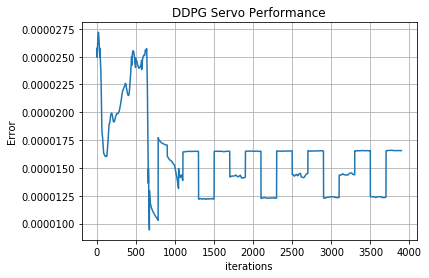

In [53]:

plt.plot(np.arange(1,3898),PID.error[100:3998])
plt.title("DDPG Servo Performance") 
plt.xlabel("iterations")
plt.ylabel("Error")
plt.grid()
plt.show()

In [ ]:
values